# PROJECT -  A2Z CUSTOMER SEGMENTATION

## Introduction
Data herein presented pertains to a fictional insurance company in Portugal, A2Z Insurance. The goal is to develop a customer segmentation strategy that will enable the Marketing Department to better understand the different customers' profiles and develop adequate marketing strategies. <br>
This project is done within the cope of the **Data Mining** curricular unit of the Master's Degree in **Data Science and Advanced Analytics**.

#### Group elements:
* Ivan Jure Parać (20210689)
* Nuno de Bourbon e Carvalho Melo (20210681)
* Stuart Gallina Ottersen (20210703)


## Table of Contents
1. [Data exploration](#data-exploration)
2. [Data preprocessing](#data-preprocessing)
    1. [First steps](#preprocessing-first-steps)
    2. [Dealing with outliers](#preprocessing-outliers)
    3. [Handling missing values](#preprocessing-missing-values)
    4. [Feature creation and cross field validation](#preprocessing-transform-validate)
    5. [Feature selection](#preprocessing-feature-selection)
    6. [Feature skewness](#preprocessing-scaling)
3. [Clustering](#data-clustering)
    1. [Sociodemographic clustering](#clustering-sociodemographic)
    2. [Value clustering](#clustering-value)
    3. [Product clustering](#clustering-product)

***

<h2><center>BOILERPLATE</center></h2>

***

In [2]:
# uncomment next line of code to install package required for KPrototypes
# !pip install kmodes

In [3]:
# import major libraries/modules
import pyreadstat
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics as metrics

# others
from math import ceil
from collections import Counter
from regressors import stats
from scipy.cluster import hierarchy
from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, OPTICS, MeanShift, Birch, SpectralClustering, estimate_bandwidth
from sklearn.feature_selection import RFE

# self-organizing maps
import sompy
from sompy.visualization.mapview import View2D, View2DPacked
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [5]:
# load SAS file with the insurance company data
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

# save copy of the original dataframe
original_df = df.copy()

<a class="anchor" id="data-exploration"></a>

***

<h2><center>DATA EXPLORATION</center></h2>

***

In [6]:
# first look at the dataframe
df.head()

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  2 - High School    2177.0         1.0   
1     2.0        1981.0     1995.0  2 - High School     677.0         4.0   
2     3.0        1991.0     1970.0        1 - Basic    2277.0         3.0   
3     4.0        1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
4     5.0        1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

In [7]:
# check number of rows and columns
print("Number of observations:", df.shape[0])
print("Number of features:", df.shape[1])
print("Features:", list(df.columns))

Number of observations: 10296
Number of features: 14
Features: ['CustID', 'FirstPolYear', 'BirthYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']


In [8]:
# describe the data
df.describe(include = "all").T

count unique          top  freq         mean          std  \
CustID         10296.0    NaN          NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN          NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN          NaN   NaN  1968.007783    19.709476   
EducDeg          10296      5  3 - BSc/MSc  4799          NaN          NaN   
MonthSal       10260.0    NaN          NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN          NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN          NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN          NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN          NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN          NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN          NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN          NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN          NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN          NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [9]:
# more information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10296 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


<a class="anchor" id="data-preprocessing"></a>

***

<h2><center>2. DATA PREPROCESSING</center></h2>

***

In [10]:
def plot_multiple(df, features, plot_type, fig_dimensions = [15, 8], nr_rows = 1):

    '''
    Takes in a dataframe, df, a list of features, features,
    a plot type, plot_type, the dimensions of the figure,
    fig_dimensions, and the number of rows of the figure,
    nr_rows, as argument, and plots the specified plot type
    for the features passed as arguments.

    Arguments:
     df (dataframe): dataframe
     features (list): features from df to plot (min. 2 features)
     plot_type (str): type of plot (box, violin, or histogram)
     fig_dimensions (list, tuple): figure dimensions
     nr_rows (int): number of rows in the figure

    Returns:
     None
    '''

    sns.set(style = "ticks")

    fig, axes = plt.subplots(nr_rows, ceil(len(features) / nr_rows), figsize = fig_dimensions)
    
    # iterate through axes and associate each plot to one
    for ax, feat in zip(axes.flatten(), features):
        if (plot_type.lower() == "box") or (plot_type.lower() == "boxplot"):
            sns.boxplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "violin" or (plot_type.lower() == "violinplot")):
            sns.violinplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "histogram" or (plot_type.lower() == "histplot")):
            sns.histplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

    plt.show()

    return

<a class="anchor" id="preprocessing-first-steps"></a>

<h3><right>2.1. First steps</right></h3>

* Set customer ID as index
* Remove duplicated observations
* Encode EducDeg and change to float
* Swap incoherent birth and first policy years

In [11]:
# set customer ID as index
df.CustID = df.CustID.astype("int")
df.set_index("CustID", inplace = True)

In [12]:
# check for duplicated rows
print("Number of duplicates:", df.duplicated().sum())

# remove duplicate rows
df.drop_duplicates(inplace = True)
print("Removing duplicates...")
print("Number of duplicates:", df.duplicated().sum())

# store initial number of rows (after duplicate removal)
initial_len = len(df)

# check number of rows and columns again
print("\nCurrent number of observations:", df.shape[0])
print("Current number of features:", df.shape[1])

df.head()

Number of duplicates: 3
Removing duplicates...
Number of duplicates: 0

Current number of observations: 10293
Current number of features: 13


FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
CustID                                                                   
1             1985.0     1982.0  2 - High School    2177.0         1.0   
2             1981.0     1995.0  2 - High School     677.0         4.0   
3             1991.0     1970.0        1 - Basic    2277.0         3.0   
4             1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
5             1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
1            1.0      380.97        0.39     375.85          79.45   
2            1.0     -131.13        1.12      77.46         416.20   
3            0.0      504.67        0.28     206.15         224.50   
4            1.0      -16.99        0.99     182.48          43.35   
5            1.0       35.23        0.90     338.62          47.80   

        PremHealth  PremLife  PremWork  
CustID                                  
1           146.36     47.01     16.89  
2           116.69    194.48    106.13  
3           124.58     86.35     99.02  
4           311.17     35.34     28.34  
5           182.59     18.78     41.45

In [13]:
# checking data types

# extract number from EducDeg, save as float
df.EducDeg = df.EducDeg.str.extract("(\d+)").astype("float")
# education degree mapper (to replace numbers when needed)
educ_mapper = {1: "Basic", 2: "High School", 3: "BSc/MSc", 4: "PhD"}

# check data types
df.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg          float64
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [14]:
# swaps years if policy seems to be made before birth
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
pc_incoherences = round(nr_incoherences/len(df)*100, 1)

print(f"Number of people with a policy before birth: {nr_incoherences} "
    f"({pc_incoherences}% of the dataset)")

# such high number of inconsistencies suggests systematic error
# assumption: in these cases BirthYear and FirstPolYear were introduced in the wrong fields
print("Swapping birth and first policy years...")

# swap FirstPolYear and BirthYear values when birth occurs after first policy creation
row_filter = df.BirthYear > df.FirstPolYear
df.loc[row_filter, ["FirstPolYear", "BirthYear"]] = df.loc[row_filter, ["BirthYear", "FirstPolYear"]].values

# check if the years were correctly swapped
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
print(f"Number of people with a policy before birth: {nr_incoherences}")

Number of people with a policy before birth: 1997 (19.4% of the dataset)
Swapping birth and first policy years...
Number of people with a policy before birth: 0


<a class="anchor" id="preprocessing-outliers"></a>

<h3><right>2.2. Dealing with outliers</right></h3>

* Remove outliers and store them in a separate dataframe

In [15]:
def remove_outliers(df, filters):

    # create a separate dataframe for the outliers
    outliers = pd.DataFrame()

    # remove outliers from main dataframe
    # add outliers to a separate dataframe
    for filter_ in filters:
        outliers = outliers.append(df[filter_])
        df = df[~filter_]
        
    # determine number of outliers removed
    n_outliers = len(outliers)
    pc_removed = round(n_outliers/initial_len*100, 2)
    print(f"Number of outliers removed: {n_outliers} ({pc_removed}% of all observations)")

    return (df, outliers)

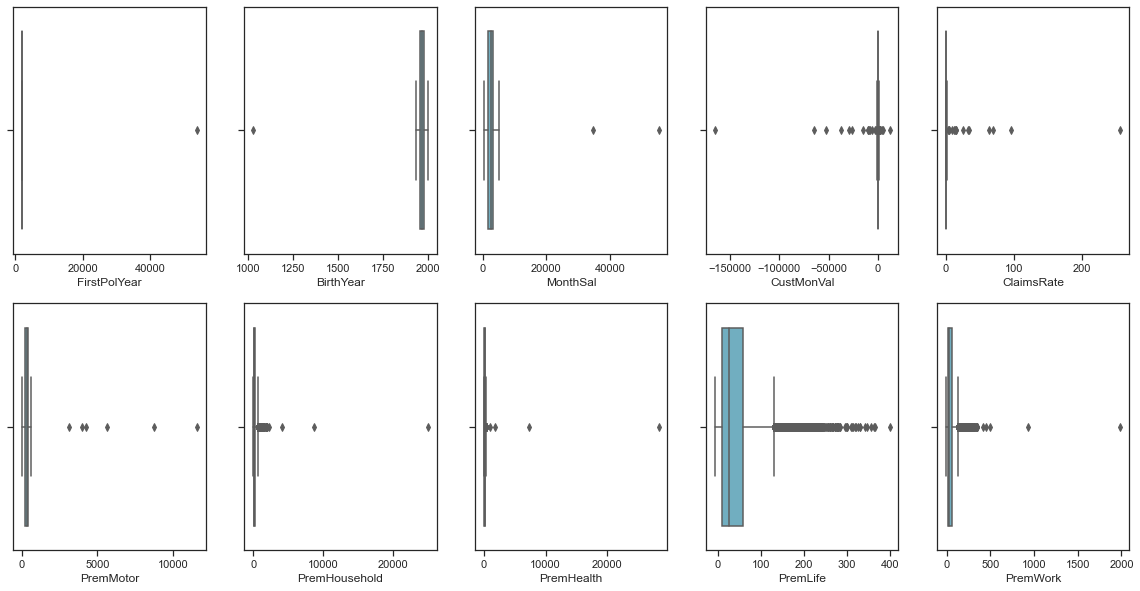

In [16]:
# define metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children"]

# boxplots of metric features
plot_multiple(df, metric_features, "box", [20, 10], nr_rows = 2)

Number of outliers removed: 134 (1.3% of all observations)


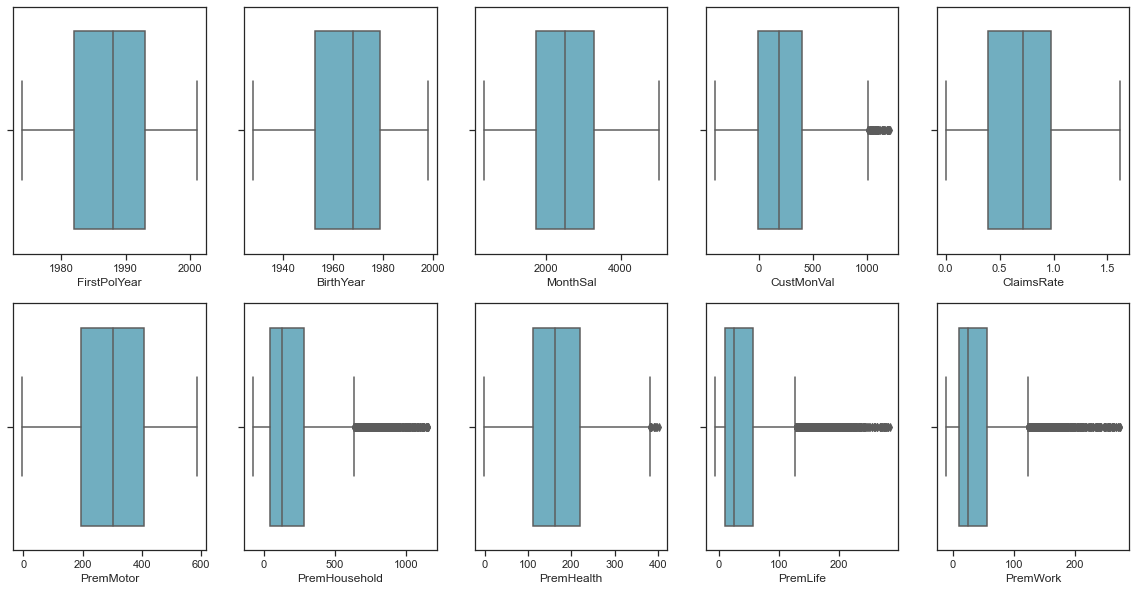

In [17]:
# BirthYear 1028 assumed to be a typo
# 0 and 9 are fairly close in a qwerty keyboard, replaced with 1928
df.loc[df.BirthYear == 1028, "BirthYear"] = 1928

# remove outliers from df, store them in df_outliers1
filters = (
    (df.FirstPolYear.ge(2017)),
    (df.MonthSal.ge(20000)),
    (df.CustMonVal.le(-2000)),
    (df.CustMonVal.ge(1250)),
    (df.ClaimsRate.ge(4)),
    (df.PremMotor.ge(3000)),
    (df.PremHousehold.ge(1160)),
    (df.PremHealth.ge(405)),
    (df.PremLife.ge(290)),
    (df.PremWork.ge(275))
)

df, df_outliers1 = remove_outliers(df, filters)

# boxplots of metric features after removing outliers
plot_multiple(df, metric_features, "box", [20, 10], nr_rows = 2)

<a class="anchor" id="preprocessing-missing-values"></a>

<h3><right>2.3. Handling missing values</right></h3>

* Check feature and row completeness (in df and df_outliers)
* Remove customers with no information about Premiums
* Remove customers with missing FirstPolYear or BirthYear
* Remove customers with missing EducDeg
* Fill Premium missing values with zero
* Create Linear Regression model to impute MonthSal
* Create Logistic Regression model to impute Children

In [18]:
def check_completeness(df):

    '''
    Takes in a dataframe, df, as argument and
    computes the number/percentage of missing
    values per feature, and the number of rows
    with the maximum number of missing values.

    Arguments:
     df (dataframe): dataframe

    Returns:
     None
    '''

    # number and percentage of NaN values per feature
    nr_nans = df.isna().sum()
    pc_nans = df.isna().mean()*100
    feature_nans = pd.concat([nr_nans, pc_nans], axis = 1)
    feature_nans.rename(columns = {0: "nr", 1: "%"}, inplace = True)

    # show number of missing values per feature
    print("Missing values per feature:\n", feature_nans)

    # check row completeness
    # max number of NaN values in a row and number of rows with that many NaN
    max_row_nan = df.isnull().sum(axis = 1).max()
    
    print(f"\nMaximum number of NaN values per row: {max_row_nan} "
        f"({len(df[df.isnull().sum(axis = 1) == max_row_nan])} rows)")

    return

In [19]:
def remove_missing_values(df, cols, max_nan_per_row):

    '''
    Takes in a dataframe, df, a list of columns, cols,
    and the maximum number of nan per row, max_nan_per_row,
    and removes rows that have missing values in the columns
    passed on as arguments as well as rows that exceed the
    maximum number of missing values allowed.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to remove NaN
     max_nan_per_row (int): max number of NaN allowed per row

    Returns:
     df (dataframe): dataframe after removing NaN
     df_nan (dataframe): dataframe with the NaN rows removed from df
    '''

    # create dataframe to store rows discarded due to missing values
    df_nan = pd.DataFrame()

    # removing rows above the threshold of maximum missing values allowed
    max_nan_rows = df[df.isnull().sum(axis = 1) >= max_nan_per_row]
    df_nan = df_nan.append(max_nan_rows)
    df.drop(max_nan_rows.index, inplace = True)

    print(
        f"Removed {len(max_nan_rows)} row(s) "
        f"(missing {round(max_nan_per_row/len(df.columns)*100, 1)}% of their data)"
    )

    # remove rows with missing values from features passed as arguments
    # add these rows to df_nan
    for col in cols:
        nan_ = df[col].isna()
        nr_removed = sum(nan_)

        df_nan = df_nan.append(df[nan_])
        df = df[~nan_]

        print(f"Removed {nr_removed} row(s) (NaN in {col})")

    # show total number of missing values removed
    nr_rows_removed = len(df_nan)
    total_removed = initial_len - len(df)

    print(
        f"Total number of rows removed: {nr_rows_removed}\n"
        f"Total number of rows removed so far: {total_removed} "
        f"({round(total_removed/initial_len*100, 2)}%)"
    )

    return (df, df_nan)

In [20]:
def zero_imputer(df, cols):

    '''
    Takes in a dataframe, df, and a list of columns,
    cols, and replaces existing missing values in
    those columns with zero.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to impute NaN with 0
    
    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # save the total number of imputed values
    total_imputations = 0

    # impute each NaN value in cols with zero
    for col in cols:
        col_nan = sum(df[col].isna())
        df[col].fillna(0, inplace = True)

        # print number of imputed values per column
        print(f"Imputed {col_nan} out of {col_nan} missing value(s) in {col}")
        
        total_imputations += col_nan

    print(f"Total number of imputations: {total_imputations}")

    return df

In [21]:
def linreg_imputer(df, regressors, regressand):

    '''
    Takes in a dataframe, df, a list of regressor names,
    regressors, and the name of the regressand, regressand,
    and uses a linear regression model to predict missing
    values in the regressand based on the regressors.

    Arguments:
     df (dataframe): dataframe
     regressors (str, list): list of columns in df to be used
    in linear regression to predict the regressand
     regressand (str): name of column in df whose missing values
    will be imputed with values predicted by linear regression

    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if (type(regressors) is not list) and (type(regressors) is str):
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler() with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create and fit model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)

    # predict salary of the validation set
    y_pred = lin_reg.predict(X_val_scaled)

    # compute metrics for the predictions made
    mse = metrics.mean_squared_error(y_val, y_pred)
    rmse = metrics.mean_squared_error(y_val, y_pred, squared = False)
    mae = metrics.mean_absolute_error(y_val, y_pred)

    print("")
    print("======================================================")
    print("                Linear regression model               ")
    print("======================================================")
    print("Mean square error:", round(mse, 2))
    print("Root mean square error:", round(rmse, 2))
    print("Mean absolute error:", round(mae, 2))
    stats.summary(clf = lin_reg, X = X_train_scaled, y = y_train)
    print("======================================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)

    X_test_scaled = scaler.transform(X_test)
    y_pred = lin_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred
    
    print(f"\nImputed {len(y_pred)} values in {regressand}")

    return df

In [22]:
def knreg_choose_k(df, regressors, regressand, max_n_neighbors):

    neighborhood_sizes = np.arange(1, max_n_neighbors+1)

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if (type(regressors) is not list) and (type(regressors) is str):
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler() with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # set up lists for the metrics
    rmse_values = list()
    mae_values = list()
    adj_r2_values = list()

    for n in neighborhood_sizes:
        # create and fit model for each number of neighbors
        kn_reg = KNeighborsRegressor(n_neighbors = n, weights = "distance")
        kn_reg.fit(X_train_scaled, y_train)
        # predict salary of the validation set
        y_pred = kn_reg.predict(X_val_scaled)

        # compute metrics
        rmse = metrics.mean_squared_error(y_val, y_pred, squared = False)
        mae = metrics.mean_absolute_error(y_val, y_pred)
        r2 = metrics.r2_score(y_val, y_pred)
        adj_r2 = 1 - (1 - r2)*((X_val.shape[0] - 1)/(X_val.shape[0] - X_val.shape[1] - 1))

        # append values to corresponding list
        rmse_values.append(rmse)
        mae_values.append(mae)
        adj_r2_values.append(adj_r2)

    # get number of neighbors that provide the 'best' the metrics evaluated
    n_min_rmse = rmse_values.index(np.min(rmse_values)) + 1
    n_min_mae = mae_values.index(np.min(mae_values)) + 1
    n_max_adj_r2 = adj_r2_values.index(np.max(adj_r2_values)) + 1

    print(
        f"k = {n_min_rmse} minimises RMSE ({round(np.min(rmse_values), 2)})\n"
        f"k = {n_min_mae} minimises MAE ({round(np.min(mae_values), 2)})\n"
        f"k = {n_max_adj_r2} maximises adjusted R-squared ({round(np.max(adj_r2_values), 2)})"
    )

    # list of computed metrics
    metrics_ = [rmse_values, mae_values, adj_r2_values]
    y_labels = ["RMSE", "MAE", "R2 (adjusted)"]

    # plot the error and adjusted R2 values
    sns.set(style = "ticks")

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for ax, metric, y_label in zip(axes.flatten(), metrics_, y_labels):
        sns.lineplot(x = neighborhood_sizes,
            y = metric,
            marker = "o",
            mew = 0,
            ax = ax,
            color = "C9",
            linewidth = 4    
        )
        ax.set_xlabel("Number of neighbors, k")
        ax.set_ylabel(y_label)
    
    return

In [23]:
def logreg_feat_selection(df, regressand):

    # independent, X, and dependent, y, variables
    X = df.dropna().drop(columns = regressand)
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training set
    X_train_scaled = scaler.transform(X_train)
    # scale the test set
    X_val_scaled = scaler.transform(X_val)

    # recursive feature elimination
    numfeats_list = np.arange(1, len(df.columns))
    scores = {}

    for n in range(len(numfeats_list)):
        log_reg = LogisticRegression()
        rfe = RFE(estimator=log_reg, n_features_to_select=numfeats_list[n])
        
        X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
        X_val_rfe = rfe.transform(X_val_scaled)
        log_reg.fit(X_train_rfe, y_train)
        
        score = log_reg.score(X_val_rfe, y_val)
        scores[n+1] = score

    # RFE selected 1 single feature
    best_num_feats = max(scores, key = scores.get)
    rfe = RFE(estimator = log_reg, n_features_to_select = best_num_feats)
    rfe.fit(X = X_train_scaled, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns, name = "RFE")

    # compute correlation between Children and other features
    correlations = pd.Series(df.corr()[regressand], name = "Correlation")

    # compute Lasso coefficients
    reg = LassoCV()
    reg.fit(X_train_scaled, y_train)
    lasso_coef = pd.Series(reg.coef_, index = X_train.columns, name = "Lasso")

    # concatenate features selected by rfe, correlations, and lasso coefficients
    selection_df = pd.concat([selected_features, correlations, lasso_coef], axis = 1).drop(regressand)

    # plot correlation and lasso coefficients
    coef_names = ["Correlation", "Lasso"]

    sns.set()
    sns.set_style("white")
    fig, axes = plt.subplots(1, ceil(len(coef_names)), figsize = (24, 10))

    for ax, coef in zip(axes.flatten(), coef_names):
        sns.barplot(data = selection_df,
                    x = coef,
                    y = selection_df.index,
                    hue = "RFE",
                    palette = ["darkgray", "C9"],
                    order = selection_df.sort_values(coef).index,
                    ax = ax)
        ax.axvline(x = 0, linestyle = "--", color = "darkgray", label = "_nolegend_")
        ax.set_xlabel(coef + " coefficient", fontsize = 16)
        ax.legend(title = "RFE", loc = "upper right", fontsize = 14)

    plt.show()

    return

In [24]:
def logreg_imputer(df, regressors, regressand):
            
    # imputing missing Children values
    # conclusion based on previous feature selection: use only BirthYear

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    # 70% have children, 30% dont, decided to stratify
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create a logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)

    # predict y
    y_pred = log_reg.predict(X_val_scaled)

    # evaluate the predictions of the logistic reg model
    conf_matrix = metrics.confusion_matrix(y_val, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)
    accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
    precision = round(metrics.precision_score(y_val, y_pred)*100, 2)
    recall = round(metrics.recall_score(y_val, y_pred)*100, 2)
    f1 = round(metrics.f1_score(y_val, y_pred)*100, 2)

    print("==============================================")
    print("           Logistic regression model          ")
    print("==============================================")
    print("Accuracy:", accuracy, "%")
    print("Precision:", precision, "%")
    print("Recall:", recall, "%")
    print("F1 score:", f1, "%")
    print("Confusion matrix:\n", conf_matrix)
    print("==============================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)
    
    X_test_scaled = scaler.transform(X_test)
    y_pred = log_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred

    print(f"\nImputed {len(y_pred)} values in {regressand}") 

    return df

In [25]:
def knclassif_choose_k(df, regressors, regressand, max_n_neighbors):

    neighborhood_sizes = np.arange(1, max_n_neighbors+1)

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    # 70% have children, 30% dont, decided to stratify
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # set up lists for metrics
    accuracy_values = list()
    precision_values = list()
    recall_values = list()
    f1_values = list()

    for n in neighborhood_sizes:
        # create a logistic regression model
        log_reg = KNeighborsClassifier(n_neighbors = n, weights = "distance").fit(X_train_scaled, y_train)
        # predict y
        y_pred = log_reg.predict(X_val_scaled)

        # compute metrics
        accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
        precision = round(metrics.precision_score(y_val, y_pred)*100, 2)
        recall = round(metrics.recall_score(y_val, y_pred)*100, 2)
        f1 = round(metrics.f1_score(y_val, y_pred)*100, 2)

        # append values to corresponding list
        accuracy_values.append(accuracy)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

    # get number of neighbors that provide the 'best' metrics
    n_max_accuracy = accuracy_values.index(np.max(accuracy_values)) + 1
    n_max_precision = precision_values.index(np.max(precision_values)) + 1
    n_max_recall = recall_values.index(np.max(recall_values)) + 1
    n_max_f1 = f1_values.index(np.max(f1_values)) + 1

    print(
        f"k = {n_max_accuracy} maximises accuracy ({round(np.max(accuracy_values), 2)})\n"
        f"k = {n_max_precision} maximises precision ({round(np.max(precision_values), 2)})\n"
        f"k = {n_max_recall} maximises recall ({round(np.max(recall_values), 2)})\n"
        f"k = {n_max_f1} maximises F1 score ({round(np.max(f1_values), 2)})\n"
    )

    # list of computed metrics
    metrics_ = [accuracy_values, precision_values, recall_values, f1_values]
    y_labels = ["Accuracy, %", "Precision, %", "Recall, %", "F1 score"]

    # plot the error and adjusted R2 values
    sns.set(style = "ticks")

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    for ax, metric, y_label in zip(axes.flatten(), metrics_, y_labels):
        sns.lineplot(x = neighborhood_sizes,
            y = metric,
            marker = "o",
            mew = 0,
            ax = ax,
            color = "C9",
            linewidth = 4    
        )
        ax.set_xlabel("Number of neighbors, k")
        ax.set_ylabel(y_label)  

    return

In [26]:
# check missing values in the dataframe
check_completeness(df)

Missing values per feature:
                 nr         %
FirstPolYear    30  0.295305
BirthYear       17  0.167339
EducDeg         17  0.167339
MonthSal        36  0.354366
GeoLivArea       1  0.009843
Children        21  0.206713
CustMonVal       0  0.000000
ClaimsRate       0  0.000000
PremMotor       33  0.324835
PremHousehold    0  0.000000
PremHealth      42  0.413427
PremLife       103  1.013879
PremWork        85  0.836697

Maximum number of NaN values per row: 4 (12 rows)


In [27]:
# drops rows with missing values in FirstPolYear, BirthYear, EducDeg
# drop highly incomplete rows (no information about Premiums)
max_nan_per_row = df.isnull().sum(axis = 1).max()
cols = ["FirstPolYear", "BirthYear", "EducDeg"]
df, df_nan = remove_missing_values(df, cols, max_nan_per_row)

Removed 12 row(s) (missing 30.8% of their data)
Removed 30 row(s) (NaN in FirstPolYear)
Removed 14 row(s) (NaN in BirthYear)
Removed 2 row(s) (NaN in EducDeg)
Total number of rows removed: 58
Total number of rows removed so far: 192 (1.87%)


In [28]:
# impute missing values in the Premium features
cols = [col for col in df if col.startswith("Prem")]
df = zero_imputer(df, cols)

Imputed 21 out of 21 missing value(s) in PremMotor
Imputed 0 out of 0 missing value(s) in PremHousehold
Imputed 29 out of 29 missing value(s) in PremHealth
Imputed 91 out of 91 missing value(s) in PremLife
Imputed 72 out of 72 missing value(s) in PremWork
Total number of imputations: 213


In [29]:
# choose feature(s) to use for linear regression of MonthSal
corr_salary = pd.Series(df.corr().MonthSal, name = "Correlation").sort_values()
print("Correlation between salary and other features:")
print(round(corr_salary, 3))

Correlation between salary and other features:
BirthYear       -0.904
Children        -0.467
FirstPolYear    -0.290
PremLife        -0.232
PremWork        -0.232
PremHousehold   -0.218
CustMonVal      -0.052
ClaimsRate       0.002
GeoLivArea       0.008
PremHealth       0.020
EducDeg          0.166
PremMotor        0.210
MonthSal         1.000
Name: Correlation, dtype: float64


In [30]:
# MonthSal imputation

# Option 1: KNReg
# sal_regressors = df.columns.drop("MonthSal")
# regressand = "MonthSal"
# knreg_choose_k(df, sal_regressors, regressand, max_n_neighbors = 20)


# Option 2: LinReg
# using all features (MSE 171009, RMSE 414, MAE 331, Adj R2 0.817)
# sal_regressors = df.columns.drop("MonthSal")
# regressand = "MonthSal"
# df = linreg_imputer(df, sal_regressors, regressand)

# using BirthYear and Children (MSE 177996, RMSE 422, MAE 334, Adj R2 0.818)
# sal_regressors = ["BirthYear", "Children"]
# regressand = "MonthSal"
# df = linreg_imputer(df, sal_regressors, regressand)

# using BirthYear only (very high correlation of -0.9)
sal_regressors = ["BirthYear"]
regressand = "MonthSal"
df = linreg_imputer(df, sal_regressors, regressand)

# better predictions with linear regression than KNRegressor
# similar results using a simple linear regression with BirthYear and using a multiple regression with all features


                Linear regression model               
Mean square error: 178655.77
Root mean square error: 422.68
Mean absolute error: 334.11
Residuals:
       Min        1Q   Median       3Q       Max
-1501.8153 -287.4902 -16.9852 265.6322 1876.3774


Coefficients:
               Estimate  Std. Error   t value  p value
_intercept  4706.377413    9.597193  490.3910      0.0
x1         -4004.895000   20.576523 -194.6342      0.0
---
R-squared:  0.81745,    Adjusted R-squared:  0.81743
F-statistic: 31507.22 on 1 features

Imputed 33 values in MonthSal


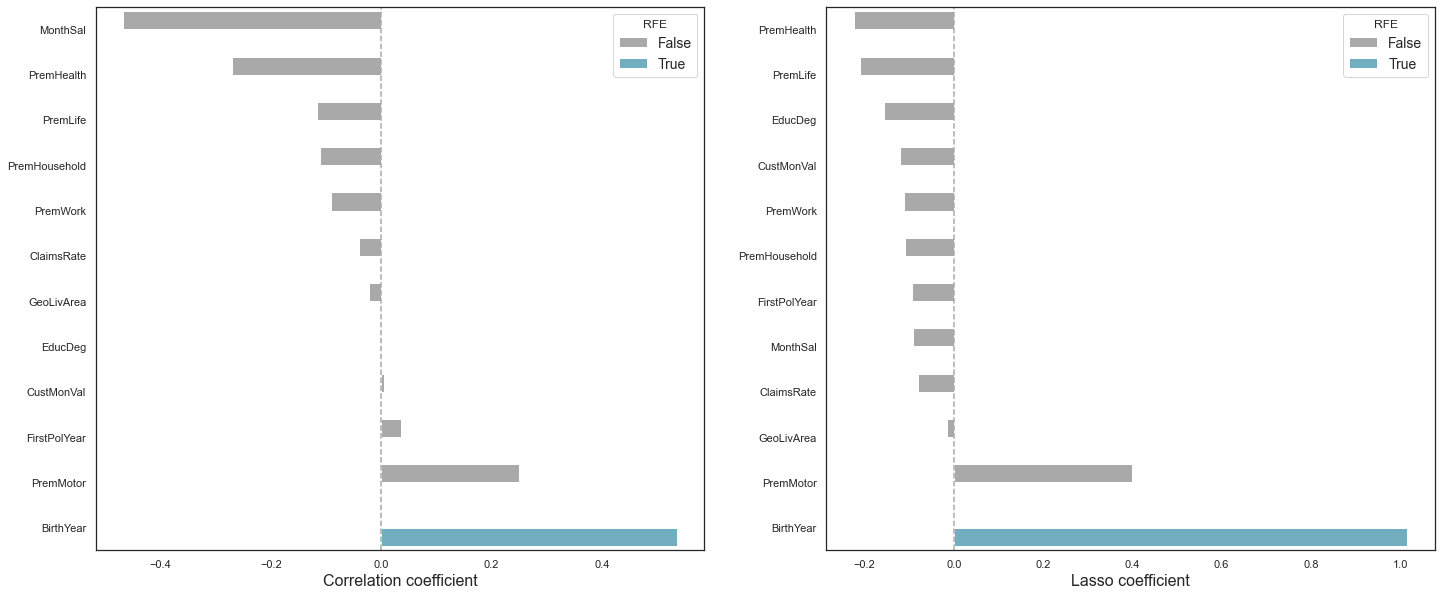

           Logistic regression model          
Accuracy: 86.29 %
Precision: 87.49 %
Recall: 94.07 %
F1 score: 90.66 %
Confusion matrix:
      0     1
0  597   288
1  127  2015

Imputed 13 values in Children


In [31]:
# Children imputation

# Option 1: KNClassifier
# child_regressors = list(df.columns.drop("Children"))
# regressand = "Children"
# knclassif_choose_k(df, child_regressors, regressand, max_n_neighbors = 25)


# Option 2: LogReg
# choose features (RFE, correlations, Lasso)
logreg_feat_selection(df, "Children")

# KNClassifier (all features, k = 23, weights = distance) and logistic regression with BirthYear provide similar predictions
# impute children missing values with Logistic Regression
children_regressors = ["BirthYear"]
df = logreg_imputer(df, children_regressors, "Children")

In [32]:
# check if all NaN values were dealt with
check_completeness(df)

Missing values per feature:
                nr    %
FirstPolYear    0  0.0
BirthYear       0  0.0
EducDeg         0  0.0
MonthSal        0  0.0
GeoLivArea      0  0.0
Children        0  0.0
CustMonVal      0  0.0
ClaimsRate      0  0.0
PremMotor       0  0.0
PremHousehold   0  0.0
PremHealth      0  0.0
PremLife        0  0.0
PremWork        0  0.0

Maximum number of NaN values per row: 0 (10101 rows)


In [33]:
# check missing values in df_outliers1
check_completeness(df_outliers1)

# deal with Premium missing values in df_outliers1
cols = ["PremMotor", "PremHealth", "PremLife", "PremWork"]
df_outliers1 = zero_imputer(df_outliers1, cols)

Missing values per feature:
                nr         %
FirstPolYear    0  0.000000
BirthYear       0  0.000000
EducDeg         0  0.000000
MonthSal        0  0.000000
GeoLivArea      0  0.000000
Children        0  0.000000
CustMonVal      0  0.000000
ClaimsRate      0  0.000000
PremMotor       1  0.746269
PremHousehold   0  0.000000
PremHealth      1  0.746269
PremLife        1  0.746269
PremWork        1  0.746269

Maximum number of NaN values per row: 2 (1 rows)
Imputed 1 out of 1 missing value(s) in PremMotor
Imputed 1 out of 1 missing value(s) in PremHealth
Imputed 1 out of 1 missing value(s) in PremLife
Imputed 1 out of 1 missing value(s) in PremWork
Total number of imputations: 4


<a class="anchor" id="preprocessing-transform-validate"></a>

<h3><right>2.4. Feature creation</right></h3>

* Add columns: Age, FirstPolAge, CustYears, Generation, PremTotal, Premium ratios
* Check if EducDeg makes sense given the customer's age
* Convert MonthSal to YearSal
* Remove outliers from newly created features
* Transform skewed metric features

In [34]:
def feature_creator(df):
    
    # save columns originally present in the dataframe
    initial_cols = df.columns

    # create Age column
    # (customers age as of 2016)
    curr_year = 2016
    cust_ages = curr_year - df.BirthYear
    df["Age"] = cust_ages
    
    # create FirstPolAge column
    # (customers age at the time of the first policy creation)
    firstpol_ages = df.FirstPolYear - df.BirthYear
    df["FirstPolAge"] = firstpol_ages
    
    # create CustYears column
    # (number of years as a customer to the company)
    df["CustYears"] = curr_year - df.FirstPolYear
    
    # create Generation column
    # (generation customers belongs to)
    df.loc[(df.BirthYear >= 1928) & (df.BirthYear <= 1945), "Generation"] = 1 # Silent Gen
    df.loc[(df.BirthYear >= 1946) & (df.BirthYear <= 1964), "Generation"] = 2 # Baby Boomer
    df.loc[(df.BirthYear >= 1965) & (df.BirthYear <= 1980), "Generation"] = 3 # Gen X
    df.loc[(df.BirthYear >= 1981) & (df.BirthYear <= 1996), "Generation"] = 4 # Millennial
    df.loc[(df.BirthYear >= 1997) & (df.BirthYear <= 2012), "Generation"] = 5 # Gen Z
    df.Generation = df.Generation.astype("float")
    
    # create YearSal column
    # (customers yearly income)
    year_sals = df.MonthSal * 12
    df["YearSal"] = year_sals
    
    # create a PremTotal column
    # (customers total money spent on premiums)
    premium_cols = ["PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
    df["PremTotal"] = df[premium_cols].sum(axis = 1)

    # create Effort column
    # (proportion of the yearly salary each customer spends on the company)
    efforts = df.PremTotal / df.YearSal
    df["EffortRatio"] = efforts
    
    # create PremiumRatio columns
    # (proportion of the total premium spent on each type of policy)
    for col in premium_cols:
        newcol_vals = df[col]/df["PremTotal"]
        newcol_name = col + "Ratio"
        df[newcol_name] = newcol_vals

    # verbose: list of newly created columns
    new_cols = df.columns.drop(initial_cols)
    print(f"Created {len(new_cols)} new features:\n{list(new_cols)}")
        
    return df

In [35]:
# update dataframe with new features
df = feature_creator(df)

# also add the new features to df_outliers1
# needed so that they can be assigned to clusters later on
df_outliers1 = feature_creator(df_outliers1)

# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

Created 12 new features:
['Age', 'FirstPolAge', 'CustYears', 'Generation', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']
Created 12 new features:
['Age', 'FirstPolAge', 'CustYears', 'Generation', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']


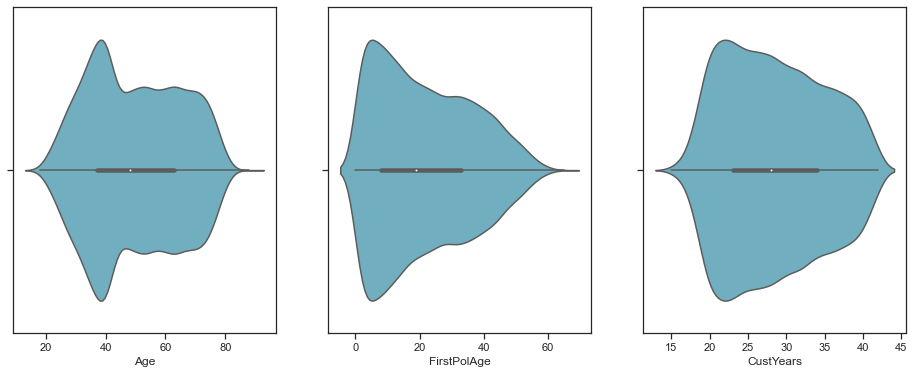

In [36]:
# violinplots of the newly created year-related features
features = ["Age", "FirstPolAge", "CustYears"]
plot_multiple(df, features, "violin", fig_dimensions = [16, 6])

Text(0, 0.5, 'Count')

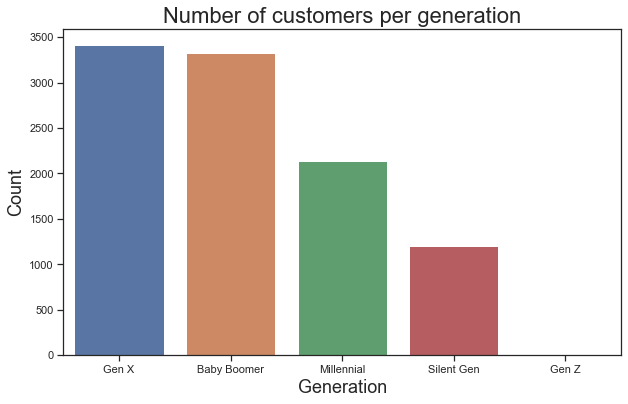

In [37]:
# visualize Generation feature
# generation mapper
gen_mapper = {
    1: "Silent Gen",
    2: "Baby Boomer",
    3: "Gen X",
    4: "Millennial",
    5: "Gen Z"
}

# count number of customers per generation
gen_count = df.groupby("Generation").size().sort_values(ascending = False)
gen_count.rename(index = gen_mapper, inplace = True)

# visualize number of customers per generation
fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(x = gen_count.index, y = gen_count.values, order = gen_count.index)
plt.title("Number of customers per generation", fontsize = 22)
plt.xlabel("Generation", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

# plt.show()

# almost no customers from the younger generation, Gen Z

In [38]:
# cross-validate EducDeg and Age
# minimum age is 18 - meaning everyone can have an education up to High School
# minimum age of 20 for a BSc
# minimum age of 23 for a PhD (skipping MSc and finishing in 3 years, UK or outside of the EU)
educdeg_min_age = df.groupby("EducDeg").Age.min().rename(index = educ_mapper)
print("======================================")
print("   Cross-validating EducDeg and Age   ")
print("======================================")
print("Minimum age associated to each EducDeg")
print(educdeg_min_age)

# no incoherences found

   Cross-validating EducDeg and Age   
Minimum age associated to each EducDeg
EducDeg
Basic          18.0
High School    19.0
BSc/MSc        20.0
PhD            23.0
Name: Age, dtype: float64


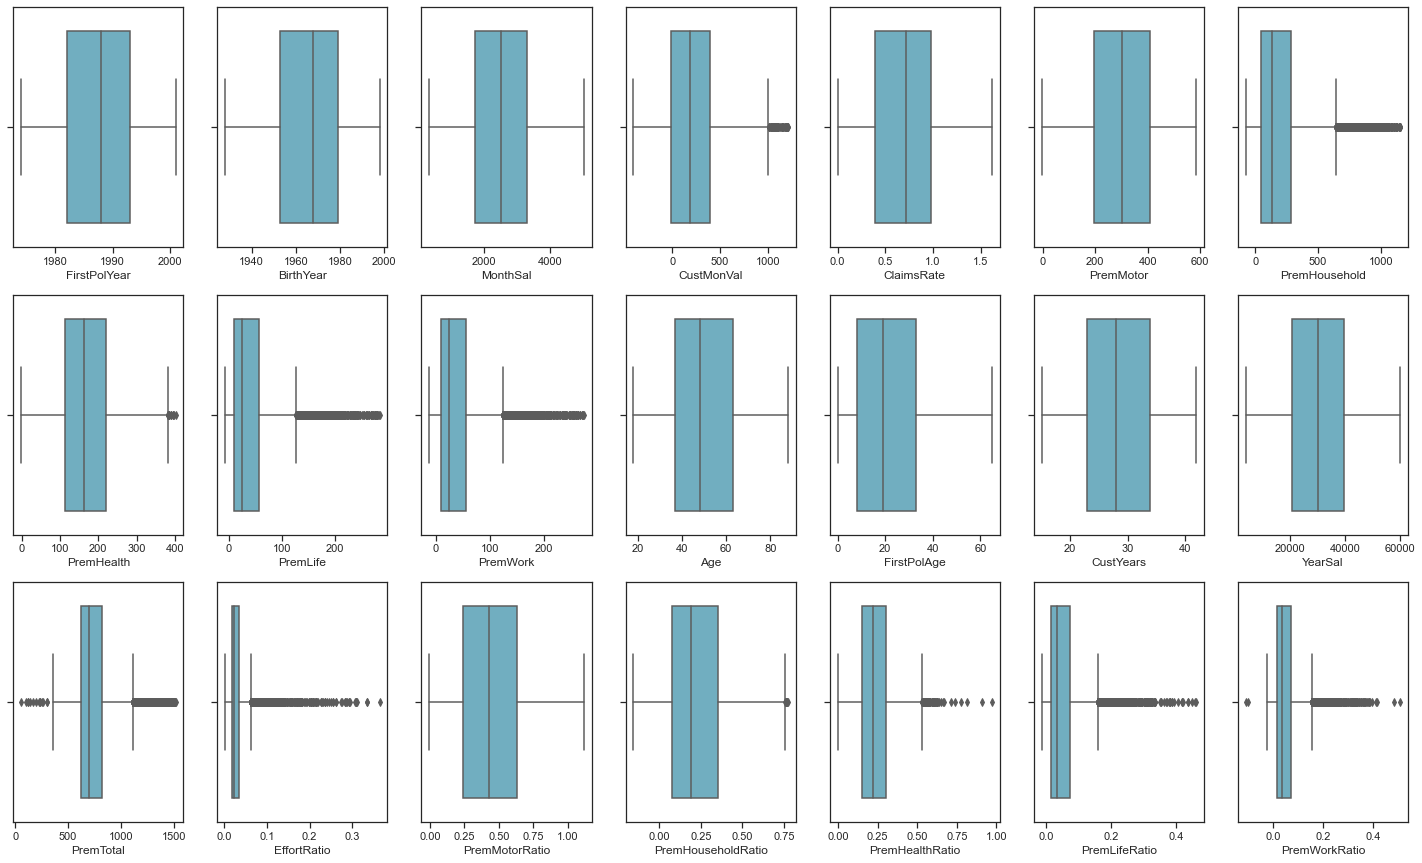

In [39]:
# plot metric features
plot_multiple(df, metric_features, "box", fig_dimensions = [25, 15], nr_rows = 3)

In [40]:
# conditions to remove outliers
filters = (
    (df.PremHouseholdRatio.ge(0.85)),
    (df.PremHealthRatio.ge(0.64)),
    (df.PremLifeRatio.ge(0.40)),
    (df.PremWorkRatio.ge(0.40)),
    (df.PremWorkRatio.le(-0.05)),
    (df.PremTotal.le(350)),
    (df.PremTotal.ge(1750)),
    (df.EffortRatio.ge(0.26))
)

# remove outliers from newly created features, store them in outliers2
df, df_outliers2 = remove_outliers(df, filters)

# merge the two outliers dataframes
df_outliers = pd.concat([df_outliers1, df_outliers2])

Number of outliers removed: 50 (0.49% of all observations)


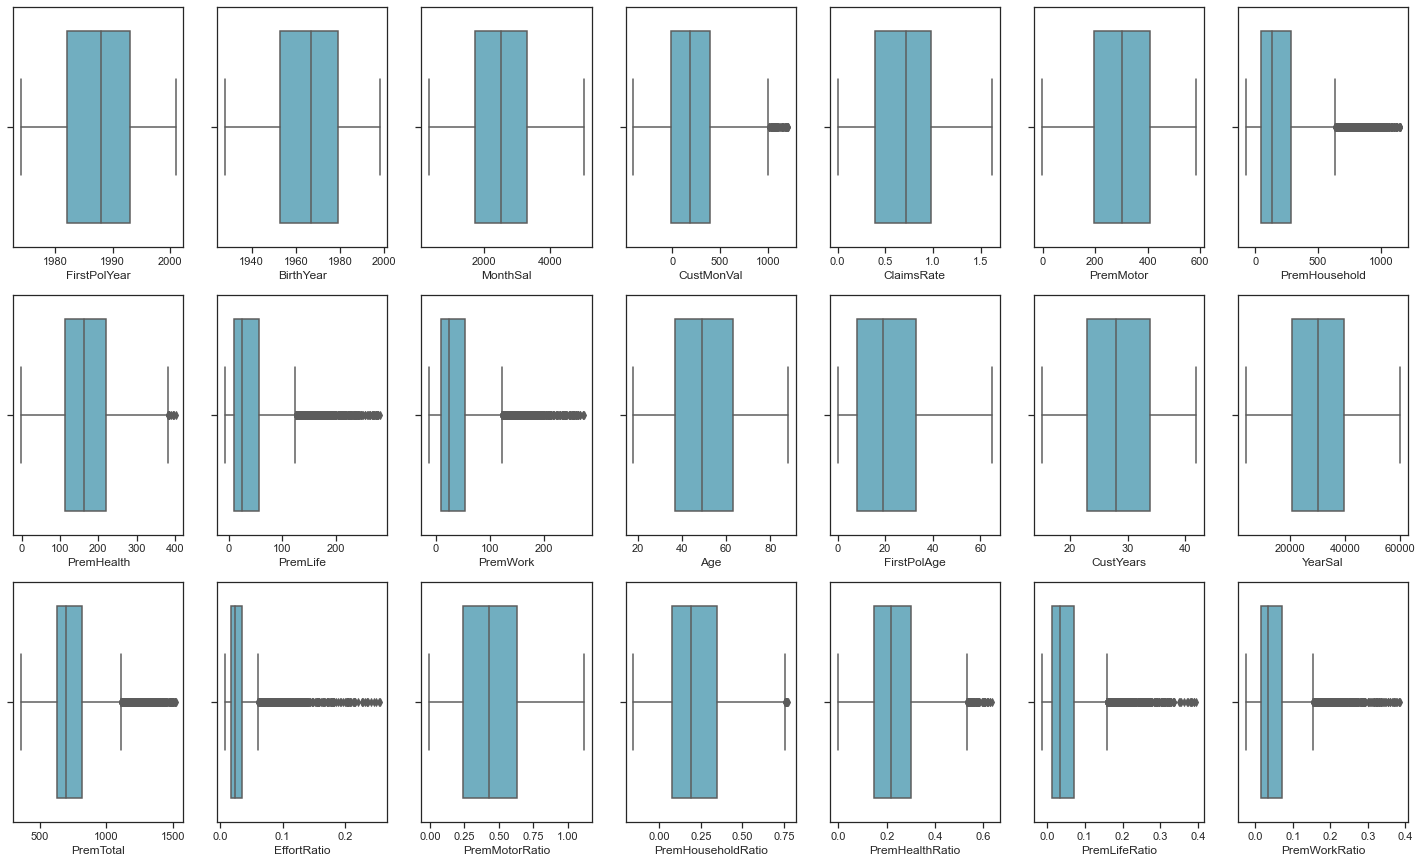

In [41]:
# boxplot of metric features after removing outliers
plot_multiple(df, metric_features, "box", [25, 15], 3)

<a class="anchor" id="preprocessing-feature-selection"></a>

<h3><right>2.5. Feature selection</right></h3>

* Remove redundant features
* Remove irrelevant features
* Prepare dataframe for cluster analysis

In [42]:
def corr_heatmap(df, corrlimit, method = "pearson"):

    '''
    Takes in a dataframe, df, and a coefficient, method,
    as arguments and creates a correlation heatmap showing
    the correlations between all pairs of features in the
    dataframe.
    '''

    sns.set(style = "ticks")
    plt.subplots(figsize = (20, 15))

    mask = np.triu(np.ones_like(df.corr(method = method), dtype = bool))
    correlationmatrix=df.corr(method = method)
    annot_labels = correlationmatrix
    annot_mask = abs(correlationmatrix) <corrlimit
    annot_labels=round(annot_labels,2).astype(str)
    annot_labels[annot_mask] ='' 
    corr_heatmap = sns.heatmap(correlationmatrix, mask = mask, vmin = -1, vmax = 1, annot = annot_labels, cmap = 'BrBG',fmt='')
    corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict = {'fontsize': 14}, pad = 8)

    return

In [43]:
def restructure_df(df):
    
    # reorganise column order
    df = df.loc[:, [
        "Generation",
        "Age",
        "YearSal",
        "EducDeg",
        "Children",
        "FirstPolAge",
        "CustYears",
        "CustMonVal",
        "ClaimsRate",
        "PremMotor",
        "PremMotorRatio",
        "PremHousehold",
        "PremHouseholdRatio",
        "PremHealth",
        "PremHealthRatio",
        "PremLife",
        "PremLifeRatio",
        "PremWork",
        "PremWorkRatio",
        "PremTotal",
        "EffortRatio"
        ]
    ]
    
    # rename a few columns
    df = df.rename(columns = {
        "CustMonVal": "CMV",
        "PremMotor": "Motor",
        "PremMotorRatio": "MotorRatio",
        "PremHousehold": "House",
        "PremHouseholdRatio": "HouseRatio",
        "PremHealth": "Health",
        "PremHealthRatio": "HealthRatio",
        "PremLife": "Life",
        "PremLifeRatio": "LifeRatio",
        "PremWork": "Work",
        "PremWorkRatio": "WorkRatio"
        }
    )
    
    return df

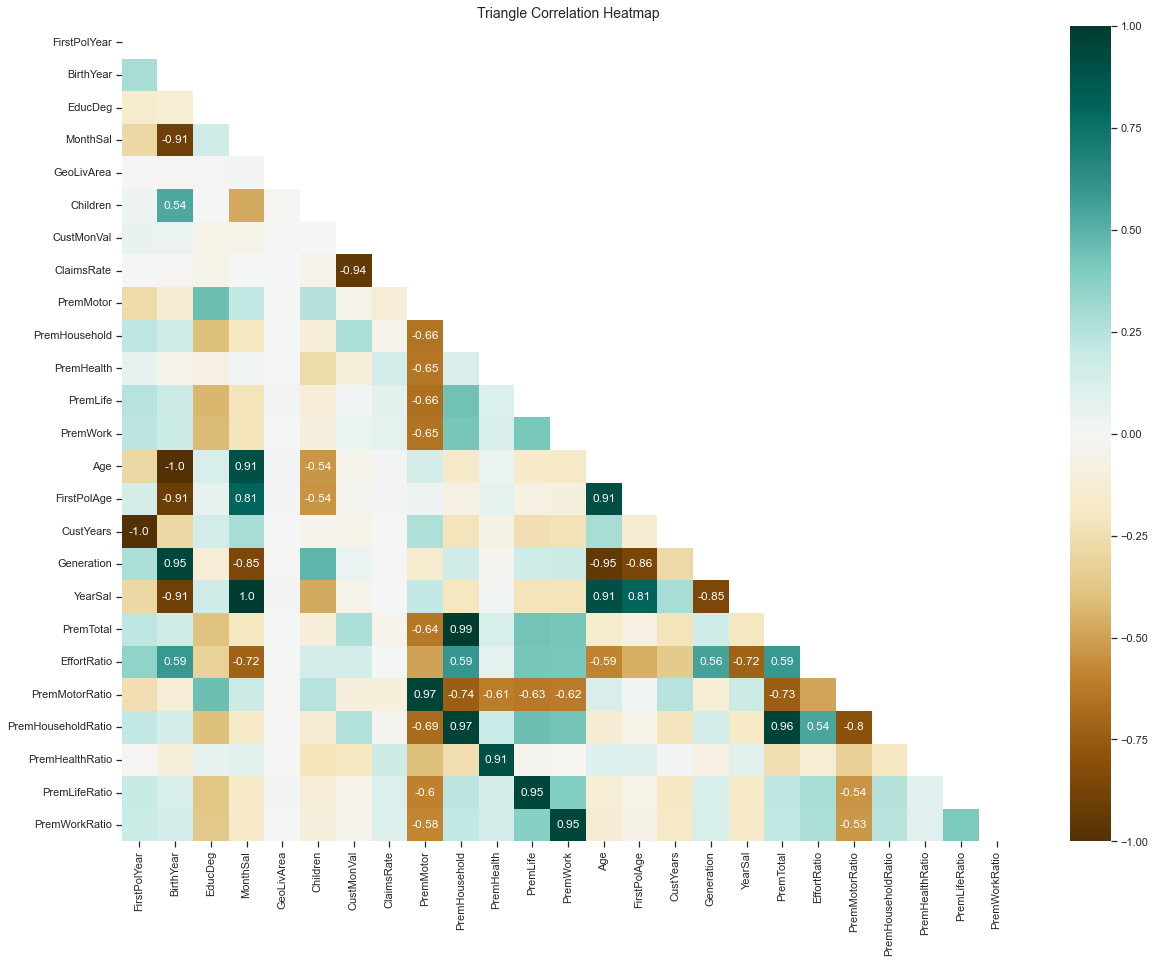

In [44]:
# correlation heatmap of features in the dataframe
# show value only for correlations higher than 0.4 or lower than -0.4
corr_heatmap(df, 0.5)

In [45]:
# remove percetly redundant features from main dataframe
df.drop(columns = ["FirstPolYear", "BirthYear", "MonthSal"], inplace = True)

# TO BE DECIDED (based on future clustering) !!!!!!!!!!!!!!
# Age vs FirstPolAge vs Generation vs YearSal
# ClaimsRate vs CustMonVal
# PremTotal vs PremHousehold
# PremTotal vs PremHousehold_ratio
# Prem ratios vs Prem values

Metric features: ['CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'Age', 'FirstPolAge', 'CustYears', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']
Non-metric features: ['EducDeg', 'GeoLivArea', 'Children', 'Generation']


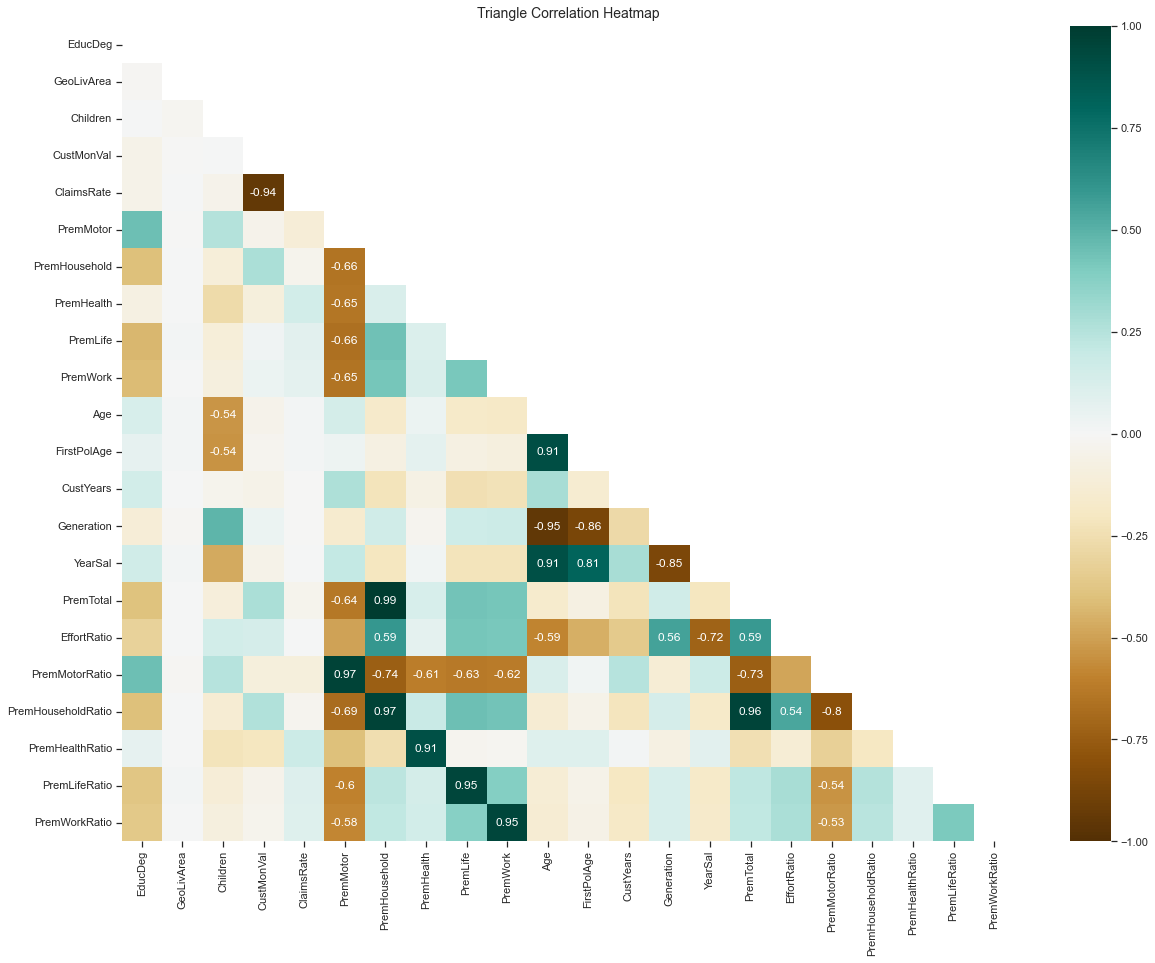

In [46]:
# correlation heatmap after updating features
corr_heatmap(df, 0.5)

# update metric and non-metric features
metric_features = list(df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"]))
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

print("Metric features:", metric_features)
print("Non-metric features:", non_metric_features)

In [ ]:
# pairplot of current (metric) features
sns.pairplot(df[metric_features]);

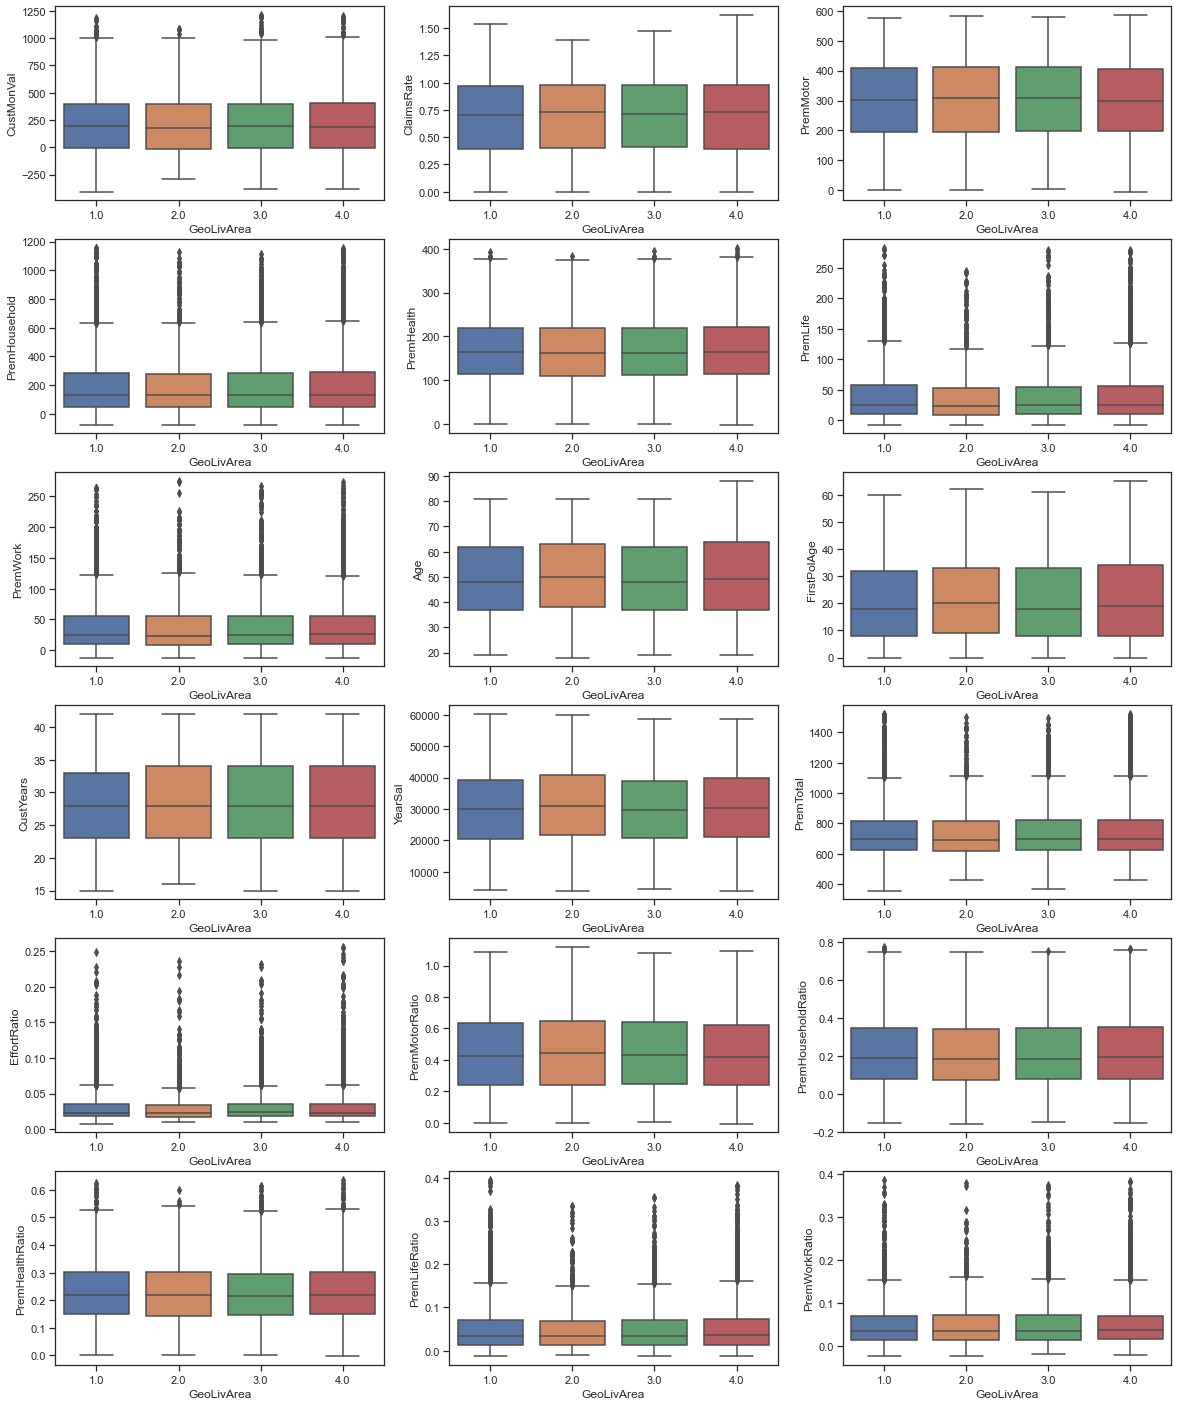

In [ ]:
# Correlation heatmap hinted at GeoLivArea having no meaningful correlation with any of the features
# visual representation of GeoLivArea and its relation with other features
sns.set(style = "ticks")

fig, axes = plt.subplots(6, 3, figsize=(20, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x = df["GeoLivArea"], y = df[feat], ax = ax)
    
plt.show()

# confirms that GeoLivArea appears to have no discriminative power

In [48]:
# remove GeoLivArea from the main dataframe
df.drop(columns = "GeoLivArea", inplace = True)

# remove GeoLivArea from df_outliers
df_outliers.drop(columns = "GeoLivArea", inplace = True)

In [49]:
# restructure and visualize the main dataframe before cluster analysis
df = restructure_df(df)
df.head()

Generation   Age  YearSal  EducDeg  Children  FirstPolAge  CustYears  \
CustID                                                                         
1              4.0  34.0  26124.0      2.0       1.0          3.0       31.0   
2              4.0  35.0   8124.0      2.0       1.0         14.0       21.0   
3              3.0  46.0  27324.0      1.0       0.0         21.0       25.0   
4              4.0  35.0  13188.0      3.0       1.0          9.0       26.0   
5              3.0  43.0  21156.0      3.0       1.0         13.0       30.0   

           CMV  ClaimsRate   Motor  ...   House  HouseRatio  Health  \
CustID                              ...                               
1       380.97        0.39  375.85  ...   79.45    0.119373  146.36   
2      -131.13        1.12   77.46  ...  416.20    0.456881  116.69   
3       504.67        0.28  206.15  ...  224.50    0.303133  124.58   
4       -16.99        0.99  182.48  ...   43.35    0.072168  311.17   
5        35.23        0.90  338.62  ...   47.80    0.075965  182.59   

        HealthRatio    Life  LifeRatio    Work  WorkRatio  PremTotal  \
CustID                                                                 
1          0.219905   47.01   0.070632   16.89   0.025377     665.56   
2          0.128096  194.48   0.213489  106.13   0.116503     910.96   
3          0.168215   86.35   0.116595   99.02   0.133702     740.60   
4          0.518030   35.34   0.058833   28.34   0.047180     600.68   
5          0.290175   18.78   0.029846   41.45   0.065873     629.24   

        EffortRatio  
CustID               
1          0.025477  
2          0.112132  
3          0.027104  
4          0.045547  
5          0.029743  

[5 rows x 21 columns]

In [50]:
# restructure and visualize the outliers dataframe before cluster analysis
df_outliers = restructure_df(df_outliers)
df_outliers.head()

Generation   Age   YearSal  EducDeg  Children  FirstPolAge  CustYears  \
CustID                                                                          
9295           2.0  68.0   39216.0      3.0       0.0      51836.0   -51768.0   
5883           2.0  60.0  662580.0      2.0       1.0         39.0       21.0   
8262           4.0  35.0  413880.0      2.0       0.0         10.0       25.0   
52             3.0  50.0   38808.0      3.0       1.0         16.0       34.0   
113            3.0  37.0   28248.0      4.0       1.0         18.0       19.0   

             CMV  ClaimsRate   Motor  ...   House  HouseRatio  Health  \
CustID                                ...                               
9295      348.85        0.37  351.40  ...   15.00    0.025253  187.37   
5883      122.25        0.79  281.83  ...  147.25    0.207161  130.58   
8262      608.89        0.28   57.01  ...  358.95    0.405062  195.26   
52     -14714.08       25.36  557.44  ...   20.00    0.033167   29.56   
113     -8719.04       15.65  518.32  ...    4.45    0.007499   55.90   

        HealthRatio    Life  LifeRatio    Work  WorkRatio  PremTotal  \
CustID                                                                 
9295       0.315438   22.45   0.037795   17.78   0.029933     594.00   
5883       0.183708   84.46   0.118824   66.68   0.093810     710.80   
8262       0.220344  113.80   0.128419  161.14   0.181841     886.16   
52         0.049022    5.00   0.008292   -9.00  -0.014925     603.00   
113        0.094195    3.89   0.006555   10.89   0.018350     593.45   

        EffortRatio  
CustID               
9295       0.015147  
5883       0.001073  
8262       0.002141  
52         0.015538  
113        0.021009  

[5 rows x 21 columns]

In [51]:
# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "Children", "Generation"])
non_metric_features = ["EducDeg", "Children", "Generation"]

# compute total number of observations removed
nr_rows_removed = initial_len - len(df)
pc_rows_removed = round((nr_rows_removed / initial_len) * 100, 2)

print(
    f"Total number of observations removed: {nr_rows_removed} ({pc_rows_removed}%)\n"
    f"Final number of observations: {df.shape[0]} ({100 - pc_rows_removed}%)\n"
    f"Current number of features: {df.shape[1]}\n"
    "Features:",
    list(df.columns)
)

Total number of observations removed: 242 (2.35%)
Final number of observations: 10051 (97.65%)
Current number of features: 21
Features: ['Generation', 'Age', 'YearSal', 'EducDeg', 'Children', 'FirstPolAge', 'CustYears', 'CMV', 'ClaimsRate', 'Motor', 'MotorRatio', 'House', 'HouseRatio', 'Health', 'HealthRatio', 'Life', 'LifeRatio', 'Work', 'WorkRatio', 'PremTotal', 'EffortRatio']


<a class="anchor" id="preprocessing-scaling"></a>

<h3><right>2.6. Feature skewness</right></h3>

In [52]:
def transform_skewed_features(df, features, transformation):

    # create dataframe with the transformed features
    df_transformed = df.copy()

    for feat in features:
        # ensure all values are non-negative and apply square root transformation
        if transformation.lower() == "sqrt":
            df_transformed[feat] = np.sqrt(df_transformed[feat] + abs(df_transformed[feat].min()))

        # ensure all values are positive and apply log10 transformation
        if transformation.lower() == "log10":
            df_transformed[feat] = np.log10(df_transformed[feat] + abs(df_transformed[feat].min()) + 1)

    return df_transformed

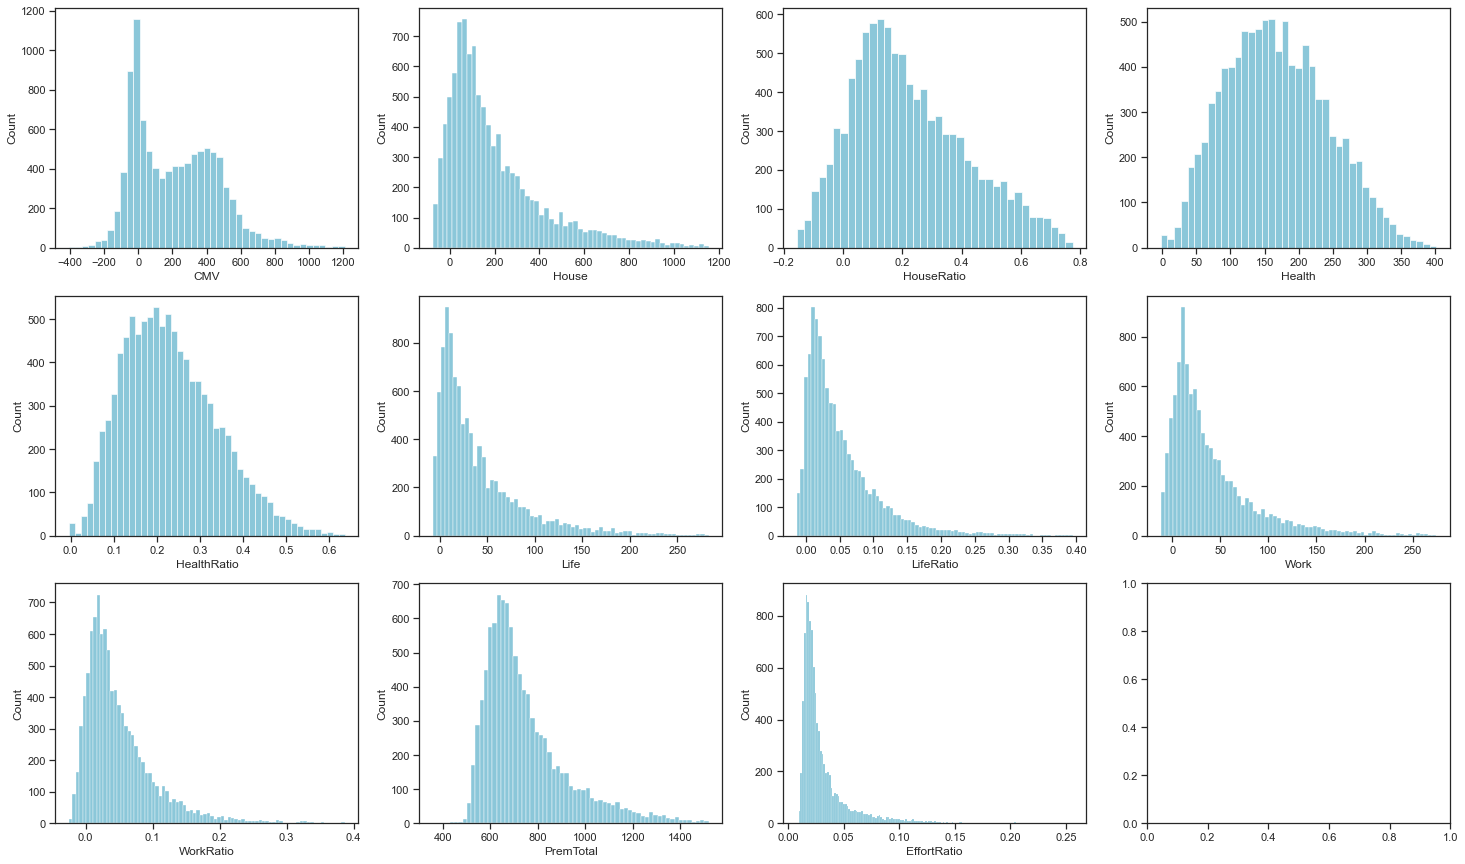

In [53]:
features = [
    "CMV",
    "House",
    "HouseRatio",
    "Health",
    "HealthRatio",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# plot histogram of the potentially skewed metric features
plot_multiple(df, features, "histogram", [25, 15], nr_rows = 3)

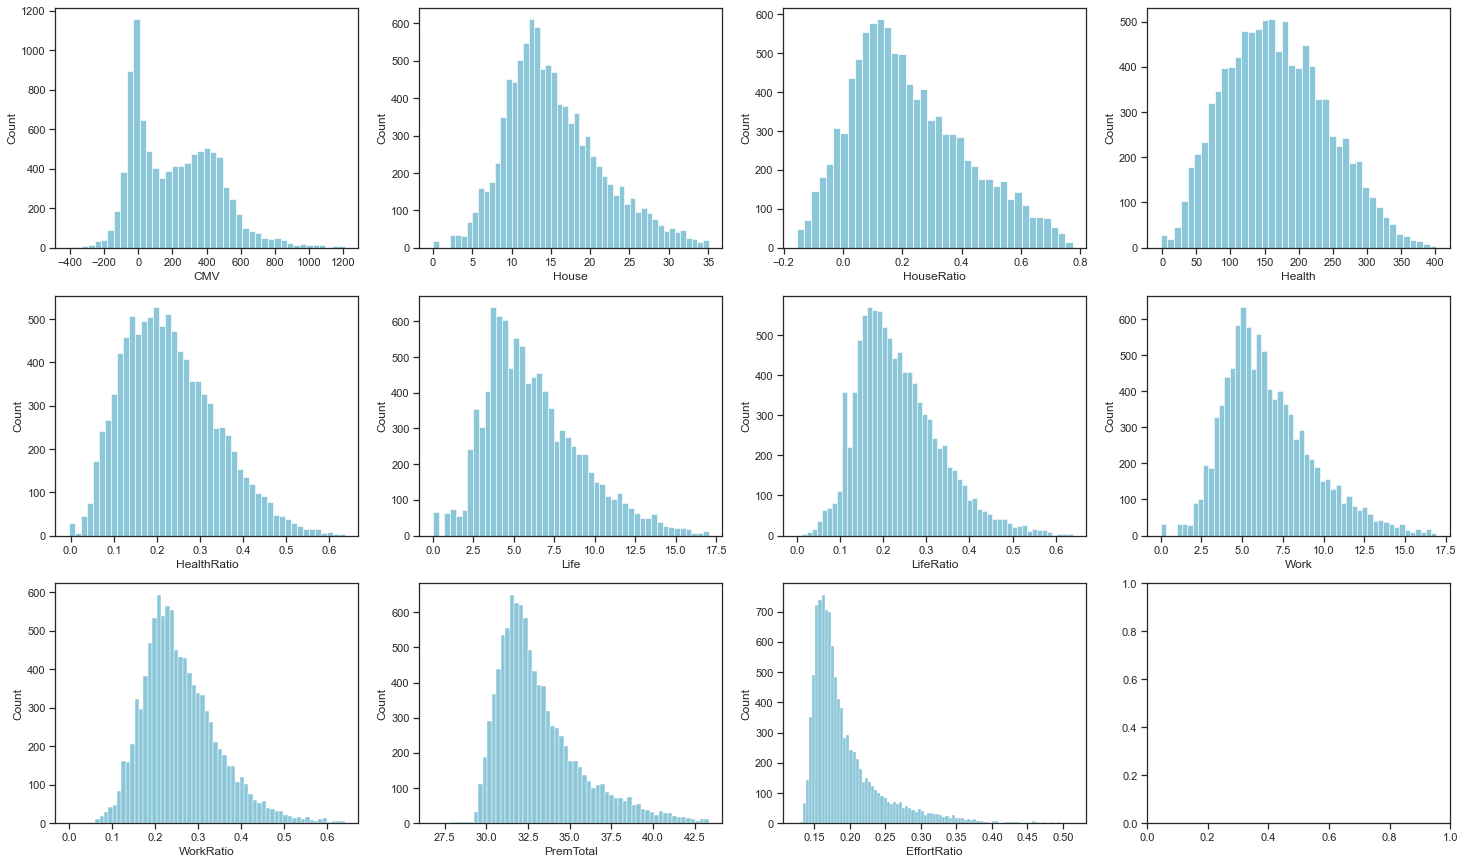

In [54]:
# list of skewed metric features
skewed_features = [
    "House",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# apply transformation to the skewed features  (could maybe apply log10 to PremTotal alone???????????????????????)
# save transformed features (and the others) in a copy of the original dataframe to preserve original values
df_transformed = transform_skewed_features(df, skewed_features, transformation = "sqrt")

# plot histogram of transformed features
plot_multiple(df_transformed, features, "histogram", [25, 15], nr_rows = 3)

In [55]:
# At this point there are 3 important dataframes
#  df             - original, not transformed values (no square root transformation of skewed features)
#  df_transformed - identical to df except that square root transformation was applied to skewed metric features
#  df_outliers    - all of the outliers removed from df

<a class="anchor" id="data-clustering"></a>

***

<h2><center>3. CLUSTERING</center></h2>

***

In [56]:
def data_scaler(df, scaler_name):

    '''
    Takes in a dataframe, df, and the name of the scaler,
    scaler_name, as arguments and applies the corresponding
    scaling method to the dataframe.

    Arguments:
     df (dataframe): dataframe without the target, y
     scaler_name (str): name of the scaler (minmax,
    standard, robust)

    Returns:
     df_scaled (dataframe): scaled version of the original df
    '''

    df_scaled = df.copy()
    features = list(df.columns)

    if scaler_name.lower() == "minmax":
        scaler = MinMaxScaler().fit(df)
        df_scaled[features] = scaler.transform(df)

    if scaler_name.lower() == "standard":
        scaler = StandardScaler().fit(df)
        df_scaled[features] = scaler.transform(df)

    if scaler_name.lower() == "robust":
        scaler = RobustScaler().fit(df)
        df_scaled[features] = scaler.transform(df)
    
    return (scaler, df_scaled)

In [57]:
def kmeans_clustering(df, k):

    '''
    Takes in a dataframe, df, and a number of clusters, k,
    and assigns rows of the dataframe to clusters based on
    the KMeans algorithm.

    Arguments:
     df (dataframe): dataframe
     k (int): number of clusters

    Returns:
     centroids (ndarray): center of each cluster
     labels (ndarray): label of each row indicating the
    cluster it was assigned to
    '''
    
    clusters = KMeans(
        n_clusters = k,
        random_state = 15
    ).fit(df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_

    return (centroids, labels)

In [58]:
def kprototypes_clustering(df, k, cat_index, init = "Huang"):

    clusters = KPrototypes(
        n_clusters = k,
        init = init,
        random_state = 15
    ).fit(df, categorical = cat_index)
    labels = clusters.labels_
    centroids = clusters.cluster_centroids_

    return (centroids, labels)

In [59]:
def hierarchical_clustering(df, n_clusters = None, threshold = 10000, affinity = "euclidean", linkage = "ward"):
    
    # determine clusters
    clusters = AgglomerativeClustering(
        n_clusters = n_clusters,
        affinity = affinity,
        linkage = linkage,
        distance_threshold = threshold
    ).fit(df)
    
    # retrieve cluster labels and distances
    labels = clusters.labels_
    distances = clusters.distances_
    
    counts = np.zeros(clusters.children_.shape[0])
    n_samples = len(labels)
    
    for i, merge in enumerate(clusters.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([clusters.children_, distances, counts]).astype(float)
    
    return (distances, labels, linkage_matrix)

In [60]:
def db_scan(df, k):
    for eps in range(1,8):
        for min_samples in range(1,10):
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
            print(set(clustering.labels_))
            if len(set(clustering.labels_))==k+1:
                return (None, clustering.labels_)
            if len(set(clustering.labels_))==2 or len(set(clustering.labels_))==1:
                return None
    return (None)


In [61]:
def plot_elbow(df, nmax_clusters, algorithm, cat_index = None, init = "Huang"):
    
    # store inertia values in a list
    y_vals = []
    
    # determine inertia for each number of clusters
    for n in np.arange(2, nmax_clusters + 1):
        if algorithm.lower() == "kmeans":
            km_clusters = KMeans(n_clusters = n, random_state = 15).fit(df)
            inertia = km_clusters.inertia_
            y_vals.append(inertia)

        if algorithm.lower() == "kprototypes":
            if type(cat_index) is int:
                cat_index = [cat_index]
            kp_clusters = KPrototypes(
                n_clusters = n,
                init = init,
                random_state = 15
            ).fit(df, categorical = cat_index)
            cost = kp_clusters.cost_
            y_vals.append(cost)
    
    # plot elbow graph
    sns.set_style("ticks")
    plt.subplots(figsize = (8, 6))
    sns.lineplot(x = np.arange(2, nmax_clusters + 1),
        y = y_vals,
        color = "k",
        marker = 'o',
        mew = 0,
        linewidth = 3)
    plt.title("Elbow plot", fontsize = 22)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim([0, nmax_clusters+1])
    plt.xlabel("Number of clusters, k", fontsize = 18)

    if algorithm.lower() == "kmeans":
        plt.ylabel("Inertia", fontsize = 18)
    elif algorithm.lower() == "kprototypes":
        plt.ylabel("Cost", fontsize = 18)

    return

In [62]:
# Adapted from the following link and DM practical class:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

def plot_silhouette(df, nmax_clusters):

    # Storing average silhouette metric
    avg_silhouette = []
    for nclus in np.arange(1, nmax_clusters + 1):
        # Skip nclus == 1
        if nclus == 1:
            continue
        
        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = metrics.silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        
        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
        
        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(df) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

    return

In [63]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

    return

In [64]:
#takes in the results from one of the clustering algorithms and the data and presents the means
def summarise_clustering(df, labels, sort_by = None):

    df_temp = df.copy()
    df_temp["Cluster"] = labels

    # number of observations per cluster
    cluster_obs_num = pd.Series(df_temp.groupby("Cluster").size(), name = "obs")
    cluster_obs_pc = pd.Series(round(cluster_obs_num / df_temp.shape[0] * 100, 1), name = "%")
    cluster_size = pd.concat([cluster_obs_num, cluster_obs_pc], axis = 1)

    print("Cluster sizes:\n", cluster_size)

    # mean value of features for each cluster
    if sort_by == None:
        return df_temp.groupby("Cluster").mean()
    else:
        return df_temp.groupby("Cluster").mean().sort_values(sort_by)

In [65]:
def evaluate_clustering(df, labels):

    # remove points regarded as outliers
    df["Label"] = labels
    df_nonoise = df.loc[df["Label"] != -1]
    # update labels after removing outliers
    labels = df_nonoise["Label"]
    # drop Label column
    df_nonoise.drop(columns = "Label", inplace = True)

    # cluster metrics
    silhouette = metrics.silhouette_score(df_nonoise, labels, random_state = 15)
    dbs = metrics.davies_bouldin_score(df_nonoise, labels)
    chs = metrics.calinski_harabasz_score(df_nonoise, labels)

    print(
        f"Silhouette score: {round(silhouette, 2)}\n"
        f"Davies-Bouldin score: {round(dbs, 2)}\n"
        f"Calinski-Harabasz score: {round(chs, 2)}"
    )

    return

In [66]:
def visualize_clustering(df, labels, metric_features, categorical_features = None):

    temp_df = df.copy()
    temp_df["Label"] = labels

    for label in set(temp_df.Label):
        label_df = temp_df[temp_df.Label == label]

        fig, axes = plt.subplots(1, len(metric_features), figsize = [15, 4])

        for ax, feat in zip(axes.flatten(), metric_features):
            sns.histplot(
                data = label_df,
                x = feat,
                hue = "Label",
                alpha = 1,
                bins = 20,
                ax = ax
            )

            ax.set_xlim([temp_df[feat].min()*0.9, temp_df[feat].max()*1.1])

    return

<a class="anchor" id="clustering-sociodemographic"></a>

<h3><right>3.1. Sociodemographic clustering</right></h3>

In [67]:
# dataframe with sociodemographic features - Generation, Age, YearSal, EducDeg, Children
# Age highly correlated with Generation and YearSal - using either produced very identical clusters with tested approaches, decided to use Age
df_sociodem = df[["Generation", "Age", "YearSal", "EducDeg", "Children"]]

#### 3.1.1. KMeans (Age, EducDeg)

KeyboardInterrupt: 

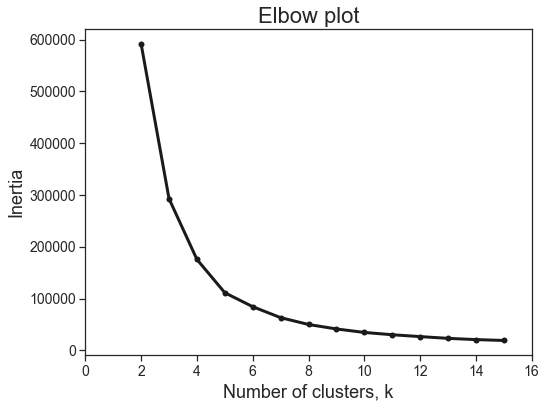

In [68]:
# scaling dataframe
km_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, km_sociodem_minmax = data_scaler(km_sociodem, "minmax")
standard_scaler, km_sociodem_standard = data_scaler(km_sociodem, "standard")

# # choose number of clusters
plot_elbow(km_sociodem, 15, "kmeans") 
# plot_silhouette(km_sociodem, 15)

# get cluster centroids and labels
km_sociodem_centroids, km_sociodem_labels = kmeans_clustering(km_sociodem_minmax, 5)

# cluster overview
df["Label"] = km_sociodem_labels
evaluate_clustering(km_sociodem_minmax, df.Label)
summarise_clustering(km_sociodem, df.Label, "Age")

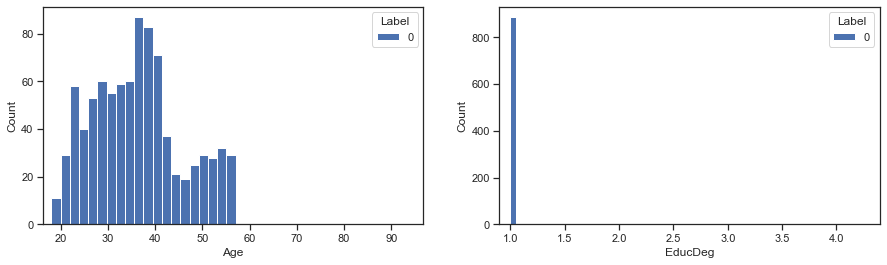

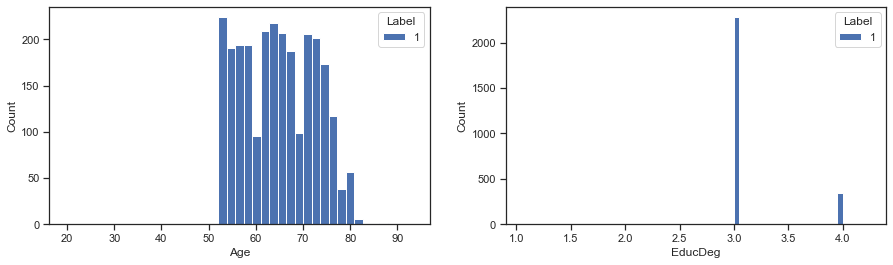

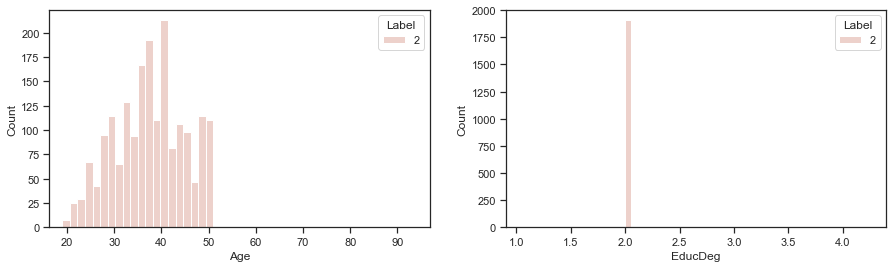

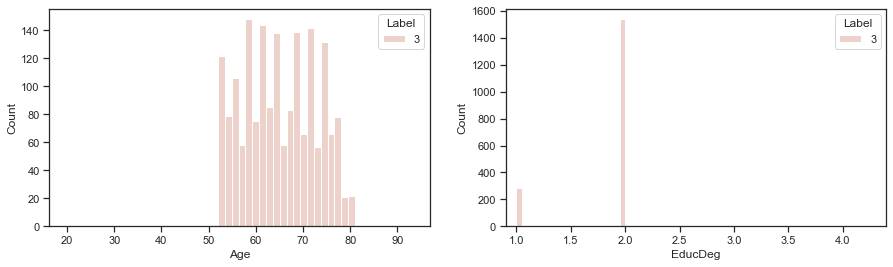

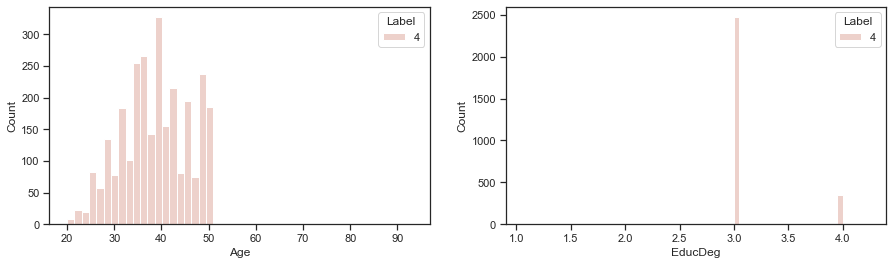

In [ ]:
visualize_clustering(km_sociodem, df.Label, ["Age", "EducDeg"])

#### 3.1.2. KMeans + Hierarchical (Age, EducDeg)

Silhouette score: 0.47
Davies-Bouldin score: 0.81
Calinski-Harabasz score: 9595.89
Cluster sizes:
           obs     %
Cluster            
0        2923  29.1
1        2472  24.6
2        1690  16.8
3        2966  29.5


Age   EducDeg
Cluster                     
1        37.483414  3.176780
0        37.918577  1.757783
3        62.526972  3.084963
2        65.608876  1.728402

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 n

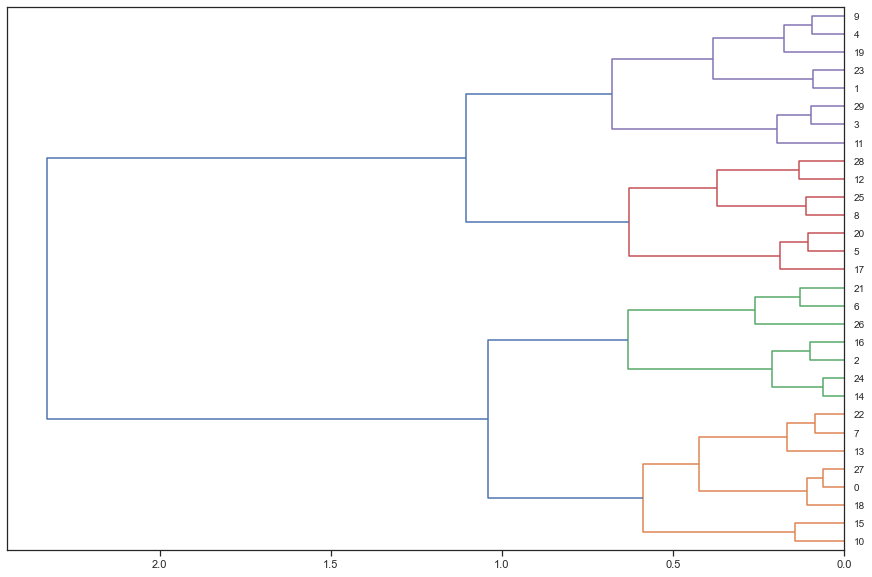

In [ ]:
# scale data
km_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, km_sociodem_minmax = data_scaler(km_sociodem, "minmax")
standard_scaler, km_sociodem_standard = data_scaler(km_sociodem, "standard")

# get cluster centroids and labels
km_sociodem_centroids, km_sociodem_labels = kmeans_clustering(km_sociodem_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_sociodem_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_sociodem_linkage = hierarchy.linkage(km_sociodem_centroids, method = "ward")
hierarchy.dendrogram(
    km_sociodem_linkage,
    orientation = "left",
    color_threshold = 1.0
)

# hierarchical clustering of the centroids obtained
hc_sociodem_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_sociodem_centroids)
hc_sociodem_labels = pd.Series(hc_sociodem_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_sociodem_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_sociodem_centroids), columns = ["Age", "EducDeg"])
km_sociodem_centroids = pd.concat([km_sociodem_centroids, hc_sociodem_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_sociodem_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_sociodem_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_sociodem_minmax, df.Label)
summarise_clustering(km_sociodem, df.Label, "Age")

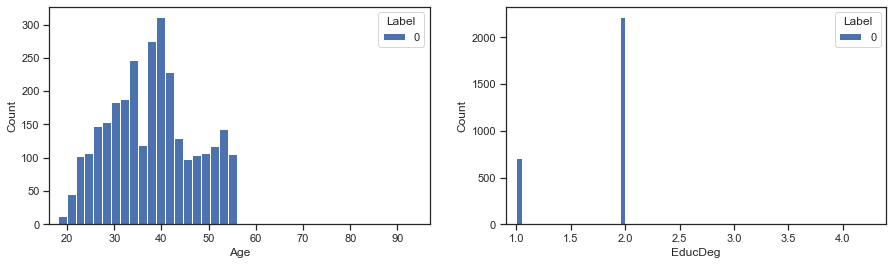

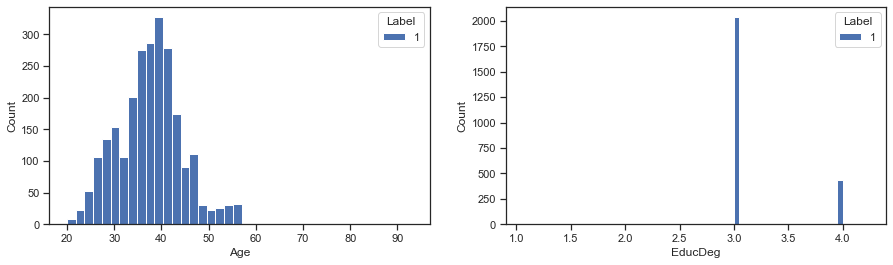

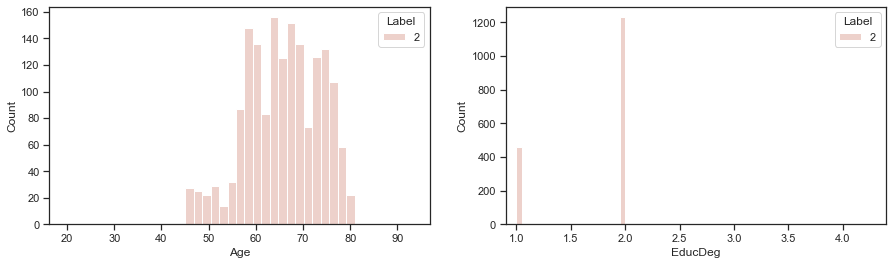

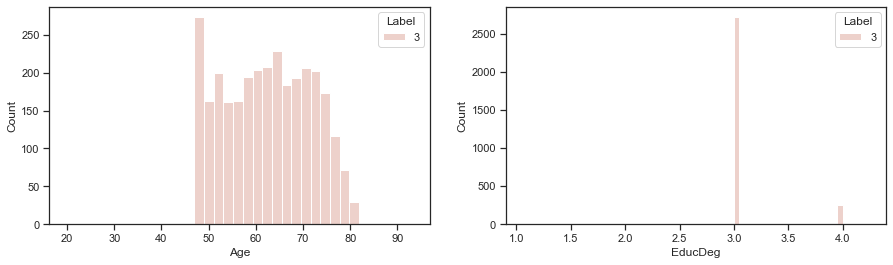

In [ ]:
visualize_clustering(km_sociodem, df.Label, ["Age", "EducDeg"])

#### 3.1.3. Hierarchical (Age, EducDeg)

Silhouette score: 0.45
Davies-Bouldin score: 0.76
Calinski-Harabasz score: 8960.49
Cluster sizes:
           obs     %
Cluster            
0        3773  37.5
1        2608  25.9
2        2005  19.9
3        1665  16.6


Age   EducDeg
Cluster                     
1        35.904908  1.708589
0        43.695468  3.182613
2        63.877805  1.797007
3        68.018619  3.000000

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 no

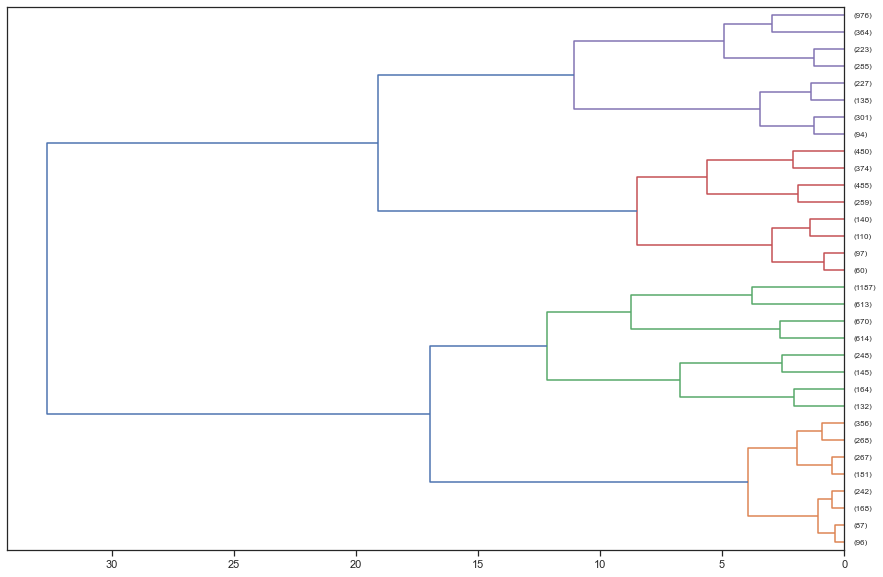

In [ ]:
# scale data
hc_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, hc_sociodem_minmax = data_scaler(hc_sociodem, "minmax")
standard_scaler, hc_sociodem_standard = data_scaler(hc_sociodem, "standard")

# visualize dendrogram
hc_sociodem_distances, hc_sociodem_labels, hc_sociodem_linkage = hierarchical_clustering(
    hc_sociodem_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_sociodem_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 15
)

# perform AgglomerativeClustering
hc_sociodem_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(hc_sociodem_minmax)
hc_sociodem_labels = hc_sociodem_clusters.labels_

# overview of the clusters
df["Label"] = hc_sociodem_labels
evaluate_clustering(hc_sociodem_minmax, df.Label)
summarise_clustering(hc_sociodem, df.Label, "Age")

#### 3.1.4. DBSCAN (Age, EducDeg)

In [ ]:
# scale data
db_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, db_sociodem_minmax = data_scaler(db_sociodem, "minmax")
standard_scaler, db_sociodem_standard = data_scaler(db_sociodem, "standard")

# # find possible values for eps
# for eps in np.arange(0.05, 0.41, 0.05):
#     db_sociodem_clusters = DBSCAN(eps = eps).fit(db_sociodem_minmax)
#     print(f"Clusters with eps = {round(eps, 2)}: {set(db_sociodem_clusters.labels_)}")

# get clusters and labels based on selected eps
db_sociodem_clusters = DBSCAN(eps = 0.20).fit(db_sociodem_minmax)
db_sociodem_labels = db_sociodem_clusters.labels_

# overview of the cluster
df["Label"] = db_sociodem_labels
evaluate_clustering(db_sociodem_minmax, df.Label)
summarise_clustering(db_sociodem, df.Label, "Age")

Silhouette score: 0.43
Davies-Bouldin score: 1.13
Calinski-Harabasz score: 4931.56
Cluster sizes:
           obs     %
Cluster            
0        3446  34.3
1        1167  11.6
2        4749  47.2
3         689   6.9


Age  EducDeg
Cluster                    
1        43.780634      1.0
0        49.513349      2.0
2        51.039587      3.0
3        51.853411      4.0

#### 3.1.5. KPrototypes (Age, EducDeg, Children)

In [69]:
# kprototypes: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf

# scale data
kp_sociodem = df_sociodem[["Age", "EducDeg", "Children"]]
minmax_scaler, kp_sociodem_minmax = data_scaler(kp_sociodem, "minmax")
standard_scaler, kp_sociodem_standard = data_scaler(kp_sociodem, "standard")

# # elbow plot
# # suggests 4-8 clusters
# plot_elbow(kp_sociodem_minmax, nmax_clusters = 15, algorithm = "kprototypes", cat_index = 2)

# compute centroids and labels with k = 4
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 4, cat_index = 2, init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(kp_sociodem, df.Label, sort_by = "Age")

Silhouette score: 0.42
Davies-Bouldin score: 1.03
Calinski-Harabasz score: 7411.04
Cluster sizes:
           obs     %
Cluster            
0        3458  34.4
1        3931  39.1
2        1155  11.5
3        1507  15.0


Age   EducDeg  Children
Cluster                               
0        41.175535  1.727588  0.911799
1        44.408547  3.125413  0.955482
2        68.683983  1.805195  0.092641
3        68.708693  3.130060  0.064366

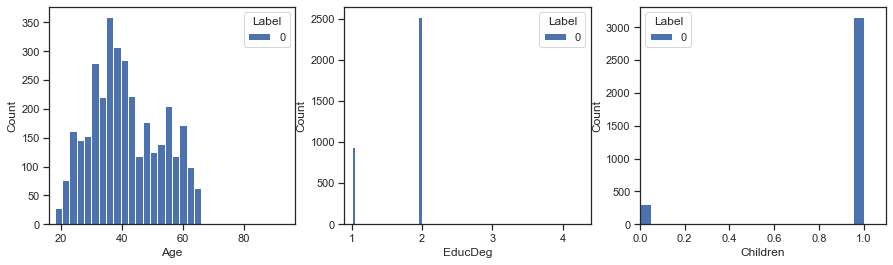

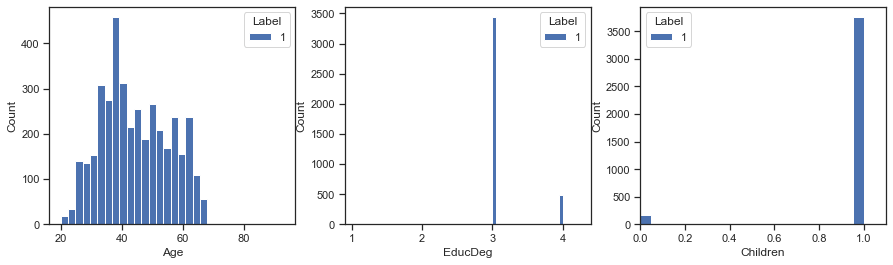

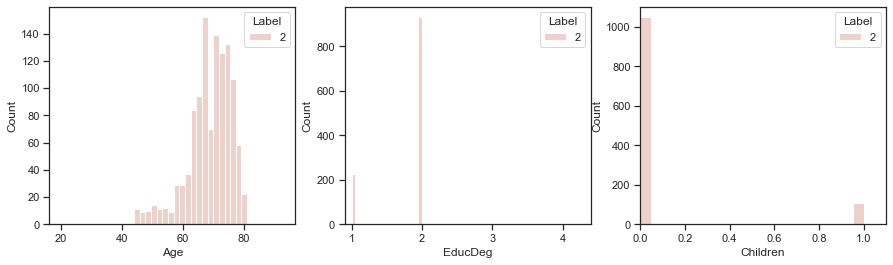

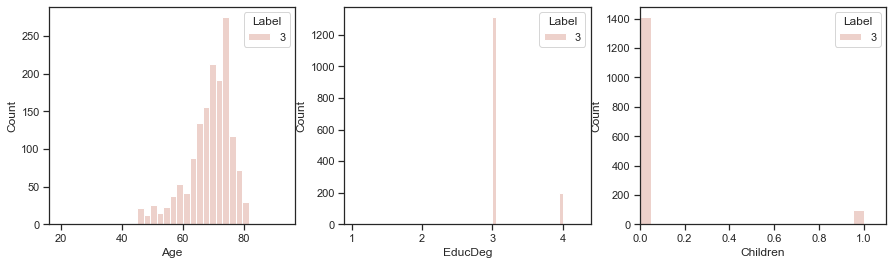

In [70]:
visualize_clustering(kp_sociodem, df.Label, ["Age", "EducDeg", "Children"])

In [71]:
# compute centroids and labels with k = 6
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 6, cat_index = 2, init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(df, df.Label, sort_by = "Age")

KeyboardInterrupt: 

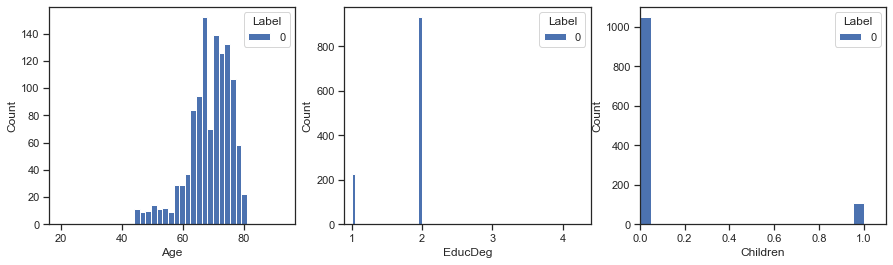

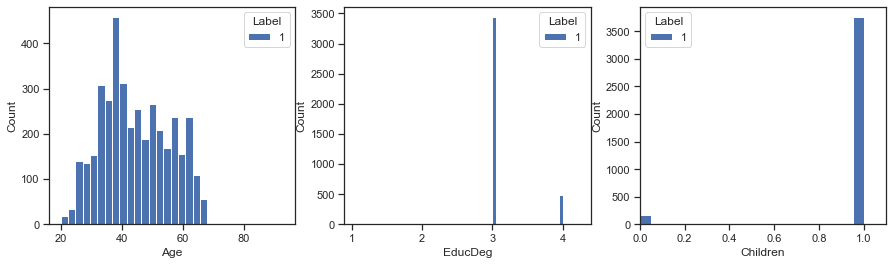

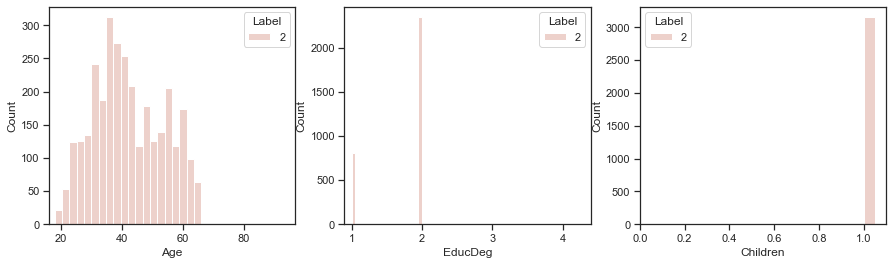

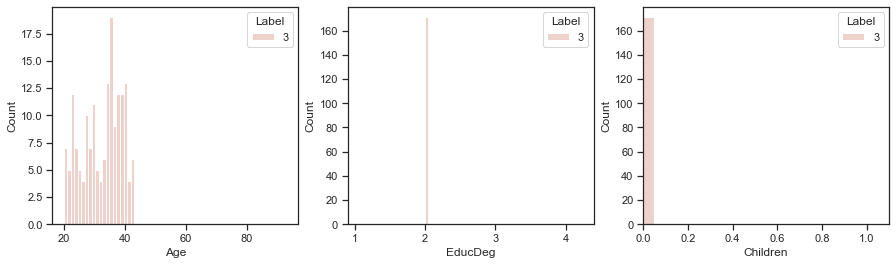

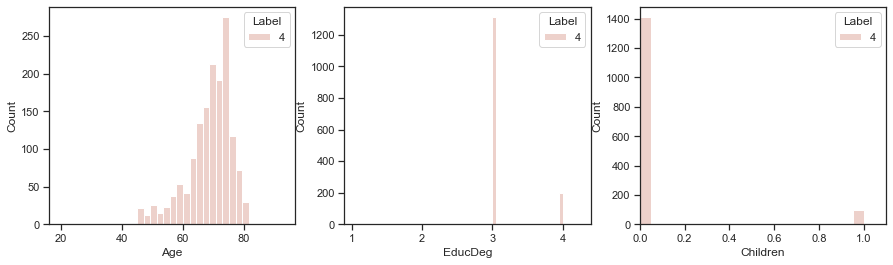

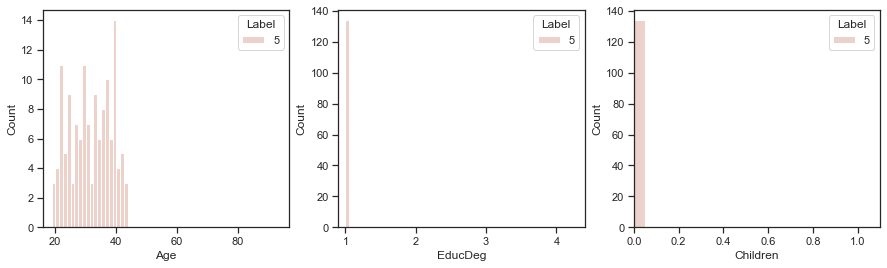

In [ ]:
visualize_clustering(kp_sociodem, df.Label, ["Age", "EducDeg", "Children"])

In [ ]:
# compute centroids and labels with k = 8
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 8, cat_index = 2, init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(df, df.Label, sort_by = "Age")

Silhouette score: 0.4
Davies-Bouldin score: 0.93
Calinski-Harabasz score: 6609.7
Cluster sizes:
           obs     %
Cluster            
0         134   1.3
1        1871  18.6
2        2289  22.8
3        1155  11.5
4        1507  15.0
5         171   1.7
6        1642  16.3
7        1282  12.8


Generation        Age       YearSal   EducDeg  Children  FirstPolAge  \
Cluster                                                                         
0          3.641791  31.641791  13630.388060  1.000000  0.000000    10.477612   
5          3.619883  32.304094  15948.350877  2.000000  0.000000     9.105263   
1          3.537146  34.063602  18368.397890  1.676109  1.000000     8.517905   
2          3.411533  36.396680  21444.421951  3.118392  0.923547     8.373962   
7          2.378315  53.734789  33830.199515  1.842434  1.000000    23.649766   
6          2.286845  55.577345  34638.996328  3.135201  1.000000    25.498782   
3          1.589610  68.683983  43167.901990  1.805195  0.092641    39.009524   
4          1.584605  68.708693  43278.627746  3.130060  0.064366    38.912409   

         CustYears         CMV  ClaimsRate       Motor  ...  HouseRatio  \
Cluster                                                 ...               
0        21.164179  332.560672    0.664328   93.135224  ...    0.484358   
5        23.198830  240.150117    0.721345  140.294269  ...    0.406347   
1        25.545697  229.388503    0.707830  199.400625  ...    0.332171   
2        28.022717  209.829926    0.668087  331.622084  ...    0.170609   
7        30.085023  218.752824    0.670515  345.473081  ...    0.210485   
6        30.078563  218.715189    0.634214  419.554513  ...    0.120060   
3        29.674459  212.408485    0.714874  221.863896  ...    0.305512   
4        29.796284  191.471161    0.695753  304.141148  ...    0.181349   

             Health  HealthRatio        Life  LifeRatio        Work  \
Cluster                                                               
0        156.057537     0.168333  117.396866   0.124330  116.697910   
5        187.144561     0.219687   96.100526   0.108777   82.532047   
1        186.657445     0.236552   68.457472   0.079900   67.550903   
2        172.541953     0.248758   27.349441   0.037286   27.549266   
7        133.820187     0.185595   36.708346   0.048569   36.356739   
6        113.771151     0.170019   17.810049   0.025682   18.569939   
3        201.604502     0.260716   55.804416   0.070272   52.516874   
4        198.957724     0.286890   28.718978   0.040018   27.351991   

         WorkRatio    PremTotal  EffortRatio  Label  
Cluster                                              
0         0.121081  1011.219254     0.087824    0.0  
5         0.094692   926.694795     0.067163    5.0  
1         0.078879   848.212117     0.056217    1.0  
2         0.037284   701.741271     0.037080    2.0  
7         0.048178   733.184680     0.022199    7.0  
6         0.026656   663.616736     0.019610    6.0  
3         0.066537   809.559732     0.019175    3.0  
4         0.038373   703.484970     0.016656    4.0  

[8 rows x 22 columns]

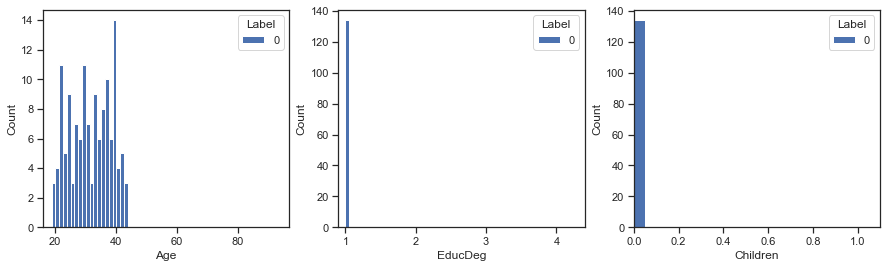

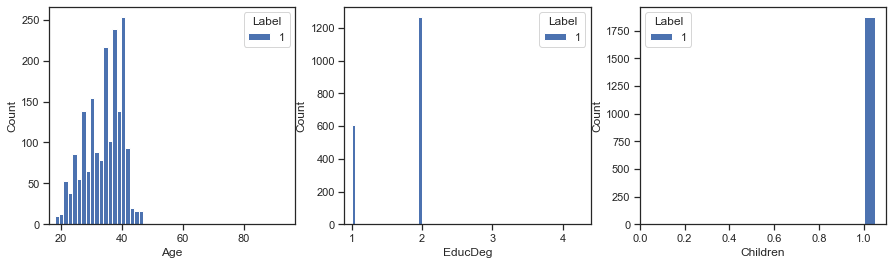

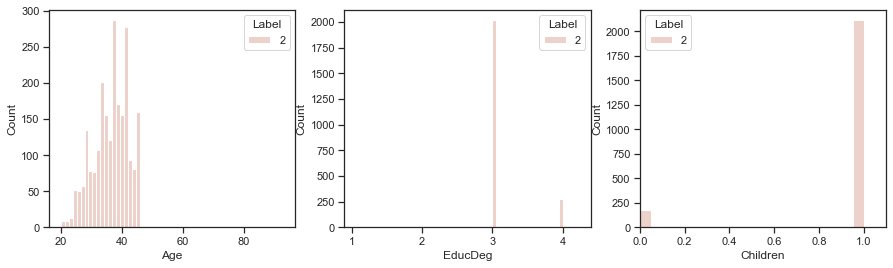

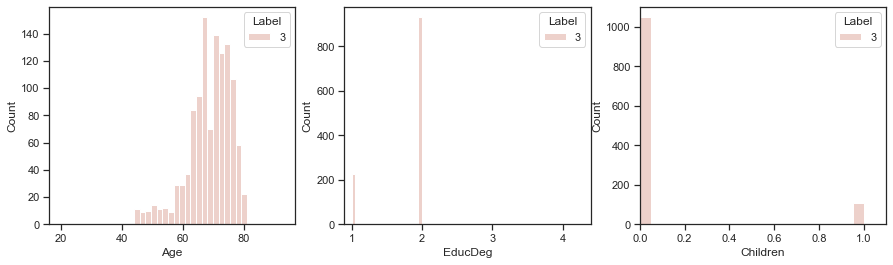

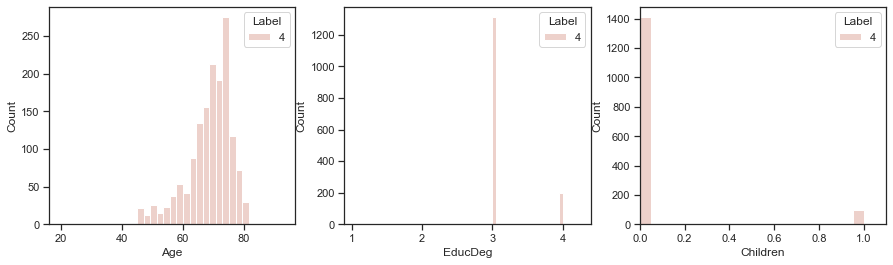

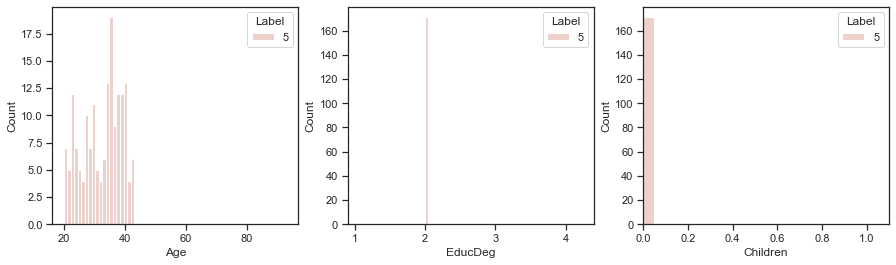

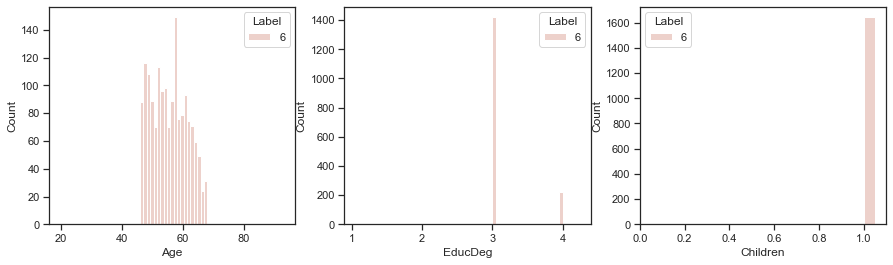

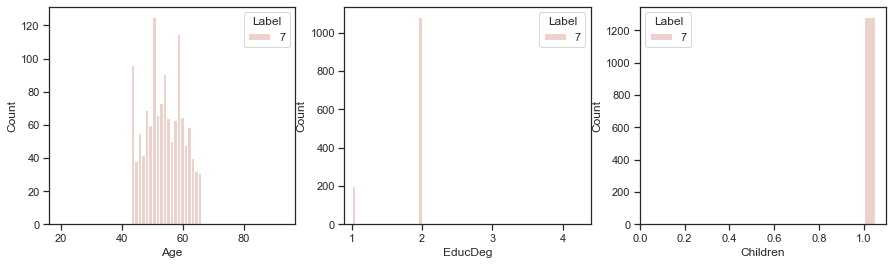

In [ ]:
visualize_clustering(kp_sociodem, df.Label, ["Age", "EducDeg", "Children"])

In [ ]:
# strip plot for cluster visualization?
# sns.set_style("ticks")

# # test = df.copy()
# # test.EducDeg = test.EducDeg.replace(educ_mapper)

# x_vars = ["Age", "EducDeg"]

# g = sns.PairGrid(df.sort_values("Age", ascending = False),
#                  x_vars = x_vars, y_vars = ["Cluster"],
#                  hue = "Children",
#                  height = 8,
#                  aspect = 0.85)

# g.map(sns.stripplot, size = 12, orient = "h", jitter = True,
#       palette = ["gray", "palevioletred"], alpha = 0.1)

# # add better labels
# g.set(ylabel = "Clusters")

# titles = ["Age", "EducDeg"]

# for ax, title in zip(g.axes.flat, titles):

#     # set axis titles
#     ax.set(title = title)

#     # horizontal grid
#     ax.xaxis.grid(False)
#     ax.yaxis.grid(True, lw = 1.5)
    
# plt.legend(title = "Children")

#### 3.1.6. Birch (Age, EducDeg)

In [ ]:
# scale data
birch_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, birch_sociodem_minmax = data_scaler(birch_sociodem, "minmax")
standard_scaler, birch_sociodem_standard = data_scaler(birch_sociodem, "standard")
robust_scaler, birch_sociodem_robust = data_scaler(birch_sociodem, "robust")

# find suitable threshold values
# for t in np.arange(0.01, 0.50, 0.05):
#     birch_sociodem_clusters = Birch(threshold = t).fit(birch_sociodem_minmax)
#     birch_sociodem_labels = birch_sociodem_clusters.labels_
#     print(t)
#     print(set(birch_sociodem_labels))

# obtain clusters and labels
birch_sociodem_clusters = Birch(threshold = 0.2).fit(birch_sociodem_minmax)
birch_sociodem_labels = birch_sociodem_clusters.labels_

# overview of the clusters
df["Label"] = birch_sociodem_labels
evaluate_clustering(birch_sociodem_minmax, df.Label)
summarise_clustering(df, df.Label, "CMV")

Silhouette score: 0.43
Davies-Bouldin score: 0.88
Calinski-Harabasz score: 8280.75
Cluster sizes:
           obs     %
Cluster            
0        3276  32.6
1        3449  34.3
2        3326  33.1


Generation        Age       YearSal   EducDeg  Children  FirstPolAge  \
Cluster                                                                         
2          1.696031  66.188214  41497.792664  2.598016  0.417619    36.314191   
1          3.063787  42.485068  25720.147016  3.199768  0.873587    13.753262   
0          3.160562  40.645910  23383.429609  1.643773  0.827534    13.960623   

         CustYears         CMV  ClaimsRate       Motor  ...  HouseRatio  \
Cluster                                                 ...               
2        29.874023  206.012589    0.692486  293.001993  ...    0.223452   
1        28.731806  213.871110    0.652157  366.714862  ...    0.145592   
0        26.685287  227.633199    0.698605  236.784579  ...    0.303479   

             Health  HealthRatio       Life  LifeRatio       Work  WorkRatio  \
Cluster                                                                        
2        183.580322     0.254660  37.281311   0.049676  36.541058   0.049043   
1        151.384227     0.221252  22.860267   0.031623  22.988005   0.031556   
0        169.547585     0.217520  62.285186   0.073784  60.242656   0.071307   

          PremTotal  EffortRatio  Label  
Cluster                                  
2        739.061915     0.018202    2.0  
1        683.775138     0.031228    1.0  
0        822.830656     0.046695    0.0  

[3 rows x 22 columns]

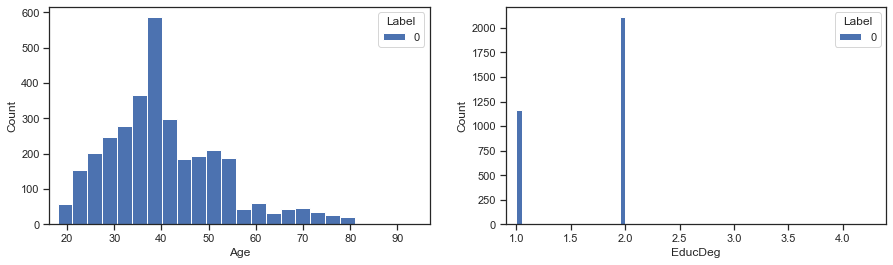

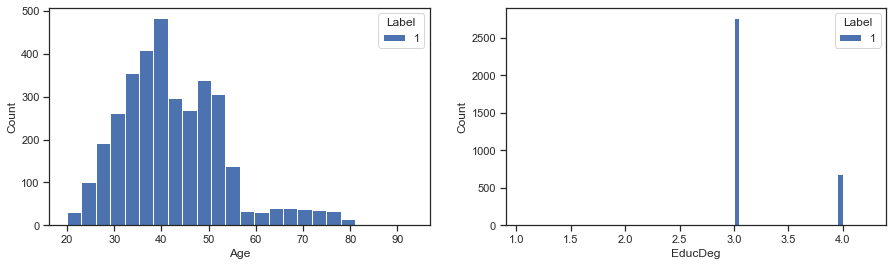

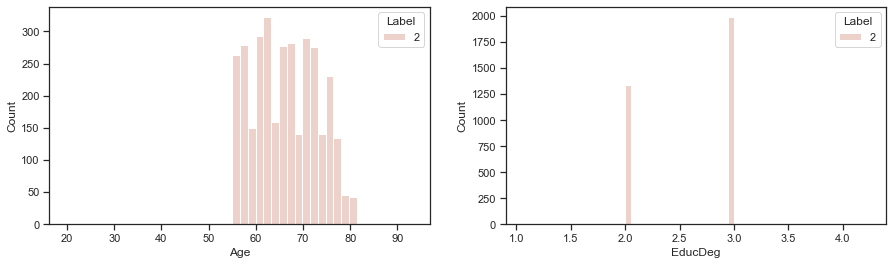

In [ ]:
visualize_clustering(birch_sociodem, birch_sociodem_labels, ["Age", "EducDeg"])

<a class="anchor" id="clustering-sociodemographic"></a>

<h3><right>3.2. Value clustering</right></h3>

In [75]:
# potentially relevant features for customer segmentation based on value
# CMV and ClaimsRate largely redundant - try both, choose one
# probably want to include PremTotal + CMV/ClaimsRate
# see if other features seem relevant
df_value = df_transformed[[
    "FirstPolAge",
    "CustYears",
    "CMV",
    "ClaimsRate",
    "PremTotal",
    "EffortRatio"
]]

#### 3.2.1. KMeans (FirstPolAge, CustYears, CMV, PremTotal, EffortRatio)

Silhouette score: 0.25
Davies-Bouldin score: 1.26
Calinski-Harabasz score: 3918.86
Cluster sizes:
           obs     %
Cluster            
0        2298  22.9
1        2099  20.9
2        2565  25.5
3        2013  20.0
4        1076  10.7


FirstPolAge  CustYears         CMV  PremTotal  EffortRatio
Cluster                                                            
0          40.739774  23.616188  209.262171  32.864255     0.161304
1           8.445927  35.369223  203.713554  32.107786     0.185107
2          12.157505  24.879922  160.022101  32.377131     0.205577
3          30.418281  34.791356  216.649603  33.141447     0.162003
4           9.467472  21.855019  384.306812  37.759903     0.302466

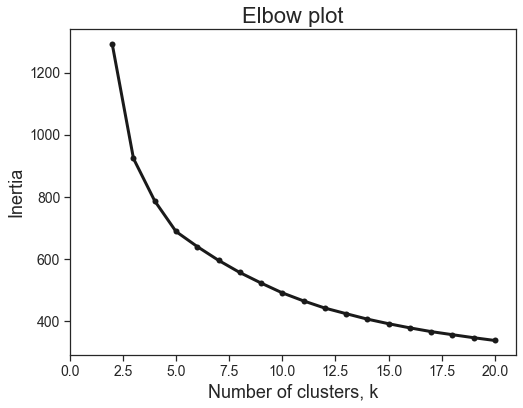

In [ ]:
# scale data
km_value = df_value[["FirstPolAge", "CustYears", "CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
plot_elbow(km_value_minmax, 20, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 5)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(km_value, df.Label)

#### 3.2.2. KMeans (CMV, PremTotal, EffortRatio)

In [ ]:
# scale data
km_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
# plot_elbow(km_value_minmax, 30, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 4)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(km_value, df.Label, sort_by = "CMV")

Silhouette score: 0.37
Davies-Bouldin score: 1.03
Calinski-Harabasz score: 5795.39
Cluster sizes:
           obs     %
Cluster            
0        4119  41.0
1        3936  39.2
2         714   7.1
3        1282  12.8


CMV  PremTotal  EffortRatio
Cluster                                    
0          8.704064  31.986588     0.173997
3         84.392894  36.506320     0.267256
1        385.056039  32.445277     0.176150
2        712.803067  37.883141     0.259726

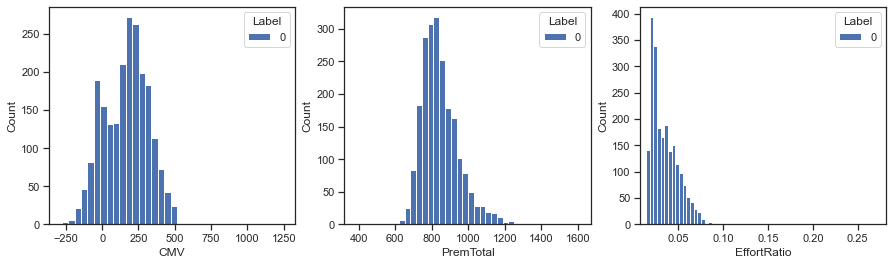

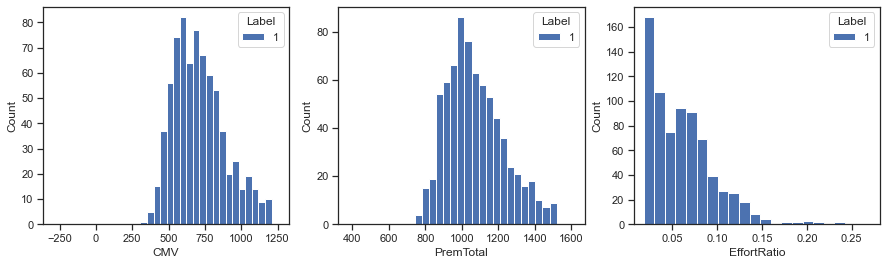

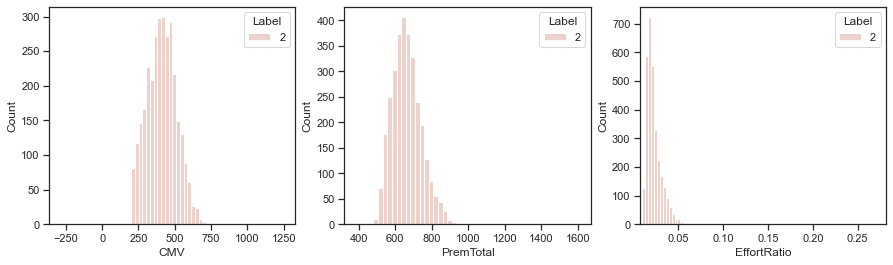

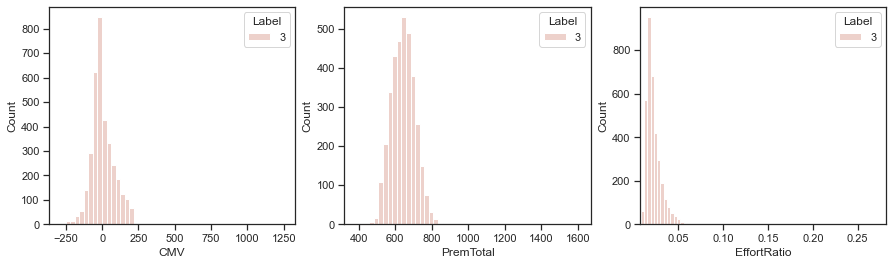

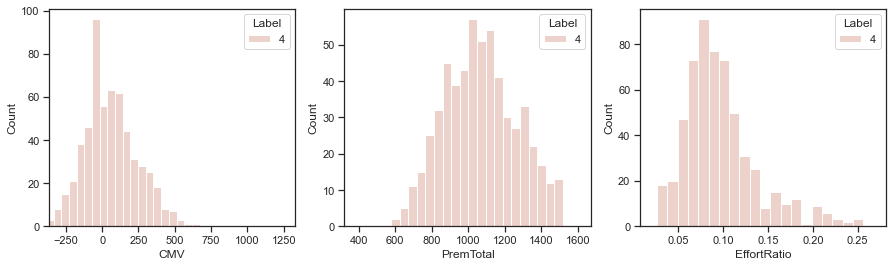

In [ ]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.3. KMeans (ClaimsRate, PremTotal, EffortRatio)

In [ ]:
# scale data
km_value = df_value[["ClaimsRate", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot (maybe 4-6 clusters)
# plot_elbow(km_value_minmax, 30, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 5)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(df, df.Label, sort_by = "ClaimsRate")

Silhouette score: 0.37
Davies-Bouldin score: 1.04
Calinski-Harabasz score: 6441.42
Cluster sizes:
           obs     %
Cluster            
0        2283  22.7
1        2578  25.6
2         872   8.7
3         739   7.4
4        3579  35.6


Generation        Age       YearSal   EducDeg  Children  FirstPolAge  \
Cluster                                                                         
1          2.518619  51.713732  32265.140713  2.750194  0.766874    22.237781   
3          3.286874  38.516915  20441.868430  1.920162  0.695535    13.917456   
0          2.507665  52.195795  31919.124982  2.397722  0.615856    23.505475   
2          3.369266  37.352064  18561.704003  1.880734  0.735092    13.047018   
4          2.508243  52.057279  32408.862561  2.637329  0.719475    22.715004   

         CustYears         CMV  ClaimsRate       Motor  ...  HouseRatio  \
Cluster                                                 ...               
1        29.475950  433.913371    0.294166  388.998200  ...    0.109066   
3        24.599459  683.943938    0.340244  140.564222  ...    0.542269   
0        28.690320  251.302777    0.646382  243.818962  ...    0.291439   
2        24.305046   27.248303    0.948761  132.340436  ...    0.514830   
4        29.342274  -14.803663    0.985840  345.425147  ...    0.123875   

             Health  HealthRatio       Life  LifeRatio       Work  WorkRatio  \
Cluster                                                                        
1        136.939957     0.210651  21.929721   0.032930  22.004445   0.032947   
3        174.552517     0.169705  77.868552   0.074441  78.199350   0.074072   
0        204.470394     0.267826  48.502335   0.062441  46.337157   0.059667   
2        179.570298     0.182763  86.906124   0.086123  81.153028   0.080783   
4        162.820204     0.246831  29.700006   0.044272  29.926287   0.044486   

           PremTotal  EffortRatio  Label  
Cluster                                   
1         650.097653     0.022196    1.0  
3        1066.398173     0.069218    3.0  
0         781.323745     0.028842    0.0  
2        1036.178429     0.074435    2.0  
4         659.604334     0.022937    4.0  

[5 rows x 22 columns]

#### 3.2.4. KMeans (CMV, PremTotal)

Silhouette score: 0.46
Davies-Bouldin score: 0.73
Calinski-Harabasz score: 9051.4
Cluster sizes:
           obs     %
Cluster            
0        3975  39.5
1        3889  38.7
2         824   8.2
3        1363  13.6


CMV  PremTotal
Cluster                       
0          7.822475  31.839831
3         68.051988  36.708385
1        379.672576  32.321595
2        689.526505  37.635306

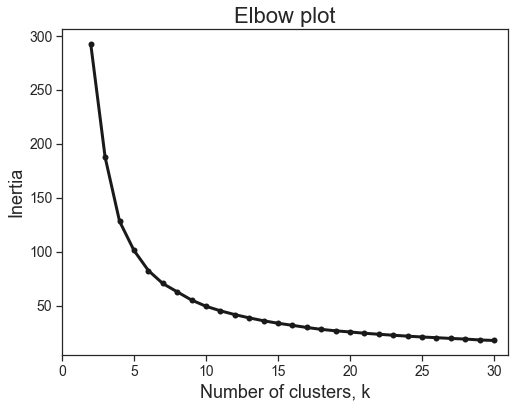

In [ ]:
# scale data
km_value = df_value[["CMV", "PremTotal"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
plot_elbow(km_value_minmax, 30, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 4)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(km_value, df.Label, sort_by = "CMV")

#### 3.2.5. KMeans + Hierarchical (CMV, PremTotal, EffortRatio)

Silhouette score: 0.33
Davies-Bouldin score: 1.09
Calinski-Harabasz score: 3403.22
Cluster sizes:
           obs     %
Cluster            
0        7653  76.1
1        1667  16.6
2         316   3.1
3         415   4.1


CMV  PremTotal  EffortRatio
Cluster                                    
2          4.015443  38.440319     0.346591
0        155.231704  32.103227     0.178502
1        389.614355  35.560988     0.205331
3        794.750482  39.021026     0.289631

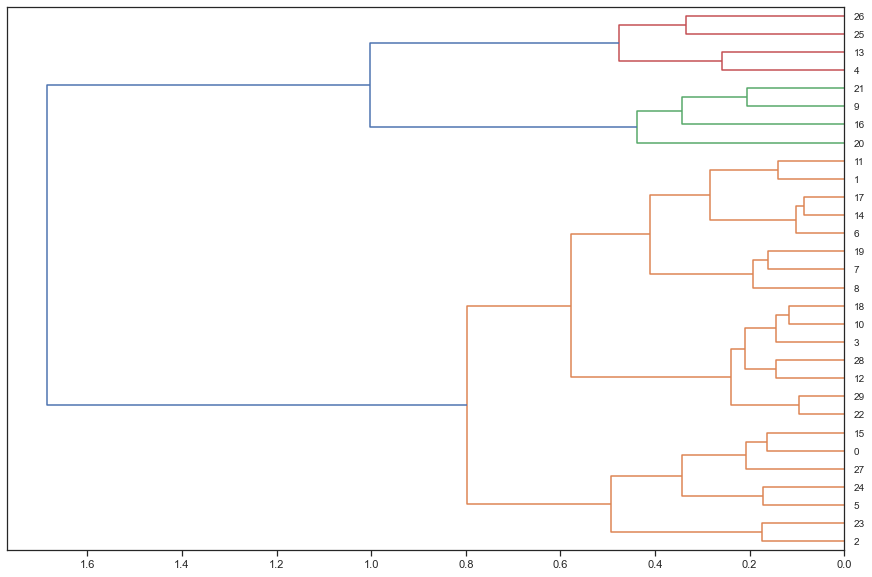

In [ ]:
# scale data
km_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_value_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_value_linkage = hierarchy.linkage(km_value_centroids, method = "ward")
hierarchy.dendrogram(
    km_value_linkage,
    orientation = "left",
    color_threshold = 1.0
)

# hierarchical clustering of the centroids obtained
hc_value_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_value_centroids)
hc_value_labels = pd.Series(hc_value_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_value_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_value_centroids), columns = ["CMV", "PremTotal", "EffortRatio"])
km_value_centroids = pd.concat([km_value_centroids, hc_value_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_value_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_value_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(km_value, df.Label, "CMV")

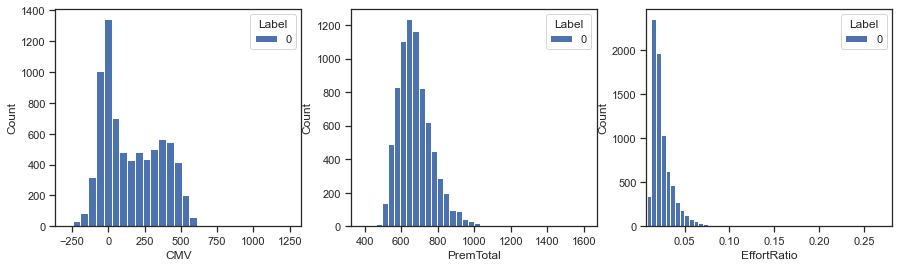

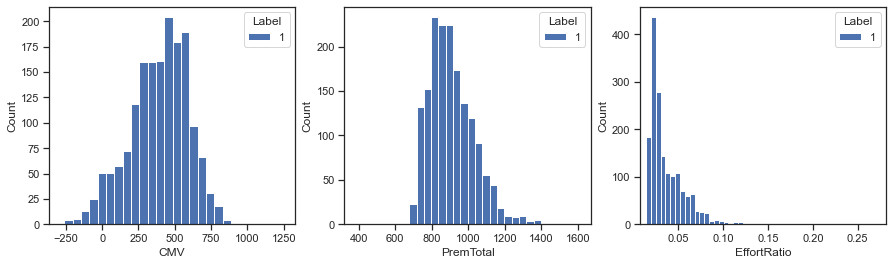

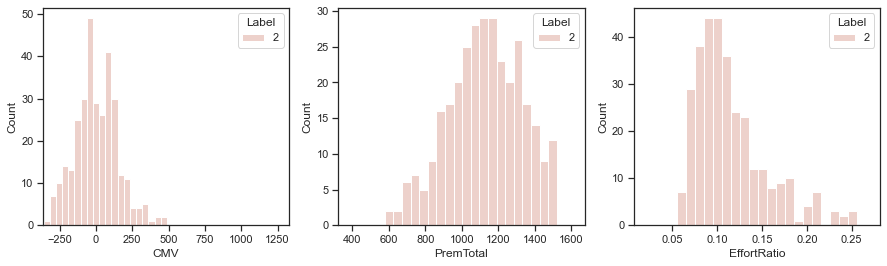

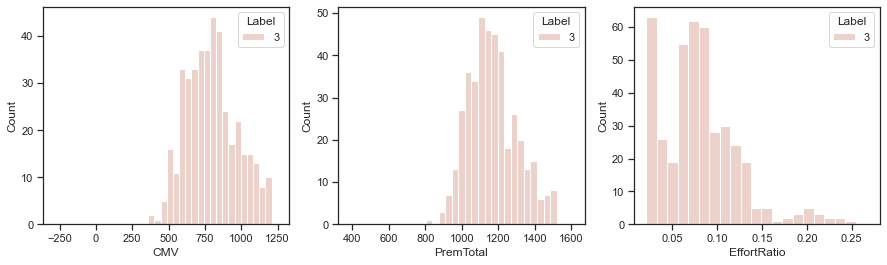

In [ ]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.6. KMeans + Hierarchical (ClaimsRate, PremTotal, EffortRatio)

Silhouette score: 0.38
Davies-Bouldin score: 0.95
Calinski-Harabasz score: 5573.22
Cluster sizes:
           obs     %
Cluster            
0         684   6.8
1        4458  44.4
2        4909  48.8


ClaimsRate  PremTotal  EffortRatio
Cluster                                    
2          0.433545  32.843102     0.180655
0          0.636871  38.674183     0.328189
1          0.959453  32.666466     0.185457

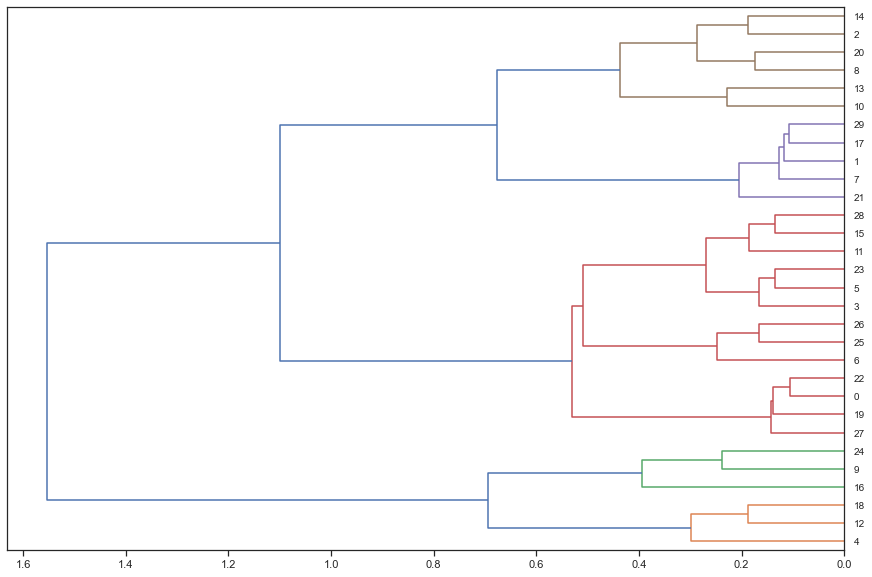

In [ ]:
# scale data
km_value = df_value[["ClaimsRate", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_value_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_value_linkage = hierarchy.linkage(km_value_centroids, method = "ward")
hierarchy.dendrogram(
    km_value_linkage,
    orientation = "left",
    color_threshold = 0.6
)

# hierarchical clustering of the centroids obtained
hc_value_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(km_value_centroids)
hc_value_labels = pd.Series(hc_value_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_value_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_value_centroids), columns = ["ClaimsRate", "PremTotal", "EffortRatio"])
km_value_centroids = pd.concat([km_value_centroids, hc_value_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_value_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_value_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(km_value, df.Label, "ClaimsRate")

#### 3.2.7. Hierarchical

Silhouette score: 0.29
Davies-Bouldin score: 1.08
Calinski-Harabasz score: 4523.34
Cluster sizes:
           obs     %
Cluster            
0        5718  56.9
1        1516  15.1
2        2817  28.0


CMV  PremTotal  EffortRatio
Cluster                                    
0         56.992921  32.888829     0.183646
2        393.666180  31.603711     0.172323
1        483.985844  37.085128     0.265542

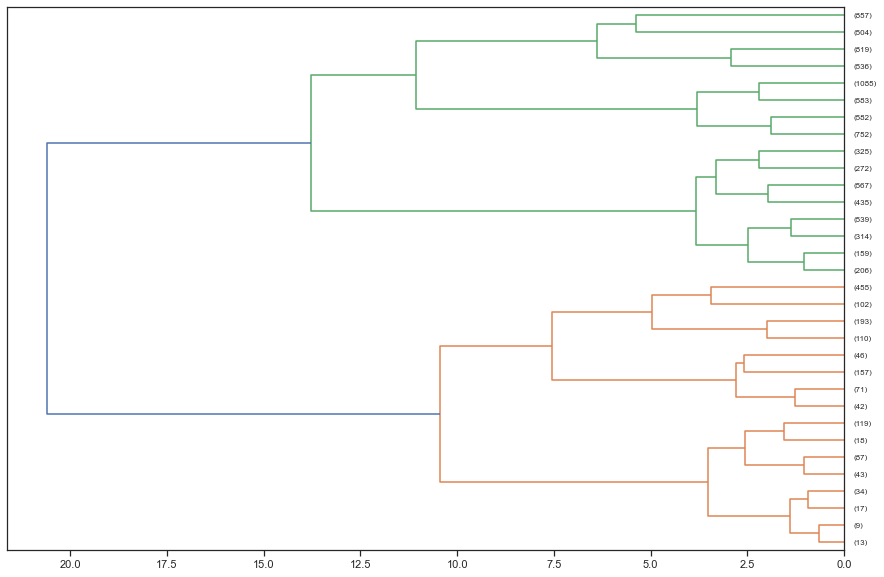

In [ ]:
# scale data
hc_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, hc_value_minmax = data_scaler(hc_value, "minmax")
standard_scaler, hc_value_standard = data_scaler(hc_value, "standard")
robust_scaler, hc_value_robust = data_scaler(hc_value, "robust")

hc_value_distances, hc_value_labels, hc_value_linkage = hierarchical_clustering(
    hc_value_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_value_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 15
)

# perform AgglomerativeClustering
hc_value_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(hc_value_minmax)
hc_value_labels = hc_value_clusters.labels_

# overview of the clusters
df["Label"] = hc_value_labels
evaluate_clustering(hc_value_minmax, df.Label)
summarise_clustering(hc_value, df.Label, "CMV")

#### 3.2.8. DBSCAN

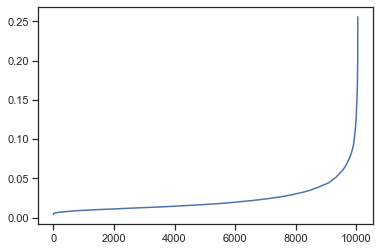

Silhouette score: 0.3
Davies-Bouldin score: 0.71
Calinski-Harabasz score: 25.72
Cluster sizes:
           obs     %
Cluster            
-1        145   1.4
 0       9889  98.4
 1          5   0.0
 2          7   0.1
 3          5   0.0


CMV  PremTotal  EffortRatio
Cluster                                    
 1      -373.754000  34.201716     0.259252
 2        99.958571  34.720453     0.380855
 3       143.768000  33.181662     0.423179
 0       214.663770  33.090430     0.189834
-1       318.661310  37.902133     0.377521

In [ ]:
# scale data
db_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, db_value_minmax = data_scaler(db_value, "minmax")
standard_scaler, db_value_standard = data_scaler(db_value, "standard")
robust_scaler, db_value_robust = data_scaler(db_value, "robust")

# find adequate values for eps
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(db_value_minmax)
distances, _ = neigh.kneighbors(db_value_minmax)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

# get clusters and labels based on selected eps
db_value_clusters = DBSCAN(eps = 0.07, min_samples = 5).fit(db_value_minmax)
db_value_labels = db_value_clusters.labels_

# overview of the clusters
df["Label"] = db_value_labels
evaluate_clustering(db_value_minmax, df.Label)
summarise_clustering(db_value, df.Label, "CMV")

#### 3.2.9. BIRCH

In [ ]:
# scale data
birch_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, birch_value_minmax = data_scaler(birch_value, "minmax")
standard_scaler, birch_value_standard = data_scaler(birch_value, "standard")
robust_scaler, birch_value_robust = data_scaler(birch_value, "robust")

# model and labels
birch_value_clusters = Birch(threshold = 0.1).fit(birch_value_minmax)
birch_value_labels = birch_value_clusters.labels_
set(birch_value_labels)

# overview of the clusters
df["Label"] = birch_value_labels
evaluate_clustering(birch_value_minmax, df.Label)
summarise_clustering(df, df.Label, "CMV")

Silhouette score: 0.47
Davies-Bouldin score: 0.96
Calinski-Harabasz score: 2819.16
Cluster sizes:
           obs     %
Cluster            
0         665   6.6
1        9010  89.6
2         376   3.7


Generation        Age       YearSal   EducDeg  Children  FirstPolAge  \
Cluster                                                                         
2          3.765957  30.545213   9791.840426  1.752660  0.771277     9.156915   
1          2.578246  50.846615  31313.966799  2.562375  0.712098    21.920089   
0          2.881203  45.437594  26336.824060  1.978947  0.612030    19.560902   

         CustYears         CMV  ClaimsRate       Motor  ...  HouseRatio  \
Cluster                                                 ...               
2        21.388298   80.266303    0.887872  111.539654  ...    0.476794   
1        28.926526  182.828127    0.700802  318.218057  ...    0.188079   
0        25.876692  738.502466    0.290316  159.318602  ...    0.549888   

             Health  HealthRatio        Life  LifeRatio       Work  WorkRatio  \
Cluster                                                                         
2        175.528085     0.193725  101.400824   0.103958  94.183245   0.097358   
1        167.866027     0.238109   35.669008   0.048066  34.828069   0.047033   
0        164.930496     0.157127   71.254887   0.065926  73.627564   0.067935   

           PremTotal  EffortRatio  Label  
Cluster                                   
2        1018.507261     0.112583    2.0  
1         711.627974     0.026626    1.0  
0        1078.686962     0.058626    0.0  

[3 rows x 22 columns]

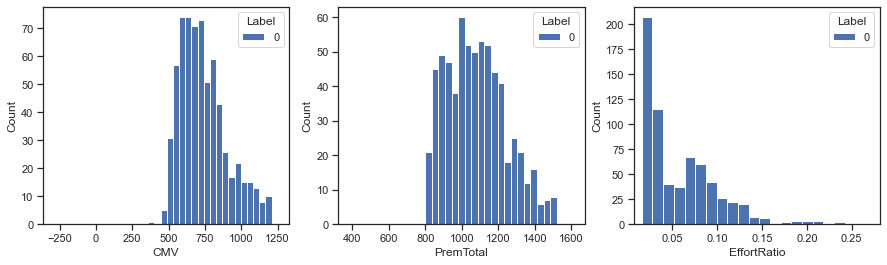

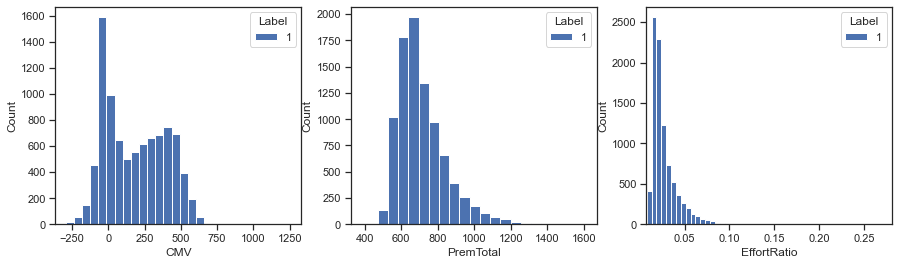

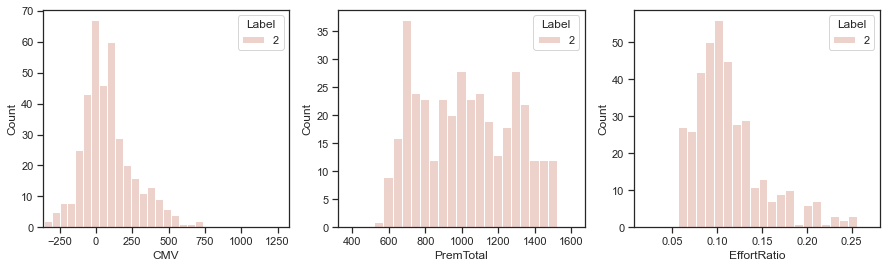

In [ ]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.10. SOM + HC

In [ ]:
# scale data
som_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, som_value_minmax = data_scaler(som_value, "minmax")
standard_scaler, som_value_standard = data_scaler(som_value, "standard")
robust_scaler, som_value_robust = data_scaler(som_value, "robust")

names = ["CMV", "PremTotal", "EffortRatio"]

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_value_minmax.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.032000, quantization error: 0.498724

 epoch: 2 ---> elapsed time:  0.044000, quantization error: 1.143074

 epoch: 3 ---> elapsed time:  0.039000, quantization error: 0.852106

 epoch: 4 ---> elapsed time:  0.038000, quantization error: 0.765456

 epoch: 5 ---> elapsed time:  0.043000, quantization error: 0.748209

 epoch: 6 ---> elapsed time:  0.038000, quantization error: 0.741111

 epoch: 7 ---> elapsed time:  0.038000, quantization error: 0.737431

 epoch: 8 ---> elapsed time:  0.043000, quantization error: 0.734367

 epoch: 9 ---> elapsed time:  0.038000, quantization error: 0.731287

 epoch: 10 ---> elapsed time:  0.040000, quantization error: 0.728126

 epoch: 11 ---> elapsed time:  0.035000, quantization error: 0.724656

 epoch: 12 ---> elapsed time:  0.043000, quantization error: 0.721139

 epoch: 13 ---> 

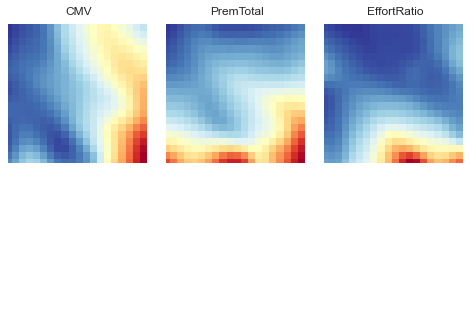

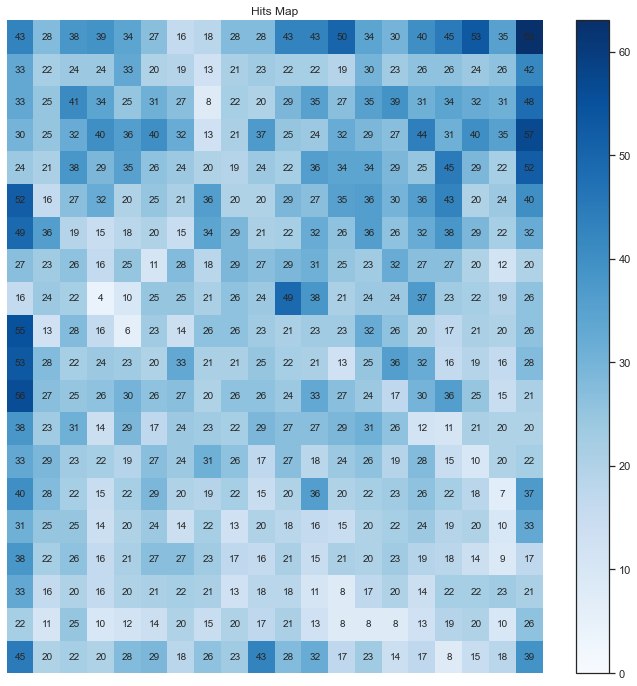

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = ["CMV", "PremTotal", "EffortRatio"])
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 3, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

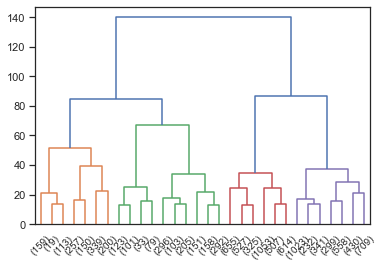

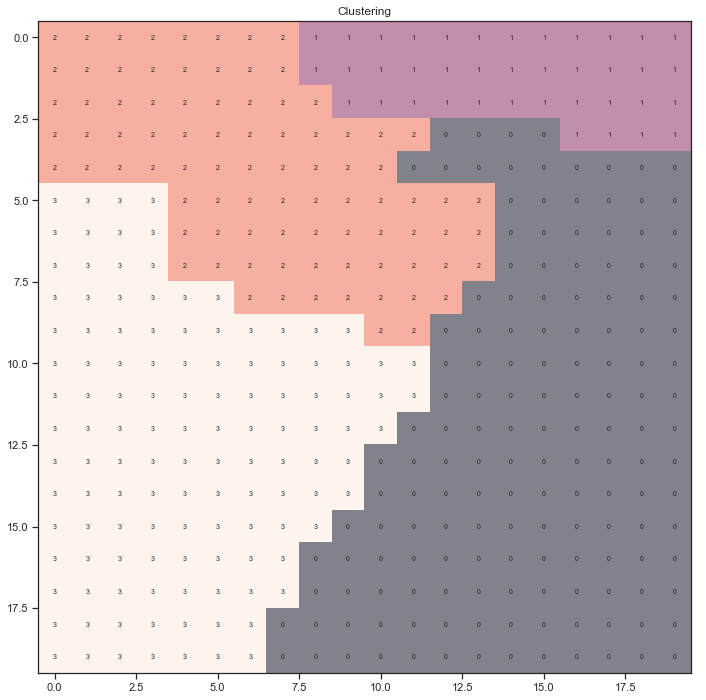

In [ ]:
# apply HC to SOM results
som_value_linkage = hierarchy.linkage(sm._data, method = "ward")
hierarchy.dendrogram(
    som_value_linkage,
    truncate_mode = "lastp",
    p = 30,
    orientation = "top",
    color_threshold = 80
)

# k = 2 or k = 4 (from dendrogram)
hc_value_labels = AgglomerativeClustering(4).fit_predict(sm.codebook.matrix)
sm.cluster_labels = hc_value_labels

# visualize clusters
hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [ ]:
# final SOM + HC clusters
hc_final_clusters = AgglomerativeClustering(4).fit(sm._data)
hc_final_labels = hc_final_clusters.labels_

# overview of the clusters
df["Label"] = hc_final_labels
evaluate_clustering(som_value_minmax, df.Label)
summarise_clustering(som_value, df.Label, "CMV")

Silhouette score: 0.32
Davies-Bouldin score: 1.13
Calinski-Harabasz score: 4742.08
Cluster sizes:
           obs     %
Cluster            
0        1541  15.3
1        1237  12.3
2        3681  36.6
3        3592  35.7


CMV  PremTotal  EffortRatio
Cluster                                    
2         17.918305  31.793190     0.174129
0         24.386827  35.964767     0.243296
3        372.365379  32.164174     0.172445
1        588.109838  36.637738     0.244768

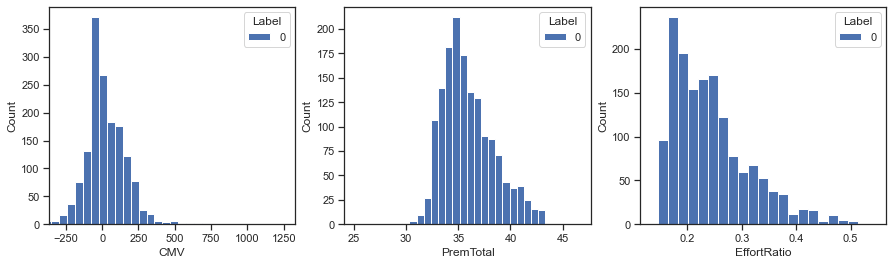

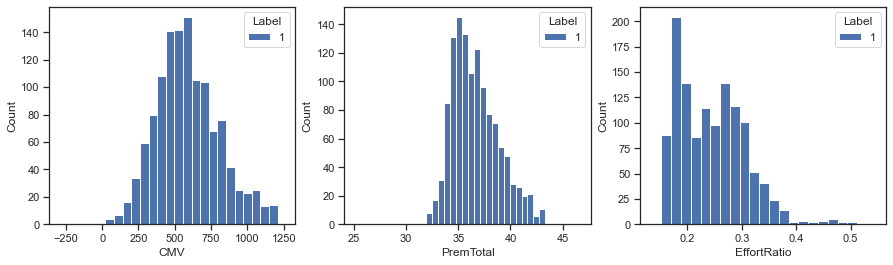

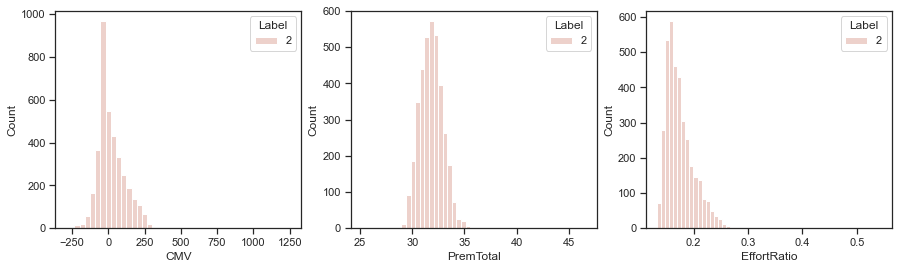

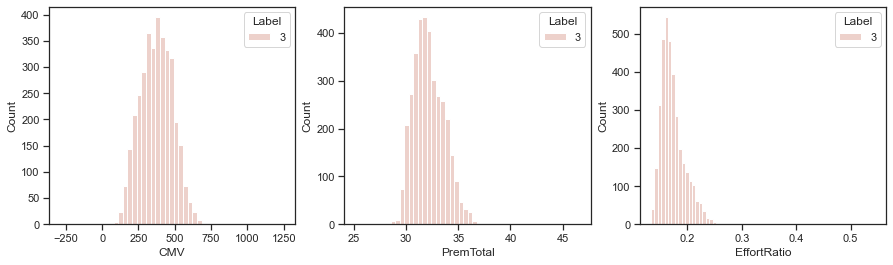

In [ ]:
# visualize clusters
visualize_clustering(som_value, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.11. SOM + KMeans

In [ ]:
# scale data
som_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, som_value_minmax = data_scaler(som_value, "minmax")
standard_scaler, som_value_standard = data_scaler(som_value, "standard")
robust_scaler, som_value_robust = data_scaler(som_value, "robust")

names = ["CMV", "PremTotal", "EffortRatio"]

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_value_minmax.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.034000, quantization error: 0.498724

 epoch: 2 ---> elapsed time:  0.041000, quantization error: 1.143074

 epoch: 3 ---> elapsed time:  0.044000, quantization error: 0.852106

 epoch: 4 ---> elapsed time:  0.045000, quantization error: 0.765456

 epoch: 5 ---> elapsed time:  0.037000, quantization error: 0.748209

 epoch: 6 ---> elapsed time:  0.039000, quantization error: 0.741111

 epoch: 7 ---> elapsed time:  0.041000, quantization error: 0.737431

 epoch: 8 ---> elapsed time:  0.036000, quantization error: 0.734367

 epoch: 9 ---> elapsed time:  0.039000, quantization error: 0.731287

 epoch: 10 ---> elapsed time:  0.037000, quantization error: 0.728126

 epoch: 11 ---> elapsed time:  0.040000, quantization error: 0.724656

 epoch: 12 ---> elapsed time:  0.035000, quantization error: 0.721139

 epoch: 13 ---> 

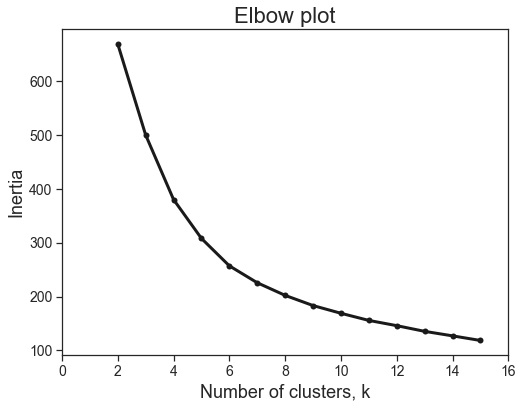

In [ ]:
# SOM + KMeans
plot_elbow(sm.codebook.matrix, 15, "kmeans")

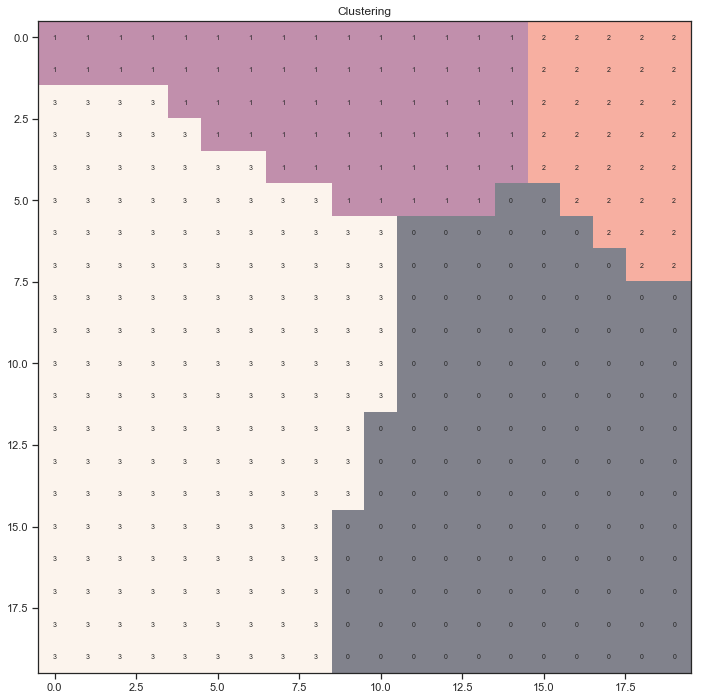

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 15)
km_value_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = km_value_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate = True, onlyzeros = False, labelsize = 7, cmap = "Pastel1")

plt.show()

In [ ]:
# final SOM + KMeans clusters
km_final_clusters = KMeans(4).fit(sm._data)
km_final_labels = km_final_clusters.labels_

df["Label"] = km_final_labels
evaluate_clustering(som_value_minmax, df.Label)
summarise_clustering(som_value, df.Label, "CMV")

Silhouette score: 0.37
Davies-Bouldin score: 1.02
Calinski-Harabasz score: 5735.26
Cluster sizes:
           obs     %
Cluster            
0        3974  39.5
1        1242  12.4
2         653   6.5
3        4182  41.6


CMV  PremTotal  EffortRatio
Cluster                                    
3          9.812049  32.036702     0.173589
1         89.037037  36.402536     0.272758
0        388.521641  32.528949     0.176014
2        724.292037  38.051380     0.266299

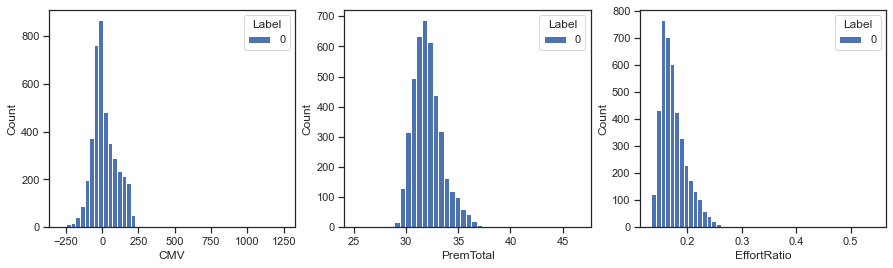

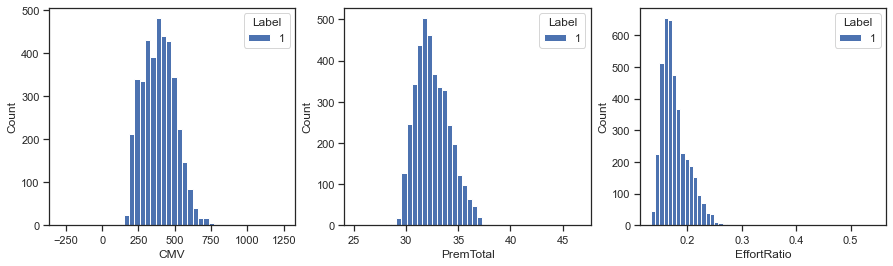

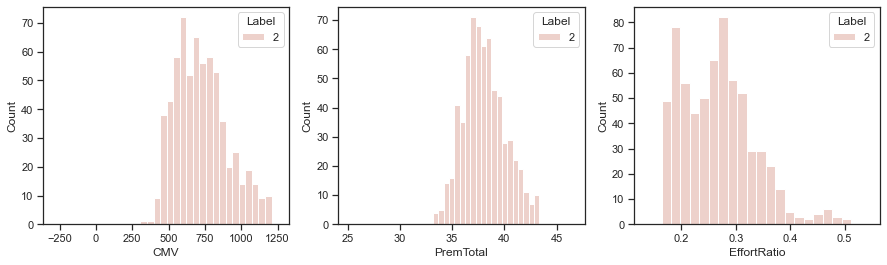

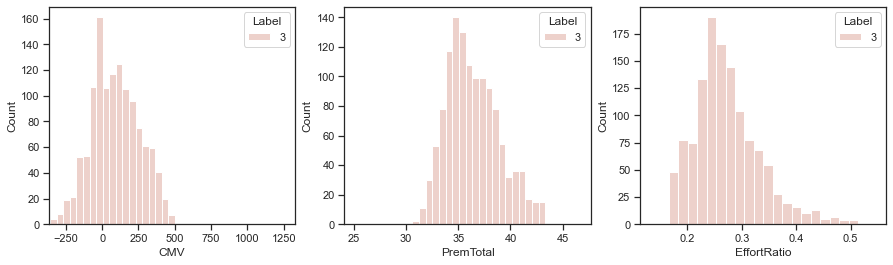

In [ ]:
# visualize clusters
visualize_clustering(som_value, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.12. AffinityPropagation (CMV, PremTotal, EffortRatio)

In [ ]:
# scale data
ap_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, ap_value_minmax = data_scaler(ap_value, "minmax")
standard_scaler, ap_value_standard = data_scaler(ap_value, "standard")
robust_scaler, ap_value_robust = data_scaler(ap_value, "robust")

# get clusters and labels based on selected eps
ap_value_clusters = AffinityPropagation(damping = 0.7, verbose = True).fit(ap_value_minmax)
ap_value_labels = ap_value_clusters.labels_

# overview of the clusters
df["Label"] = ap_value_labels
evaluate_clustering(ap_value_minmax, df.Label)
summarise_clustering(ap_value, df.Label, "CMV")

Did not converge


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

#### 3.2.13. MeanShift (CMV, PremTotal, EffortRatio)

In [ ]:
# scale data
ms_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, ms_value_minmax = data_scaler(ms_value, "minmax")
standard_scaler, ms_value_standard = data_scaler(ms_value, "standard")
robust_scaler, ms_value_robust = data_scaler(ms_value, "robust")

# for bandwidth in np.arange(0.1, 0.5, 0.01):
#     ms_value_clusters = MeanShift(bandwidth = bandwidth).fit(ms_value_minmax)
#     ms_value_labels = ms_value_clusters.labels_
#     print(bandwidth, set(ms_value_labels))

#bandwidth = estimate_bandwidth(ms_value_minmax, quantile=0.06, random_state=15, n_jobs=-1)

# # compute clusters and labels
ms_value_clusters = MeanShift(bandwidth = 0.20).fit(ms_value_minmax)
ms_value_labels = ms_value_clusters.labels_

df["Label"] = ms_value_labels
evaluate_clustering(ap_value_minmax, df.Label)
summarise_clustering(ap_value, df.Label, "CMV")

Silhouette score: 0.56
Davies-Bouldin score: 0.87
Calinski-Harabasz score: 3684.55
Cluster sizes:
           obs     %
Cluster            
0        9470  94.2
1         581   5.8


CMV  PremTotal  EffortRatio
Cluster                                    
0        198.250169  32.807548     0.184256
1        501.095680  38.932110     0.332499

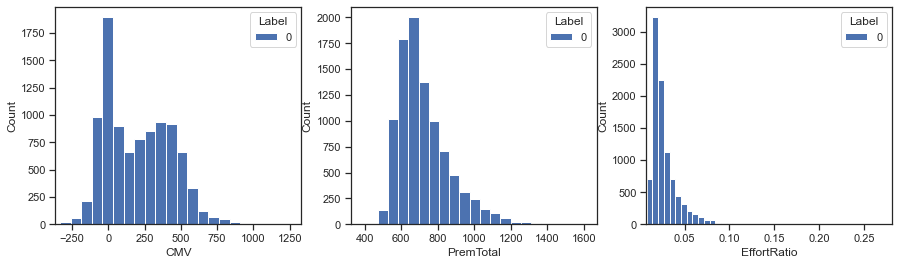

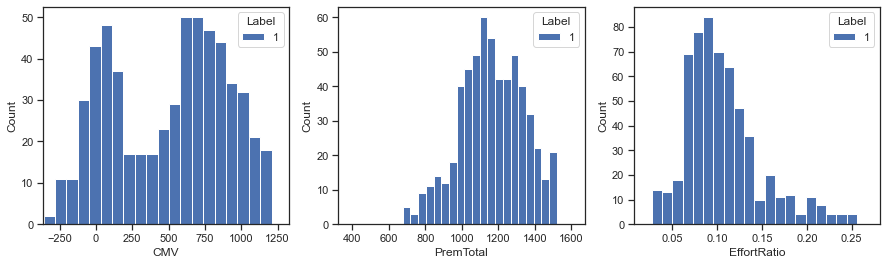

In [ ]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.14. Spectral clustering (CMV, PremTotal, EffortRatio)

In [ ]:
# scale data
spectral_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, spectral_value_minmax = data_scaler(spectral_value, "minmax")
standard_scaler, spectral_value_standard = data_scaler(spectral_value, "standard")
robust_scaler, spectral_value_robust = data_scaler(spectral_value, "robust")

spectral_value_clusters = SpectralClustering(5).fit(spectral_value_minmax)
spectral_value_labels = spectral_value_clusters.labels_

df["Label"] = spectral_value_labels
evaluate_clustering(spectral_value_minmax, df.Label)
summarise_clustering(spectral_value, df.Label, "CMV")

Silhouette score: 0.34
Davies-Bouldin score: 1.11
Calinski-Harabasz score: 4180.42
Cluster sizes:
           obs     %
Cluster            
0         840   8.4
1        1925  19.2
2         194   1.9
3        3568  35.5
4        3524  35.1


CMV  PremTotal  EffortRatio
Cluster                                    
3          0.676825  31.688921     0.171936
0        123.173595  36.051830     0.308222
1        245.554883  35.735769     0.187372
4        400.869038  32.169444     0.182559
2        914.068660  40.211071     0.317949

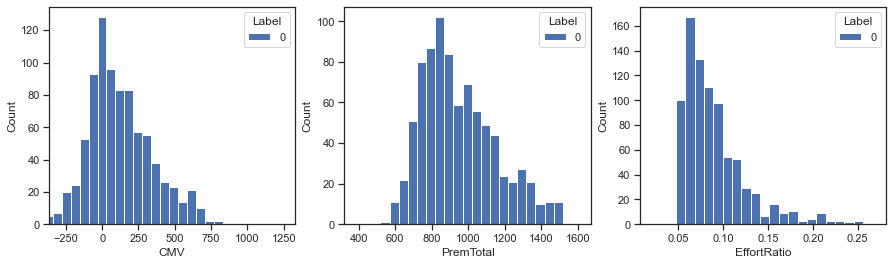

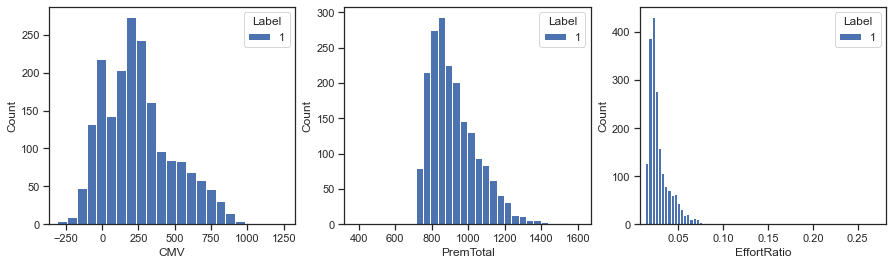

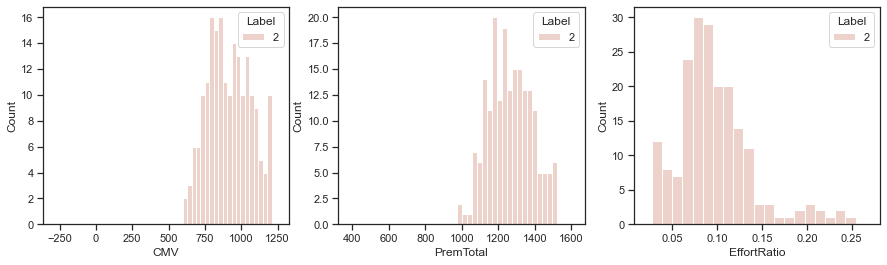

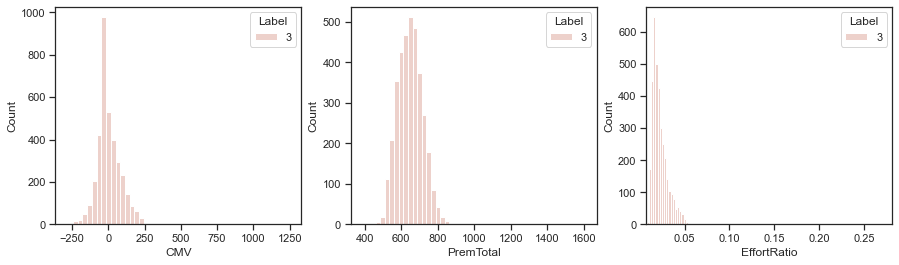

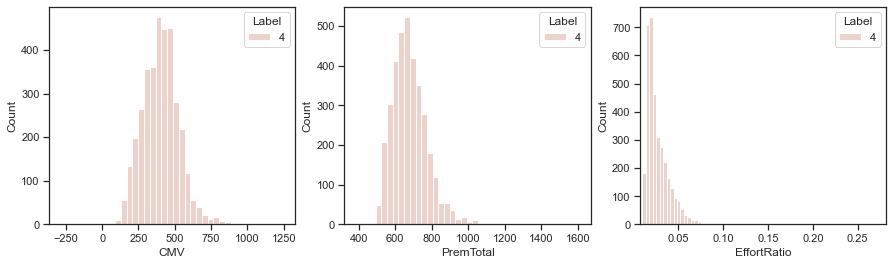

In [ ]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

<a class="anchor" id="clustering-product"></a>

<h3><right>Product clustering</right></h3>

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

    return

In [83]:
df_product = df[[
    "Motor",
    "MotorRatio",
    "House",
    "HouseRatio",
    "Health",
    "HealthRatio",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
]]

# potentially relevant features to perform customer segmentation based on product
df_product_raw = df_transformed[[
    "Motor",
    "House",
    "Health",
    "Life",
    "Work"
]]

df_product_ratios = df_transformed[[
    "MotorRatio",
    "HouseRatio",
    "HealthRatio",
    "LifeRatio",
    "WorkRatio"
]]

raw_features = ["Motor", "House", "Health", "Life", "Work"]
ratio_features = ["MotorRatio", "HouseRatio", "HealthRatio", "LifeRatio", "WorkRatio"]

#### 3.3.1. KMeans

Silhouette score: 0.31
Davies-Bouldin score: 1.23
Calinski-Harabasz score: 6816.81
Cluster sizes:
           obs     %
Cluster            
0        3741  37.2
1        2224  22.1
2        4086  40.7


Motor       House      Health       Life       Work
Cluster                                                          
1        129.919487  472.944559  176.132513  96.108080  91.075292
2        260.949219  173.940284  220.989772  35.509347  36.223904
0        443.691799   64.490537  105.177044  12.845071  12.727562

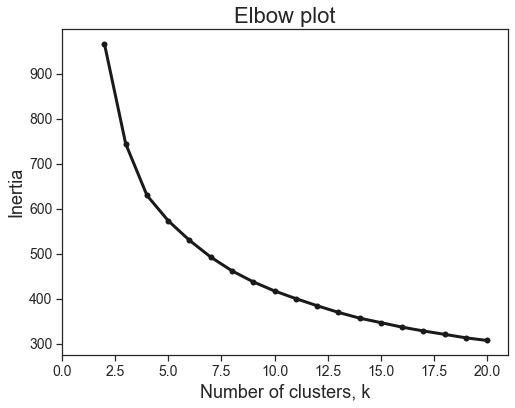

In [ ]:
## non-ratios premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_raw, "robust")

# elbow plot (suggests 4-8 clusters)
plot_elbow(km_product_minmax, 20, "kmeans")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_minmax, 3)

# cluster overview
df["Label"] = km_product_labels
evaluate_clustering(km_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

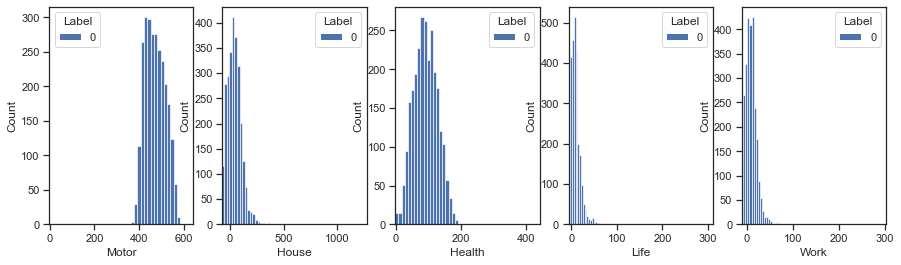

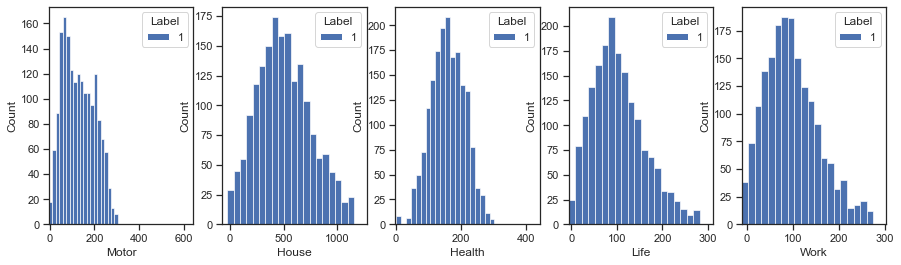

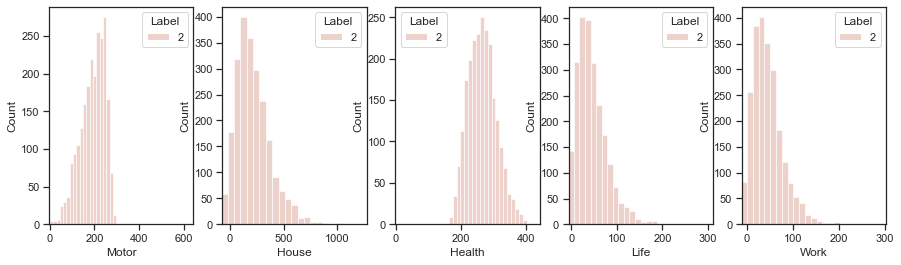

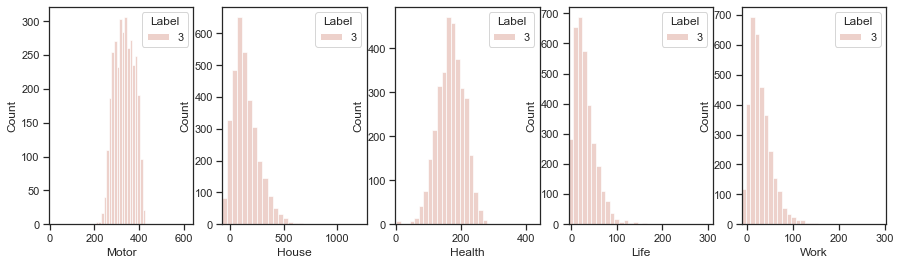

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

In [ ]:
## ratios premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_ratios, "robust")

# elbow plot (suggests 4-8 clusters)
# plot_elbow(km_product_minmax, 20, "kmeans")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_minmax, 4)

# cluster overview
df["Label"] = km_product_labels
evaluate_clustering(km_product_minmax, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

Silhouette score: 0.27
Davies-Bouldin score: 1.29
Calinski-Harabasz score: 5604.23
Cluster sizes:
           obs     %
Cluster            
0        2568  25.5
1        3068  30.5
2        2183  21.7
3        2232  22.2


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
0          0.175594    0.484468     0.179889   0.081847   0.078202
2          0.298017    0.176081     0.370340   0.078851   0.076712
1          0.517974    0.173407     0.239214   0.034257   0.035149
3          0.795950    0.035410     0.142643   0.012809   0.013187

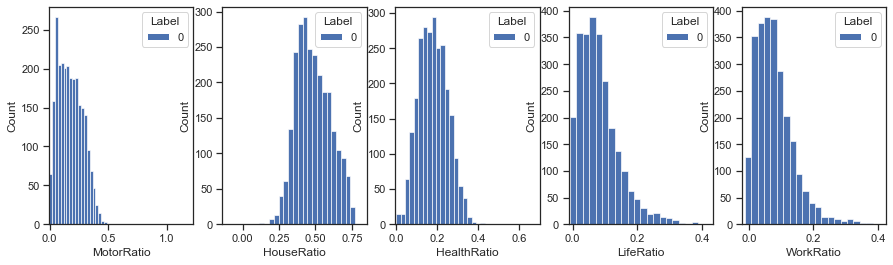

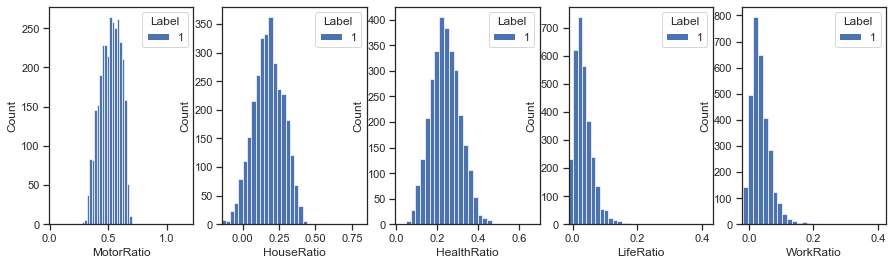

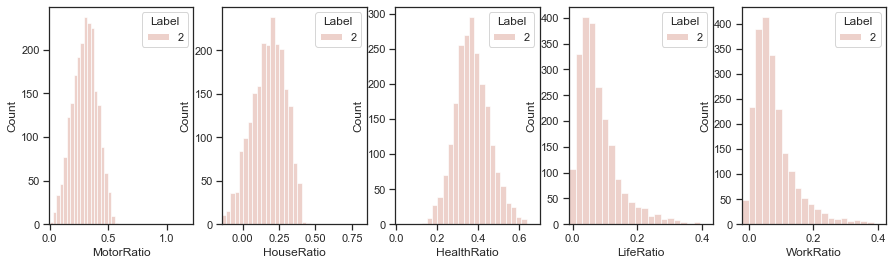

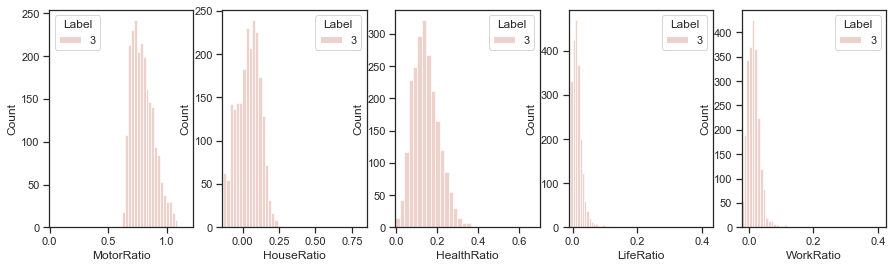

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.2. KMeans + Hierarchical

Silhouette score: 0.28
Davies-Bouldin score: 1.5
Calinski-Harabasz score: 5193.7
Cluster sizes:
           obs     %
Cluster            
0        4070  40.5
1        4685  46.6
2        1296  12.9


Motor       House      Health       Life        Work
Cluster                                                           
2        103.218657  537.958256  173.506929  95.553349  108.263997
0        227.040744  240.562199  213.003943  54.524425   45.547695
1        417.759501   69.909445  127.291187  13.049609   15.472117

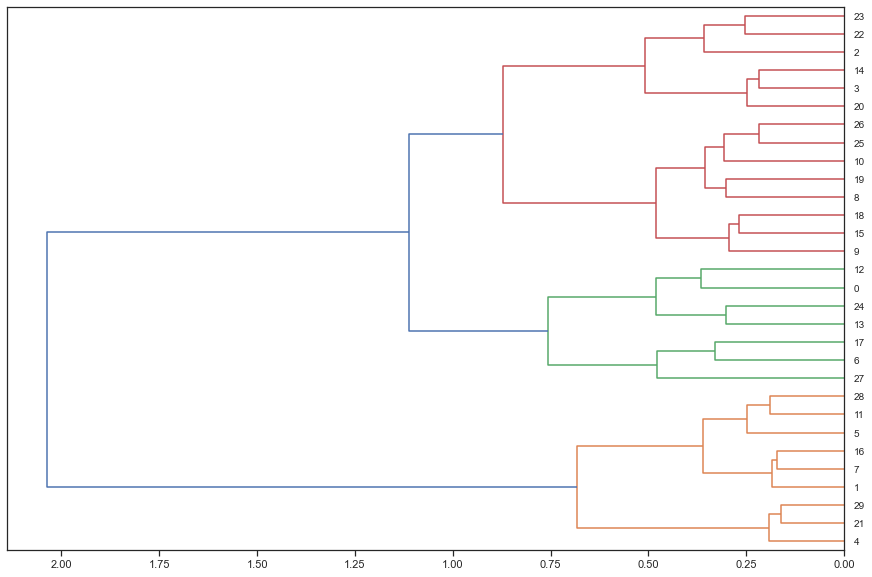

In [ ]:
## non-ratio premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_raw, "robust")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_product_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_product_linkage = hierarchy.linkage(km_product_centroids, method = "ward")
hierarchy.dendrogram(
    km_product_linkage,
    orientation = "left",
    color_threshold = 1.0
)

# hierarchical clustering of the centroids obtained
hc_product_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(km_product_centroids)
hc_product_labels = pd.Series(hc_product_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_product_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_product_centroids), columns = raw_features)
km_product_centroids = pd.concat([km_product_centroids, hc_product_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_product_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_product_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

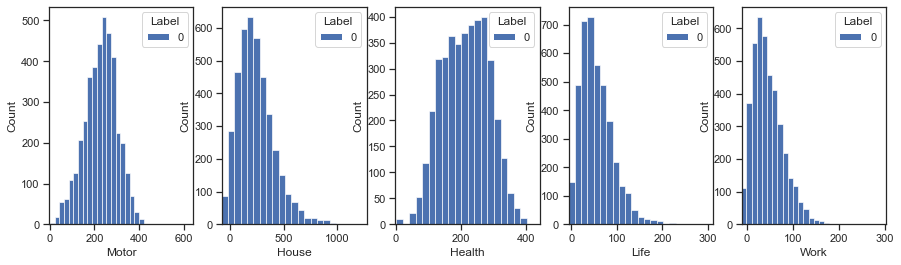

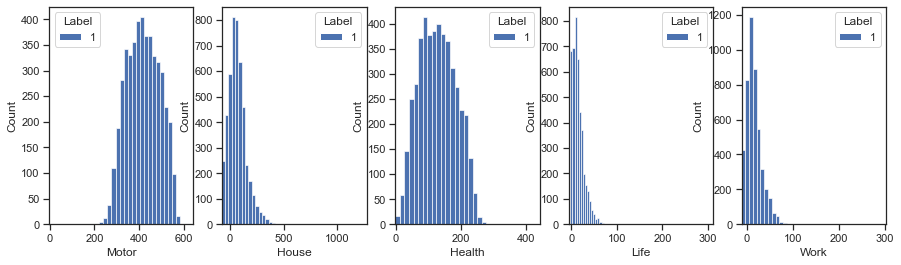

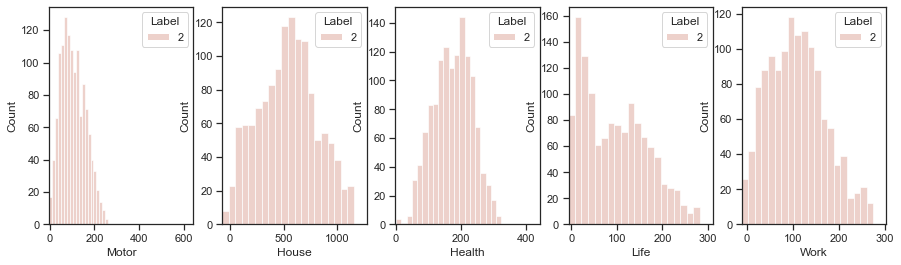

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

Silhouette score: 0.26
Davies-Bouldin score: 1.33
Calinski-Harabasz score: 3512.66
Cluster sizes:
           obs     %
Cluster            
0        2829  28.1
1        3954  39.3
2        2506  24.9
3         762   7.6


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
3          0.157705    0.350137     0.191121   0.156360   0.144677
2          0.244037    0.456673     0.185795   0.057666   0.055828
0          0.358147    0.158470     0.357928   0.062720   0.062735
1          0.688486    0.096107     0.176752   0.018946   0.019709

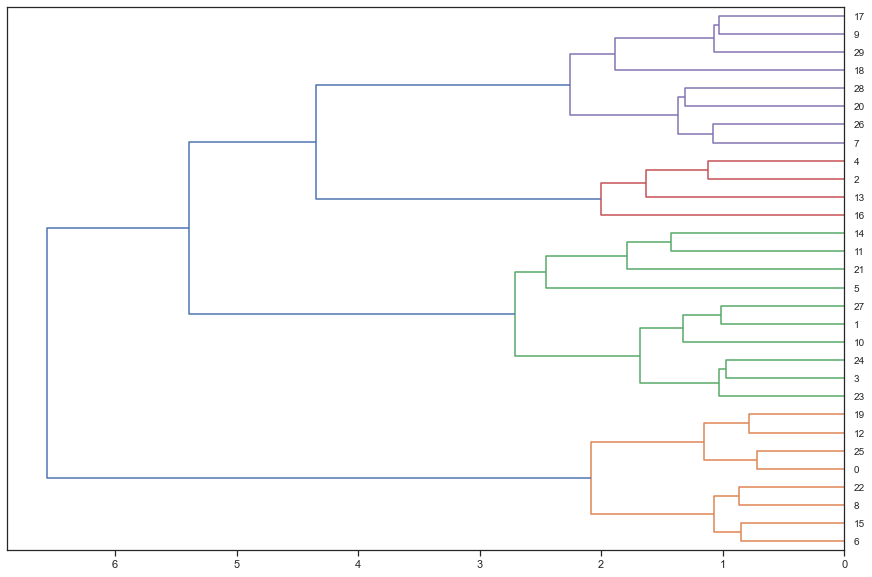

In [ ]:
## ratio premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_ratios, "robust")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_robust, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_product_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_product_linkage = hierarchy.linkage(km_product_centroids, method = "ward")
hierarchy.dendrogram(
    km_product_linkage,
    orientation = "left",
    color_threshold = 3.0
)

# hierarchical clustering of the centroids obtained
hc_product_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_product_centroids)
hc_product_labels = pd.Series(hc_product_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_product_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_product_centroids), columns = raw_features)
km_product_centroids = pd.concat([km_product_centroids, hc_product_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_product_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_product_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_product_robust, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

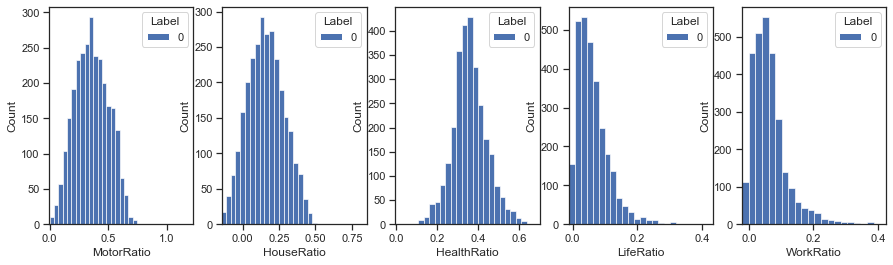

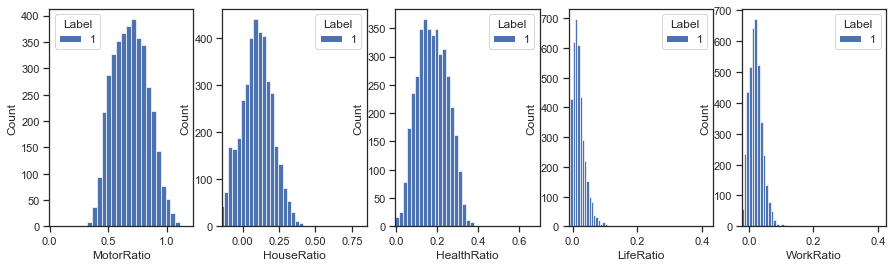

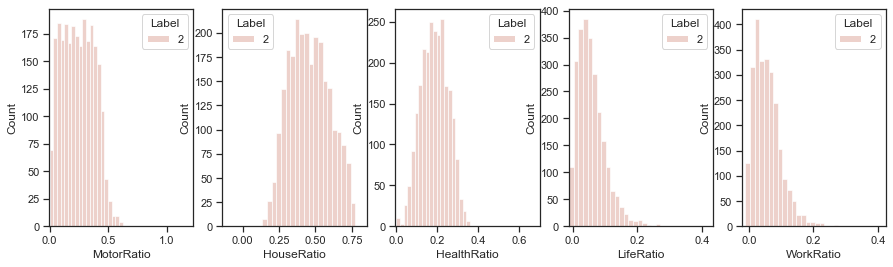

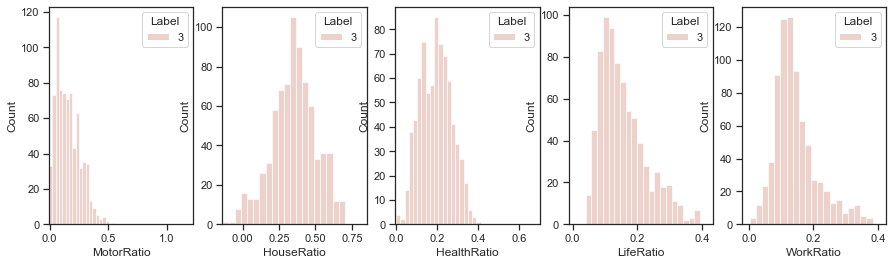

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.3. Hierarchical

Silhouette score: 0.29
Davies-Bouldin score: 1.44
Calinski-Harabasz score: 5632.33
Cluster sizes:
           obs     %
Cluster            
0        4544  45.2
1        2974  29.6
2        2533  25.2


Motor       House      Health       Life       Work
Cluster                                                          
1        185.076184  419.117603  161.478403  79.939119  77.595767
2        214.417442  180.285195  255.321477  41.861121  41.070955
0        422.864111   66.172898  123.500037  13.889923  13.946653

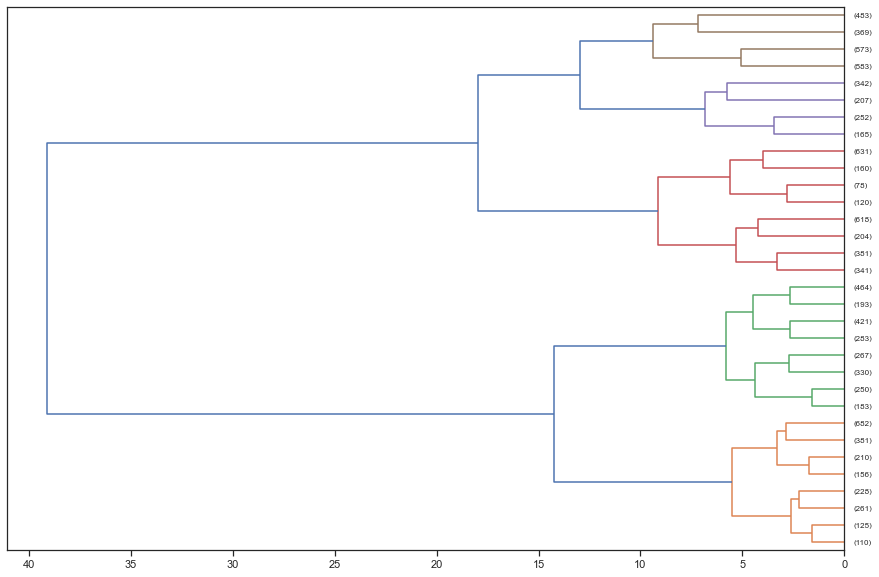

In [ ]:
## non-ratio premiums

# scale data
minmax_scaler, hc_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, hc_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, hc_product_robust = data_scaler(df_product_raw, "robust")

hc_product_distances, hc_product_labels, hc_product_linkage = hierarchical_clustering(
    hc_product_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_product_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 10
)

# perform AgglomerativeClustering
hc_product_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(hc_product_minmax)
hc_product_labels = hc_product_clusters.labels_

# overview of the clusters
df["Label"] = hc_product_labels
evaluate_clustering(hc_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

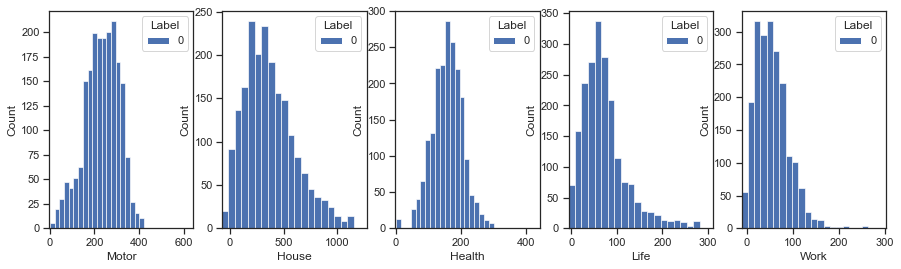

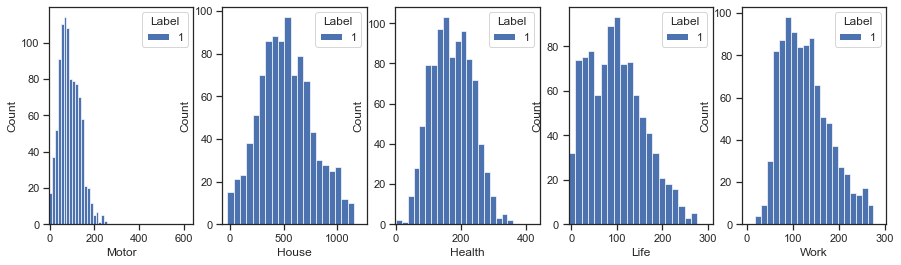

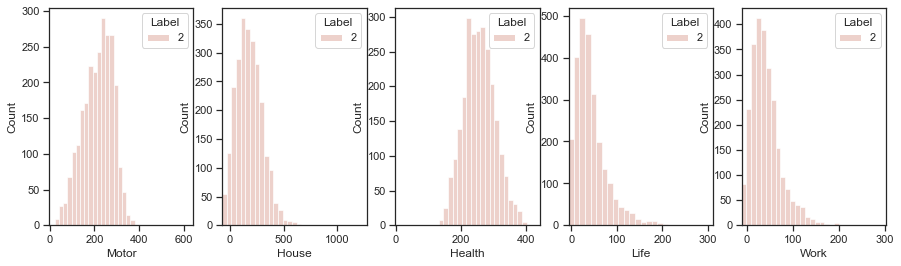

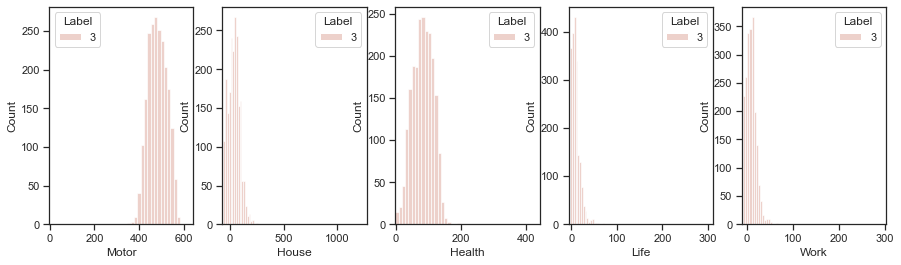

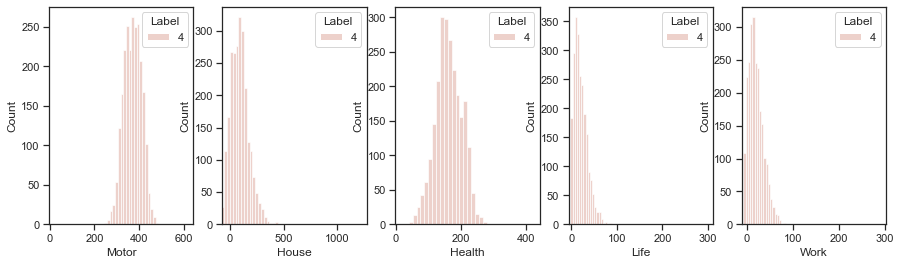

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

Silhouette score: 0.18
Davies-Bouldin score: 1.39
Calinski-Harabasz score: 3833.09
Cluster sizes:
           obs     %
Cluster            
0        1750  17.4
1        2518  25.1
2        2449  24.4
3        1214  12.1
4        1584  15.8
5         536   5.3


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
3          0.119178    0.569270     0.155727   0.084295   0.071531
5          0.182830    0.194242     0.305589   0.161735   0.155604
1          0.285141    0.348022     0.243199   0.059807   0.063830
0          0.422755    0.100564     0.366145   0.056982   0.053553
4          0.539023    0.190363     0.215885   0.026417   0.028312
2          0.781095    0.036952     0.153023   0.014220   0.014710

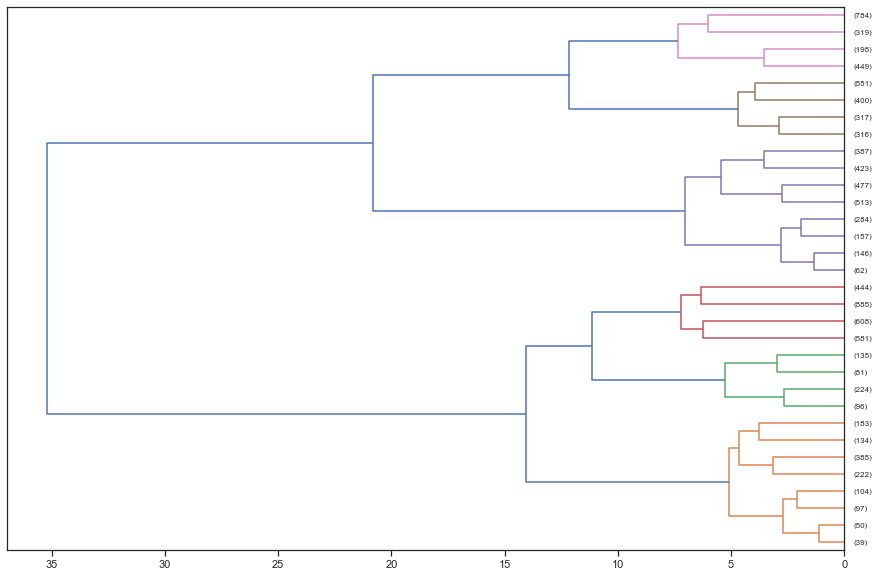

In [ ]:
## ratio premiums

# scale data
minmax_scaler, hc_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, hc_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, hc_product_robust = data_scaler(df_product_ratios, "robust")

hc_product_distances, hc_product_labels, hc_product_linkage = hierarchical_clustering(
    hc_product_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_product_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 10
)

# perform AgglomerativeClustering
hc_product_clusters = AgglomerativeClustering(n_clusters = 6, affinity = "euclidean", linkage = "ward").fit(hc_product_minmax)
hc_product_labels = hc_product_clusters.labels_

# overview of the clusters
df["Label"] = hc_product_labels
evaluate_clustering(hc_product_minmax, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

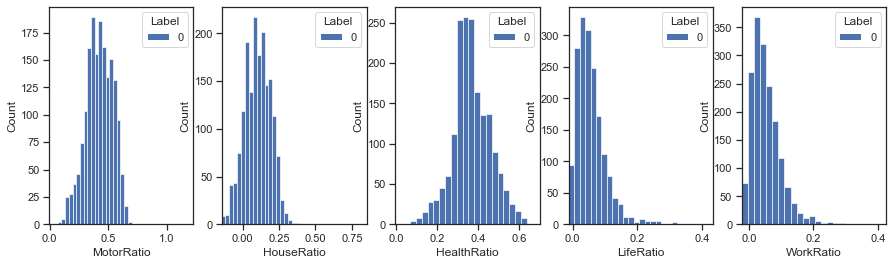

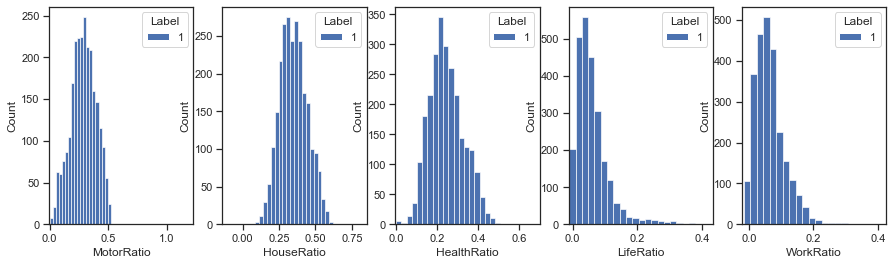

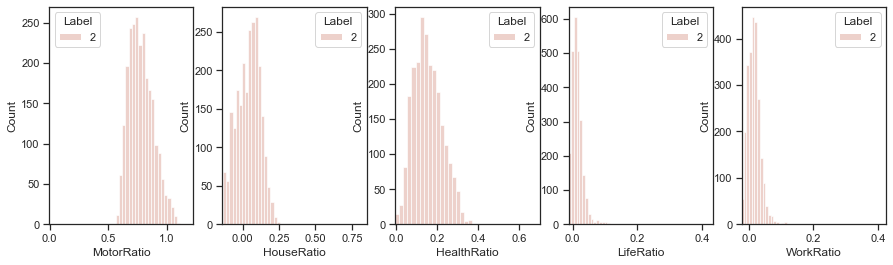

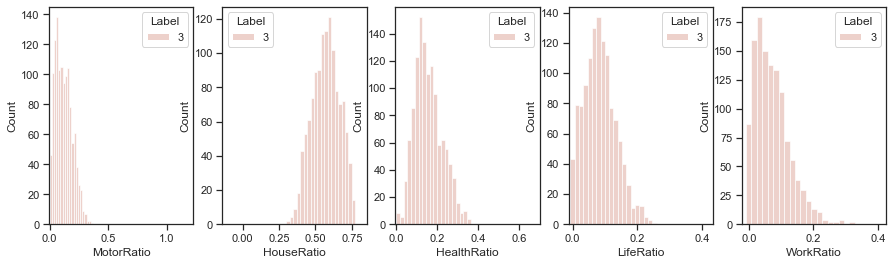

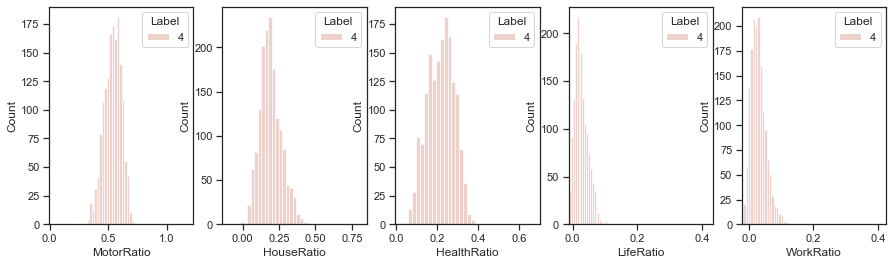

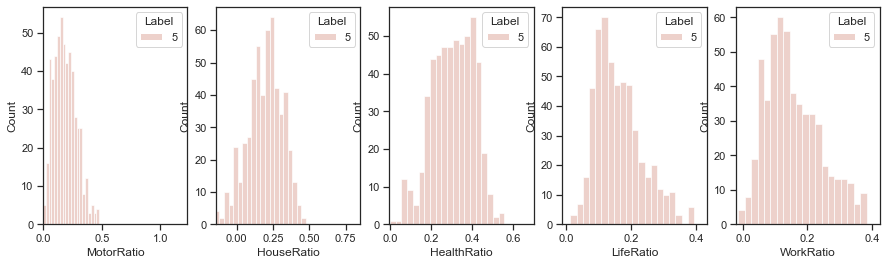

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.4. Birch

In [ ]:
## non-ratio premiums

# scale data
minmax_scaler, birch_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, birch_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, birch_product_robust = data_scaler(df_product_raw, "robust")

# model and labels
# for threshold in np.arange(0.1, 1, 0.1):
#     birch_product_clusters = Birch(threshold = threshold).fit(birch_product_minmax)
#     birch_product_labels = birch_product_clusters.labels_
#     print(threshold, set(birch_product_labels))

birch_product_clusters = Birch(threshold = 0.4).fit(birch_product_minmax)
birch_product_labels = birch_product_clusters.labels_

# overview of the clusters
df["Label"] = birch_product_labels
evaluate_clustering(birch_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

Silhouette score: 0.37
Davies-Bouldin score: 1.01
Calinski-Harabasz score: 8168.0
Cluster sizes:
           obs     %
Cluster            
0        5281  52.5
1        4770  47.5


Motor       House      Health       Life       Work
Cluster                                                          
0        191.875035  312.415953  208.327593  63.674867  61.916211
1        419.651658   74.201080  123.264616  14.805451  14.925916

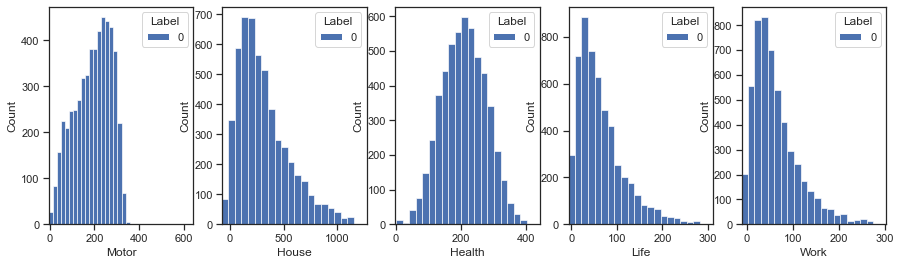

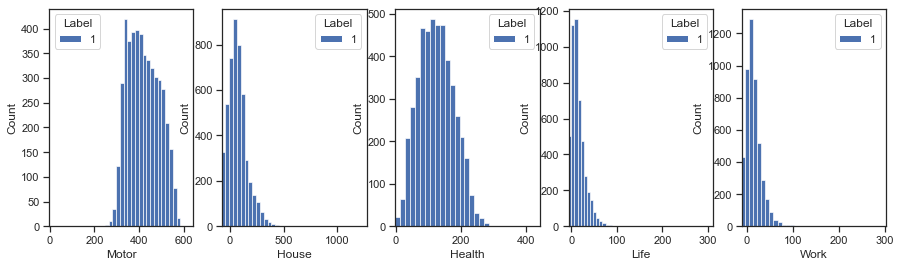

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

In [ ]:
## ratio premiums

# scale data
minmax_scaler, birch_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, birch_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, birch_product_robust = data_scaler(df_product_ratios, "robust")

# model and labels
# for threshold in np.arange(0.1, 1, 0.1):
#     birch_product_clusters = Birch(threshold = threshold).fit(birch_product_minmax)
#     birch_product_labels = birch_product_clusters.labels_
#     print(threshold, set(birch_product_labels))

birch_product_clusters = Birch(threshold = 0.2).fit(birch_product_minmax)
birch_product_labels = birch_product_clusters.labels_

# overview of the clusters
df["Label"] = birch_product_labels
evaluate_clustering(birch_product_minmax, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

Silhouette score: 0.29
Davies-Bouldin score: 1.22
Calinski-Harabasz score: 3349.38
Cluster sizes:
           obs     %
Cluster            
0        7130  70.9
1        2155  21.4
2         766   7.6


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
1          0.165768    0.505925     0.174910   0.076541   0.076856
2          0.213365    0.185842     0.308674   0.149041   0.143077
0          0.553511    0.141223     0.239736   0.033225   0.032305

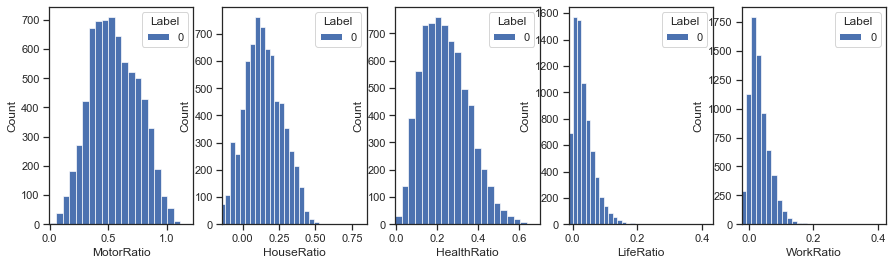

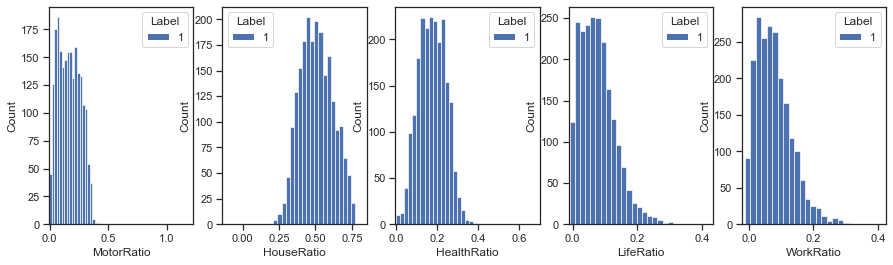

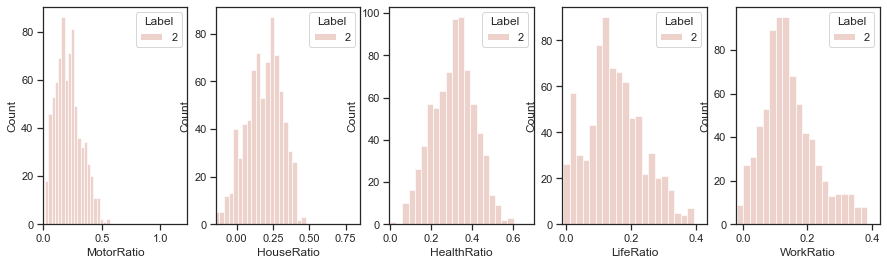

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.5. SOM + HC

In [ ]:
## non-ratio premiums

som_product = df_product_raw.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_raw.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_minmax.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.039000, quantization error: 1.051538

 epoch: 2 ---> elapsed time:  0.037000, quantization error: 1.785930

 epoch: 3 ---> elapsed time:  0.035000, quantization error: 1.281141

 epoch: 4 ---> elapsed time:  0.036000, quantization error: 1.211654

 epoch: 5 ---> elapsed time:  0.037000, quantization error: 1.173658

 epoch: 6 ---> elapsed time:  0.035000, quantization error: 1.151772

 epoch: 7 ---> elapsed time:  0.036000, quantization error: 1.139375

 epoch: 8 ---> elapsed time:  0.034000, quantization error: 1.132590

 epoch: 9 ---> elapsed time:  0.035000, quantization error: 1.127903

 epoch: 10 ---> elapsed time:  0.035000, quantization error: 1.124086

 epoch: 11 ---> elapsed time:  0.037000, quantization error: 1.120554

 epoch: 12 ---> elapsed time:  0.035000, quantization error: 1.117132

 epoch: 13 ---> 

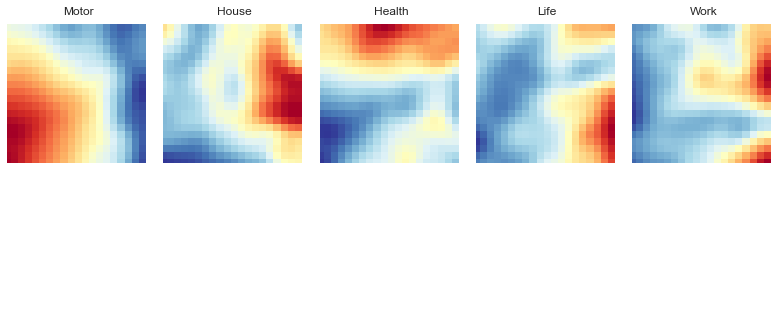

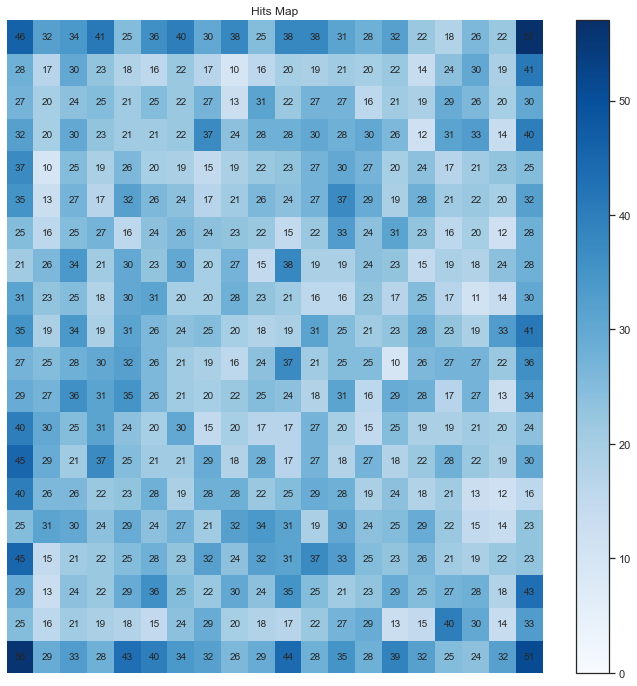

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = raw_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

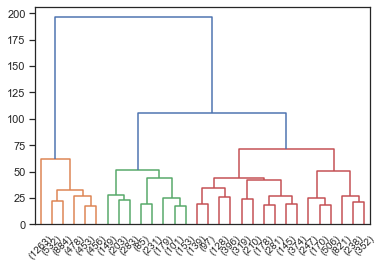

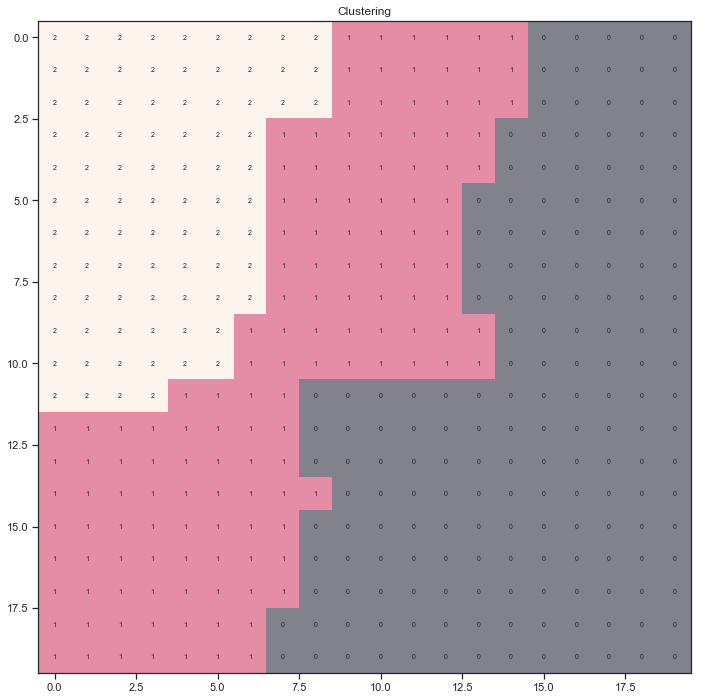

In [ ]:
# apply HC to SOM results
som_product_linkage = hierarchy.linkage(sm._data, method = "ward")
hierarchy.dendrogram(
    som_product_linkage,
    truncate_mode = "lastp",
    p = 30,
    orientation = "top",
    color_threshold = 75
)

# k = 2 or k = 4 (from dendrogram)
hc_product_labels = AgglomerativeClustering(3).fit_predict(sm.codebook.matrix)
sm.cluster_labels = hc_product_labels

# visualize clusters
hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [ ]:
# final SOM + HC clusters
db_final_clusters = AgglomerativeClustering(3).fit(sm._data)
db_final_labels = db_final_clusters.labels_

# overview of the clusters
df["Label"] = db_final_labels
evaluate_clustering(som_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label)

Silhouette score: 0.29
Davies-Bouldin score: 1.33
Calinski-Harabasz score: 5661.34
Cluster sizes:
           obs     %
Cluster            
0        4601  45.8
1        4066  40.5
2        1384  13.8


Motor       House      Health       Life       Work
Cluster                                                          
0        238.930713  199.039796  215.296451  47.904493  45.649089
1        434.049530   70.814757  113.725910  12.332691  13.602772
2        109.006409  578.101806  169.914538  98.508439  95.979624

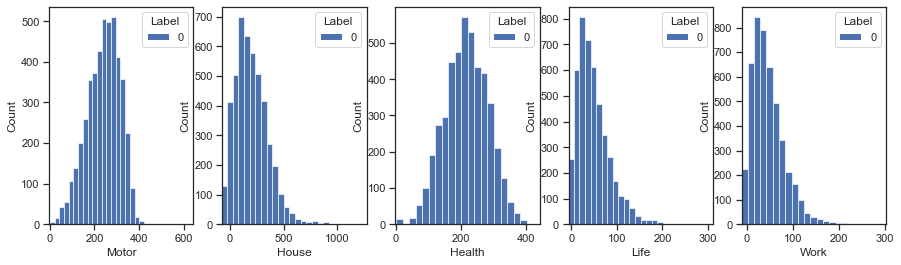

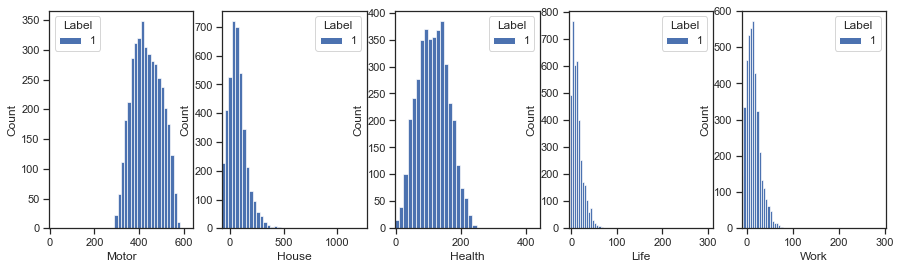

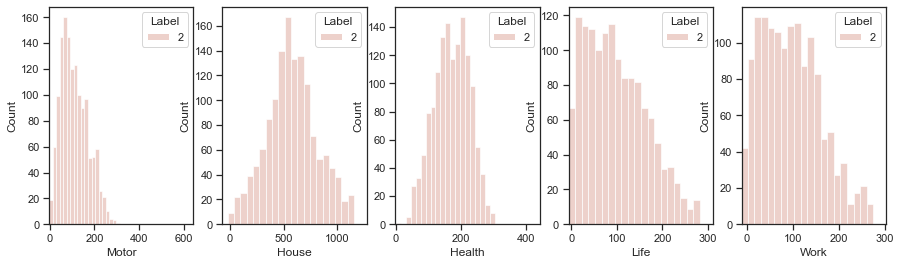

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

In [ ]:
## ratio premiums

som_product = df_product_ratios.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_ratios.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_minmax.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.038000, quantization error: 1.124470

 epoch: 2 ---> elapsed time:  0.037000, quantization error: 1.821065

 epoch: 3 ---> elapsed time:  0.036000, quantization error: 1.335535

 epoch: 4 ---> elapsed time:  0.035000, quantization error: 1.241274

 epoch: 5 ---> elapsed time:  0.035000, quantization error: 1.209502

 epoch: 6 ---> elapsed time:  0.035000, quantization error: 1.195044

 epoch: 7 ---> elapsed time:  0.036000, quantization error: 1.184235

 epoch: 8 ---> elapsed time:  0.035000, quantization error: 1.176389

 epoch: 9 ---> elapsed time:  0.036000, quantization error: 1.170092

 epoch: 10 ---> elapsed time:  0.035000, quantization error: 1.164806

 epoch: 11 ---> elapsed time:  0.036000, quantization error: 1.159886

 epoch: 12 ---> elapsed time:  0.035000, quantization error: 1.155311

 epoch: 13 ---> 

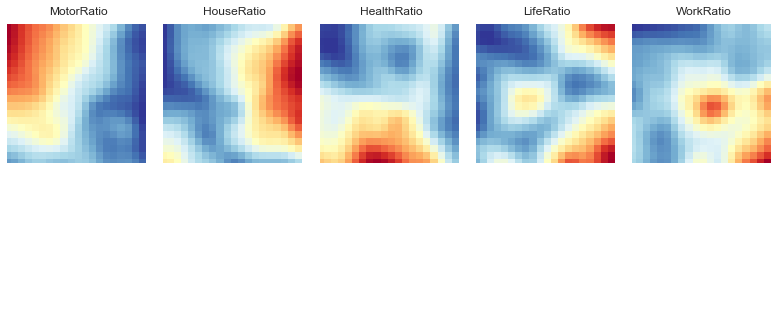

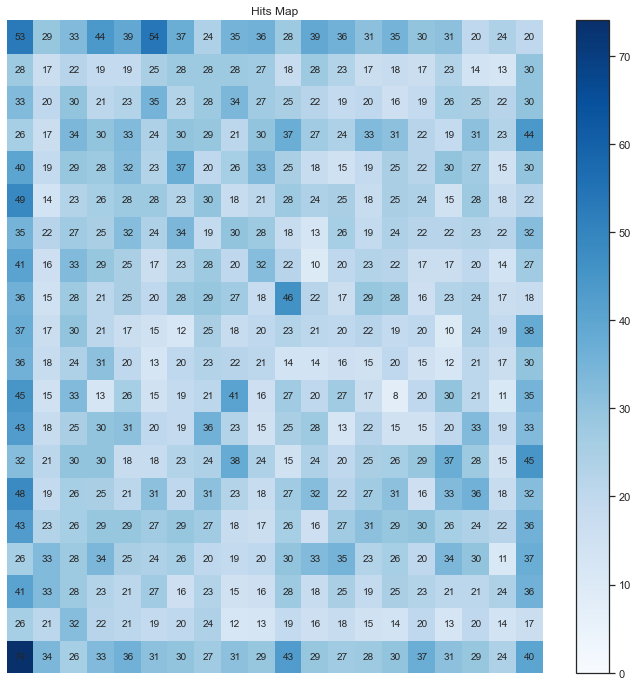

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = ratio_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

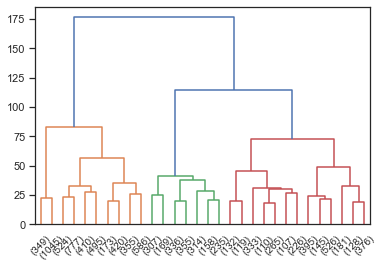

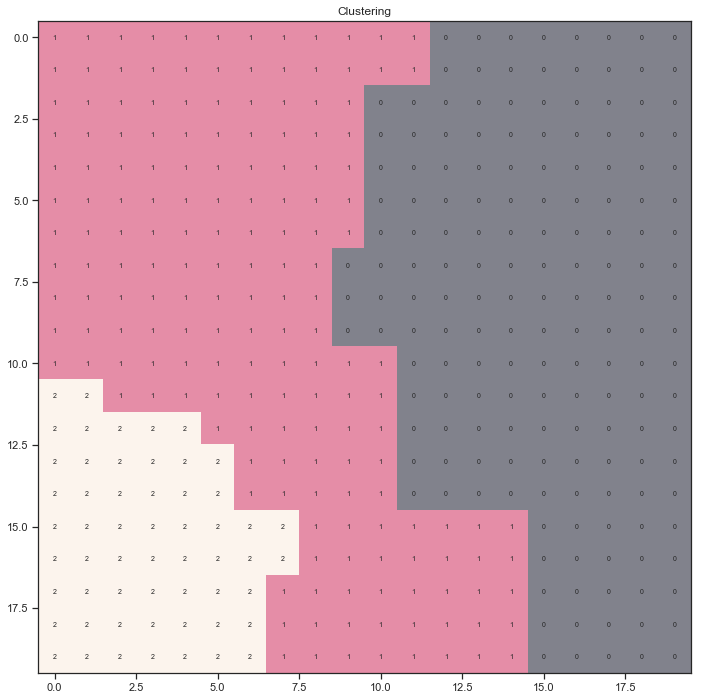

In [ ]:
# apply HC to SOM results
som_product_linkage = hierarchy.linkage(sm._data, method = "ward")
hierarchy.dendrogram(
    som_product_linkage,
    truncate_mode = "lastp",
    p = 30,
    orientation = "top",
    color_threshold = 100
)

# k = 2 or k = 4 (from dendrogram)
hc_product_labels = AgglomerativeClustering(3).fit_predict(sm.codebook.matrix)
sm.cluster_labels = hc_product_labels

# visualize clusters
hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [ ]:
# final SOM + HC clusters
db_final_clusters = AgglomerativeClustering(3).fit(sm._data)
db_final_labels = db_final_clusters.labels_

# overview of the clusters
df["Label"] = db_final_labels
evaluate_clustering(som_product_minmax, df.Label)
summarise_clustering(df_product[ratio_features], df.Label)

Silhouette score: 0.28
Davies-Bouldin score: 1.24
Calinski-Harabasz score: 4766.64
Cluster sizes:
           obs     %
Cluster            
0        5134  51.1
1        3043  30.3
2        1874  18.6


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
0          0.629557    0.130193     0.192110   0.024731   0.023409
1          0.304150    0.196085     0.336727   0.078528   0.084509
2          0.165169    0.519983     0.166350   0.080083   0.068415

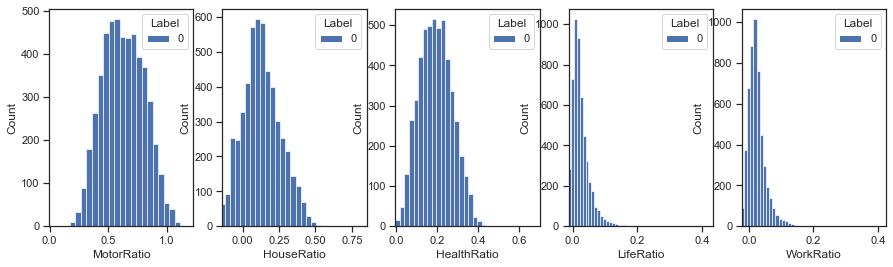

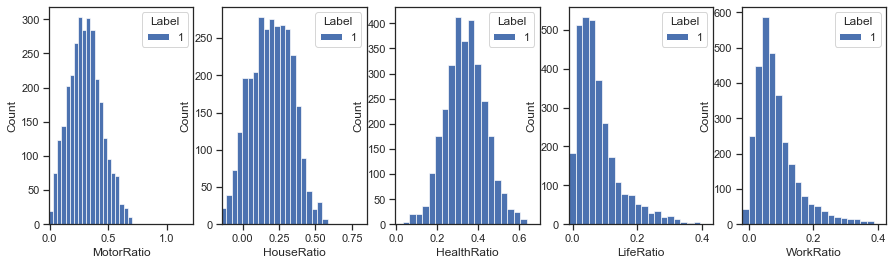

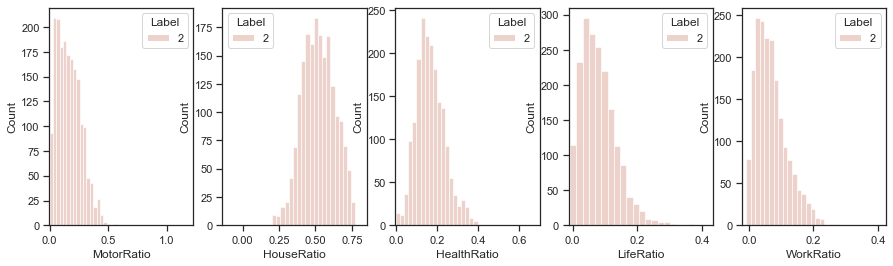

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.6. SOM + KMeans

In [ ]:
## non-ratio premiums

som_product = df_product_raw.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_raw.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_minmax.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.038000, quantization error: 1.051538

 epoch: 2 ---> elapsed time:  0.040000, quantization error: 1.785930

 epoch: 3 ---> elapsed time:  0.040000, quantization error: 1.281141

 epoch: 4 ---> elapsed time:  0.040000, quantization error: 1.211654

 epoch: 5 ---> elapsed time:  0.041000, quantization error: 1.173658

 epoch: 6 ---> elapsed time:  0.050000, quantization error: 1.151772

 epoch: 7 ---> elapsed time:  0.038000, quantization error: 1.139375

 epoch: 8 ---> elapsed time:  0.046000, quantization error: 1.132590

 epoch: 9 ---> elapsed time:  0.046000, quantization error: 1.127903

 epoch: 10 ---> elapsed time:  0.044000, quantization error: 1.124086

 epoch: 11 ---> elapsed time:  0.044000, quantization error: 1.120554

 epoch: 12 ---> elapsed time:  0.038000, quantization error: 1.117132

 epoch: 13 ---> 

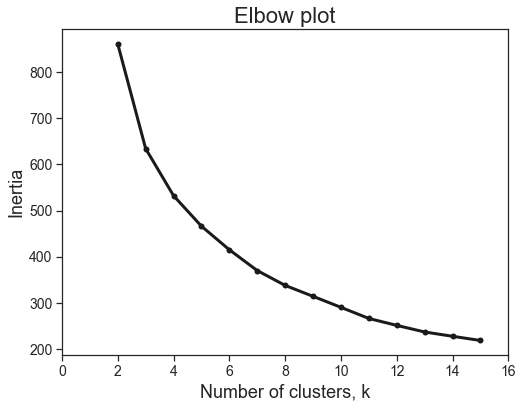

In [ ]:
# SOM + KMeans
plot_elbow(sm.codebook.matrix, 15, "kmeans")

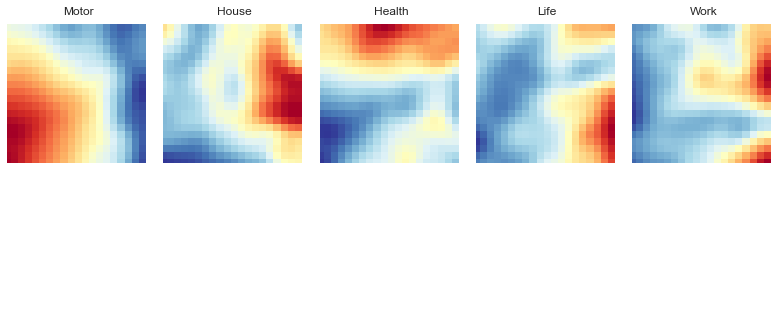

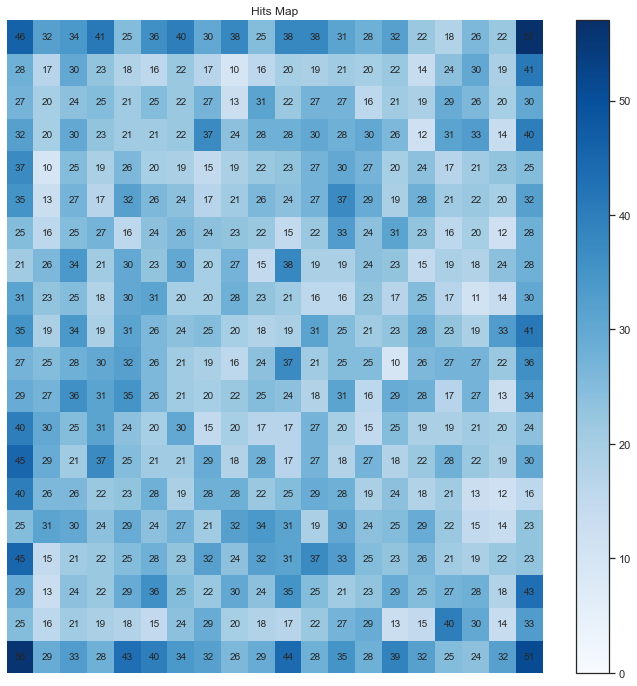

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = raw_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

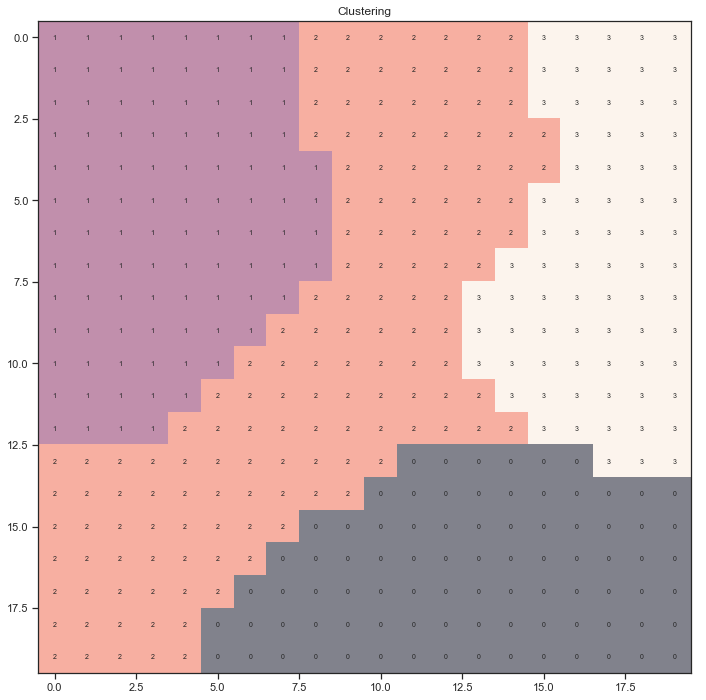

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 15)
km_product_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = km_product_labels

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate = True, onlyzeros = False, labelsize = 7, cmap = "Pastel1")

plt.show()

In [ ]:
# final SOM + KMeans clusters
km_final_clusters = KMeans(3).fit(sm._data)
km_final_labels = km_final_clusters.labels_

df["Label"] = km_final_labels
evaluate_clustering(som_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

Silhouette score: 0.32
Davies-Bouldin score: 1.24
Calinski-Harabasz score: 6761.31
Cluster sizes:
           obs     %
Cluster            
0        3819  38.0
1        4029  40.1
2        2203  21.9


Motor       House      Health       Life       Work
Cluster                                                          
2        138.688166  469.328847  167.244312  95.643264  93.009673
1        253.871102  179.902966  226.154760  36.506279  35.926344
0        441.648015   64.165305  106.973943  12.857570  12.707143

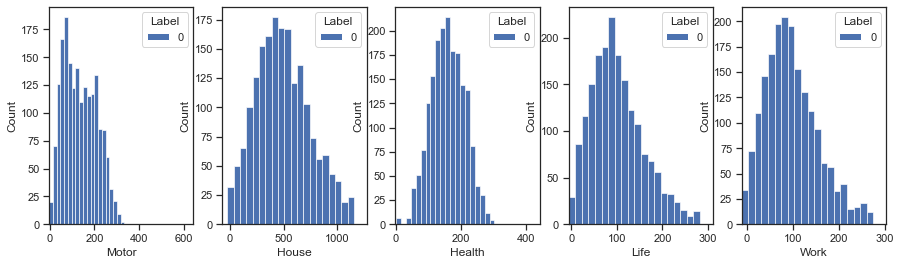

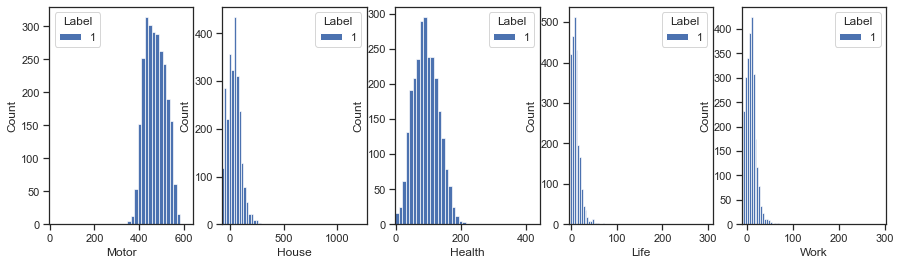

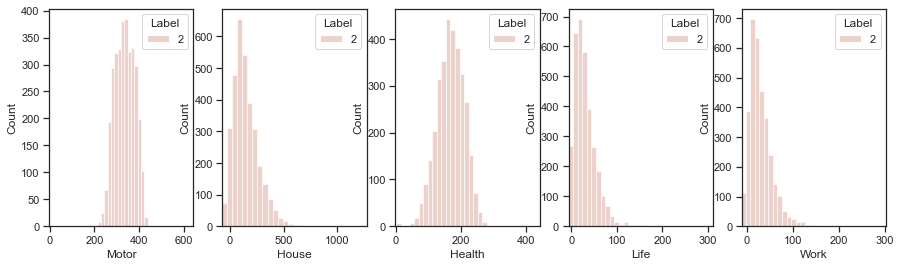

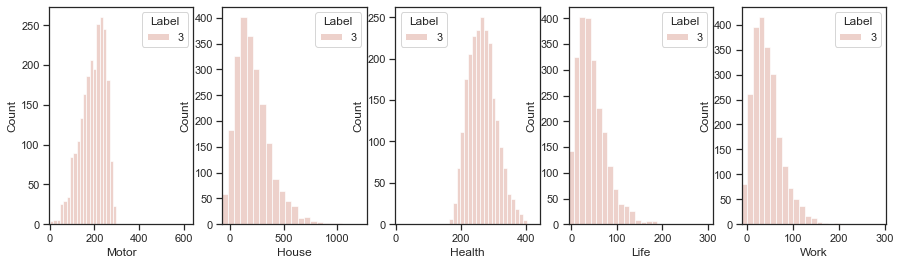

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

#### Final Sociodemographic clustering solution

In [72]:
# final sociodemographic clustering solution
# scale data
kp_sociodem = df_sociodem[["Age", "EducDeg", "Children"]]
minmax_scaler, kp_sociodem_minmax = data_scaler(kp_sociodem, "minmax")
standard_scaler, kp_sociodem_standard = data_scaler(kp_sociodem, "standard")

# # elbow plot
# # suggests 4-8 clusters
# plot_elbow(kp_sociodem_minmax, nmax_clusters = 15, algorithm = "kprototypes", cat_index = 2)

# compute centroids and labels with k = 4
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 4, cat_index = 2, init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(kp_sociodem, df.Label, sort_by = "Age")

Silhouette score: 0.42
Davies-Bouldin score: 1.03
Calinski-Harabasz score: 7411.04
Cluster sizes:
           obs     %
Cluster            
0        3458  34.4
1        3931  39.1
2        1155  11.5
3        1507  15.0


Age   EducDeg  Children
Cluster                               
0        41.175535  1.727588  0.911799
1        44.408547  3.125413  0.955482
2        68.683983  1.805195  0.092641
3        68.708693  3.130060  0.064366

In [73]:
sociodem_labels = kp_sociodem_labels

#### Final Value clustering solution

Silhouette score: 0.33
Davies-Bouldin score: 1.09
Calinski-Harabasz score: 3403.22
Cluster sizes:
           obs     %
Cluster            
0        7653  76.1
1        1667  16.6
2         316   3.1
3         415   4.1


CMV  PremTotal  EffortRatio
Cluster                                    
2          4.015443  38.440319     0.346591
0        155.231704  32.103227     0.178502
1        389.614355  35.560988     0.205331
3        794.750482  39.021026     0.289631

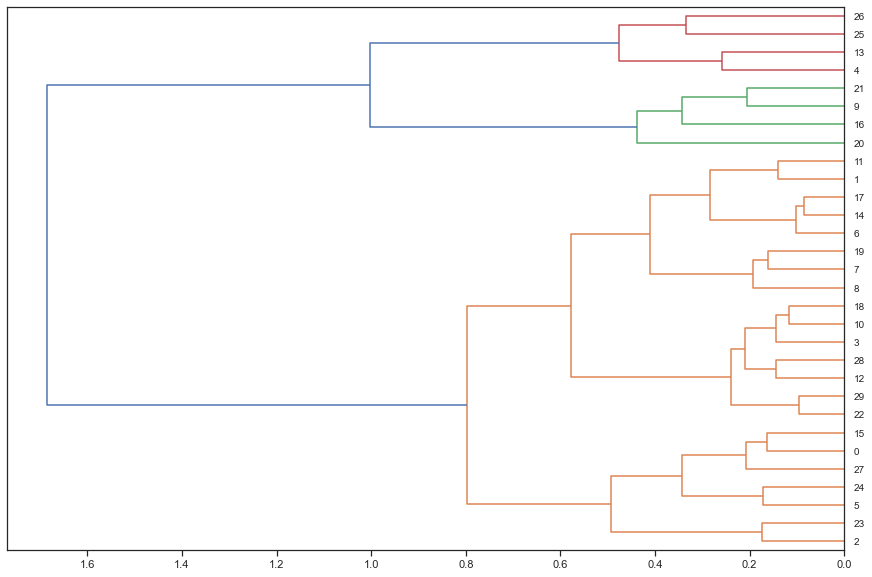

In [80]:
# final value clustering solution
# scale data
km_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_value_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_value_linkage = hierarchy.linkage(km_value_centroids, method = "ward")
hierarchy.dendrogram(
    km_value_linkage,
    orientation = "left",
    color_threshold = 1.0
)

# hierarchical clustering of the centroids obtained
hc_value_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_value_centroids)
hc_value_labels = pd.Series(hc_value_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_value_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_value_centroids), columns = ["CMV", "PremTotal", "EffortRatio"])
km_value_centroids = pd.concat([km_value_centroids, hc_value_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_value_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_value_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(km_value, df.Label, "CMV")

In [81]:
value_labels = df.Label

#### Final Product clustering solution

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.343000, quantization error: 1.051538

 epoch: 2 ---> elapsed time:  0.193000, quantization error: 1.785930

 epoch: 3 ---> elapsed time:  0.221000, quantization error: 1.281141

 epoch: 4 ---> elapsed time:  0.181000, quantization error: 1.211654

 epoch: 5 ---> elapsed time:  0.178000, quantization error: 1.173658

 epoch: 6 ---> elapsed time:  0.215000, quantization error: 1.151772

 epoch: 7 ---> elapsed time:  0.206000, quantization error: 1.139375

 epoch: 8 ---> elapsed time:  0.178000, quantization error: 1.132590

 epoch: 9 ---> elapsed time:  0.105000, quantization error: 1.127903

 epoch: 10 ---> elapsed time:  0.101000, quantization error: 1.124086

 epoch: 11 ---> elapsed time:  0.105000, quantization error: 1.120554

 epoch: 12 ---> elapsed time:  0.103000, quantization error: 1.117132

 epoch: 13 ---> 

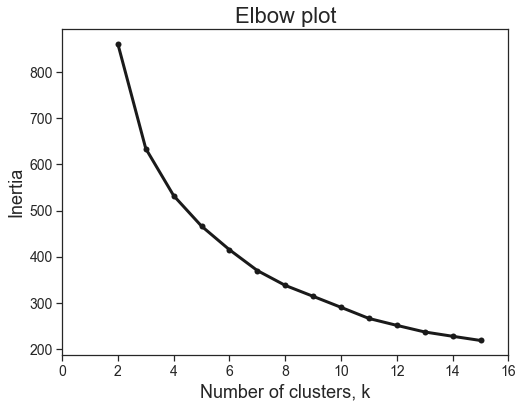

In [84]:
# final product clustering solution
som_product = df_product_raw.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_raw.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_minmax.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

plot_elbow(sm.codebook.matrix, 15, "kmeans")

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = raw_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

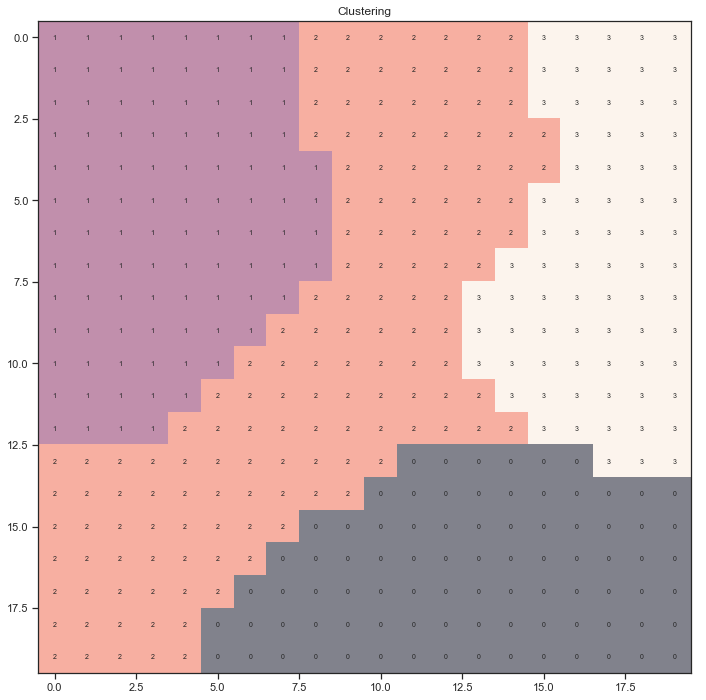

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 15)
km_product_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = km_product_labels

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate = True, onlyzeros = False, labelsize = 7, cmap = "Pastel1")

plt.show()

In [86]:
km_final_clusters = KMeans(3).fit(sm._data)
km_final_labels = km_final_clusters.labels_

df["Label"] = km_final_labels
evaluate_clustering(som_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

Silhouette score: 0.32
Davies-Bouldin score: 1.23
Calinski-Harabasz score: 6763.62
Cluster sizes:
           obs     %
Cluster            
0        4053  40.3
1        3833  38.1
2        2165  21.5


Motor       House      Health       Life       Work
Cluster                                                          
2        137.470762  472.206467  166.840370  96.466351  93.264508
0        253.129788  181.435270  225.964930  36.640064  36.423686
1        441.291740   64.211753  107.254104  12.923856  12.688043

In [87]:
product_labels = km_final_labels

#### Final clustering solution (combined)

In [88]:
# new dataframe with the final cluster labels
# df.drop(columns = "Label", inplace = True)
df_clusters = df.copy()

# add columns with cluster labels
df_clusters["Sociodem"] = sociodem_labels
df_clusters["Value"] = value_labels
df_clusters["Product"] = product_labels

# rename clusters
sociodem_longlabels = {
    0: "MiddleAged_LowEduc_Child",
    1: "MiddleAged_HighEduc_Child",
    2: "Elderly_LowEduc_NoChild",
    3: "Elderly_HighEduc_NoChild"
}
value_longlabels = {
    0: "Silver",
    1: "Gold",
    2: "Bronze",
    3: "Platinum"
}
product_longlabels = {
    0: "Motor",
    1: "House_Life_Work",
    2: "Health"
}
df_clusters["Sociodem"].replace(sociodem_longlabels, inplace = True)
df_clusters["Value"].replace(value_longlabels, inplace = True)
df_clusters["Product"].replace(product_longlabels, inplace = True)

# check cluster sizes
print(Counter(df_clusters.Sociodem))
print(Counter(df_clusters.Value))
print(Counter(df_clusters.Product))

Counter({'MiddleAged_HighEduc_Child': 3931, 'MiddleAged_LowEduc_Child': 3458, 'Elderly_HighEduc_NoChild': 1507, 'Elderly_LowEduc_NoChild': 1155})
Counter({'Silver': 7653, 'Gold': 1667, 'Platinum': 415, 'Bronze': 316})
Counter({'Motor': 4053, 'House_Life_Work': 3833, 'Health': 2165})


In [89]:
# combine clusters
df_clusters["Label"] = df_clusters["Sociodem"] + "_" + df_clusters["Value"] + "_" + df_clusters["Product"]
df_clusters.drop(columns = ["Sociodem", "Value", "Product"], inplace = True)

In [90]:
df_clusters.groupby("Label").size().sort_values(ascending = False)

Label
MiddleAged_HighEduc_Child_Silver_House_Life_Work     2186
MiddleAged_HighEduc_Child_Silver_Motor               1103
MiddleAged_LowEduc_Child_Silver_Motor                 914
MiddleAged_LowEduc_Child_Silver_House_Life_Work       842
Elderly_HighEduc_NoChild_Silver_Motor                 786
Elderly_LowEduc_NoChild_Silver_Motor                  489
Elderly_HighEduc_NoChild_Silver_House_Life_Work       481
MiddleAged_LowEduc_Child_Silver_Health                435
MiddleAged_LowEduc_Child_Gold_Health                  415
MiddleAged_LowEduc_Child_Platinum_Health              279
MiddleAged_LowEduc_Child_Bronze_Health                256
MiddleAged_HighEduc_Child_Gold_Motor                  223
MiddleAged_LowEduc_Child_Gold_Motor                   216
Elderly_LowEduc_NoChild_Gold_Health                   202
Elderly_LowEduc_NoChild_Silver_Health                 156
Elderly_LowEduc_NoChild_Gold_Motor                    132
Elderly_LowEduc_NoChild_Silver_House_Life_Work        126
Elderly_

In [91]:
label_names = list(df_clusters.groupby("Label").size().index)
label_sizes = list(df_clusters.groupby("Label").size())
size_dict = {}

# create a dictionary with name and size of each clusters
for name, size in zip(label_names, label_sizes):
    size_dict[name] = size

In [94]:
# create a column with the size of the cluster each observation belongs to
df_clusters["Size"] = df_clusters.Label.apply(lambda x: size_dict.get(x))

# separate the rows to be relabelled from the labelled rows
orphan_obs_df = df_clusters[df_clusters["Size"] < 400].drop(columns = "Size")
labelled_obs_df = df_clusters[~(df_clusters["Size"] < 400)].drop(columns = "Size")

training_features = [
    "Age",
    "EducDeg",
    "Children",
    "CMV",
    "PremTotal",
    "EffortRatio",
    "Motor",
    "House",
    "Health",
    "Life",
    "Work"
]

In [98]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

# independent, X, and dependent, y, variables
X = labelled_obs_df[training_features]
y = labelled_obs_df.Label

# split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

clf = DecisionTreeClassifier(
    random_state = 15,
    max_depth = 7,
    criterion = "gini"
).fit(X_train, y_train)

y_pred = clf.predict(X_val)

# evaluate predictions
accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
print(f"Classification Tree Accuracy: {accuracy} %")

Classification Tree Accuracy: 92.64 %


In [99]:
# classify orphan observations
X_test = orphan_obs_df[training_features]
y_pred = clf.predict(X_test)

orphan_obs_df["Label"] = y_pred

final_final = pd.concat([labelled_obs_df, orphan_obs_df])
final_final.groupby("Label").mean().sort_values("Age")

Generation        Age  \
Label                                                                     
MiddleAged_LowEduc_Child_Gold_Health                3.364146  36.979458   
MiddleAged_LowEduc_Child_Silver_Health              3.212476  39.633528   
MiddleAged_HighEduc_Child_Silver_Motor              3.187422  40.406600   
MiddleAged_LowEduc_Child_Silver_Motor               3.005440  43.057117   
MiddleAged_HighEduc_Child_Silver_House_Life_Work    2.772239  47.171036   
MiddleAged_LowEduc_Child_Silver_House_Life_Work     2.634969  49.461145   
Elderly_HighEduc_NoChild_Silver_House_Life_Work     1.662722  66.702170   
Elderly_LowEduc_NoChild_Silver_Motor                1.547468  69.528481   
Elderly_HighEduc_NoChild_Silver_Motor               1.542084  69.775551   

                                                       YearSal   EducDeg  \
Label                                                                      
MiddleAged_LowEduc_Child_Gold_Health              19681.304173  1.575163   
MiddleAged_LowEduc_Child_Silver_Health            22010.772523  1.610136   
MiddleAged_HighEduc_Child_Silver_Motor            23910.542077  3.075965   
MiddleAged_LowEduc_Child_Silver_Motor             25504.812817  1.822303   
MiddleAged_HighEduc_Child_Silver_House_Life_Work  29056.869463  3.159433   
MiddleAged_LowEduc_Child_Silver_House_Life_Work   30974.982228  1.861963   
Elderly_HighEduc_NoChild_Silver_House_Life_Work   41799.692308  3.197239   
Elderly_LowEduc_NoChild_Silver_Motor              43623.007171  1.809072   
Elderly_HighEduc_NoChild_Silver_Motor             44064.424864  3.096192   

                                                  Children  FirstPolAge  \
Label                                                                     
MiddleAged_LowEduc_Child_Gold_Health              0.780579    12.987862   
MiddleAged_LowEduc_Child_Silver_Health            0.777778    14.631579   
MiddleAged_HighEduc_Child_Silver_Motor            0.940224    12.523039   
MiddleAged_LowEduc_Child_Silver_Motor             0.934723    14.563010   
MiddleAged_HighEduc_Child_Silver_House_Life_Work  0.965191    17.600774   
MiddleAged_LowEduc_Child_Silver_House_Life_Work   0.951943    19.429448   
Elderly_HighEduc_NoChild_Silver_House_Life_Work   0.143984    37.082840   
Elderly_LowEduc_NoChild_Silver_Motor              0.066456    39.864979   
Elderly_HighEduc_NoChild_Silver_Motor             0.024048    39.887776   

                                                  CustYears         CMV  \
Label                                                                     
MiddleAged_LowEduc_Child_Gold_Health              23.991597  401.402885   
MiddleAged_LowEduc_Child_Silver_Health            25.001949   65.609825   
MiddleAged_HighEduc_Child_Silver_Motor            27.883562  206.477154   
MiddleAged_LowEduc_Child_Silver_Motor             28.494107  171.571224   
MiddleAged_HighEduc_Child_Silver_House_Life_Work  29.570262  218.363421   
MiddleAged_LowEduc_Child_Silver_House_Life_Work   30.031697  200.539008   
Elderly_HighEduc_NoChild_Silver_House_Life_Work   29.619329  205.969428   
Elderly_LowEduc_NoChild_Silver_Motor              29.663502  202.169905   
Elderly_HighEduc_NoChild_Silver_Motor             29.887776  184.185962   

                                                  ClaimsRate       Motor  ...  \
Label                                                                     ...   
MiddleAged_LowEduc_Child_Gold_Health                0.595658  129.199711  ...   
MiddleAged_LowEduc_Child_Silver_Health              0.875478  140.666413  ...   
MiddleAged_HighEduc_Child_Silver_Motor              0.700473  253.684738  ...   
MiddleAged_LowEduc_Child_Silver_Motor               0.734823  250.306655  ...   
MiddleAged_HighEduc_Child_Silver_House_Life_Work    0.621942  447.397929  ...   
MiddleAged_LowEduc_Child_Silver_House_Life_Work     0.652863  432.748681  ...   
Elderly_HighEduc_NoChild_Silver_House_Life_Work     0.645602  416.714970  ...   
Elderl

In [107]:
#classify outliers
df_outliers["Label"]=clf.predict(df_outliers[training_features])

final_final_w_outliers=pd.concat([final_final, df_outliers])
final_final_w_outliers.groupby("Label").mean().sort_values("Age")

Generation        Age  \
Label                                                                     
MiddleAged_LowEduc_Child_Gold_Health                3.378866  36.737113   
MiddleAged_LowEduc_Child_Silver_Health              3.220755  39.477358   
MiddleAged_HighEduc_Child_Silver_Motor              3.188807  40.392374   
MiddleAged_LowEduc_Child_Silver_Motor               3.018601  42.855624   
MiddleAged_HighEduc_Child_Silver_House_Life_Work    2.772688  47.157106   
MiddleAged_LowEduc_Child_Silver_House_Life_Work     2.634694  49.473469   
Elderly_HighEduc_NoChild_Silver_House_Life_Work     1.662109  66.736328   
Elderly_LowEduc_NoChild_Silver_Motor                1.545550  69.552880   
Elderly_HighEduc_NoChild_Silver_Motor               1.541376  69.783649   

                                                       YearSal   EducDeg  \
Label                                                                      
MiddleAged_LowEduc_Child_Gold_Health              19432.736057  1.545533   
MiddleAged_LowEduc_Child_Silver_Health            21808.449630  1.603774   
MiddleAged_HighEduc_Child_Silver_Motor            23917.818662  3.076876   
MiddleAged_LowEduc_Child_Silver_Motor             25893.091707  1.815766   
MiddleAged_HighEduc_Child_Silver_House_Life_Work  29045.426045  3.159247   
MiddleAged_LowEduc_Child_Silver_House_Life_Work   30976.176142  1.862245   
Elderly_HighEduc_NoChild_Silver_House_Life_Work   41820.115053  3.197266   
Elderly_LowEduc_NoChild_Silver_Motor              43643.793506  1.807330   
Elderly_HighEduc_NoChild_Silver_Motor             44076.055860  3.095713   

                                                  Children  FirstPolAge  \
Label                                                                     
MiddleAged_LowEduc_Child_Gold_Health              0.770619    13.023196   
MiddleAged_LowEduc_Child_Silver_Health            0.773585    14.647170   
MiddleAged_HighEduc_Child_Silver_Motor            0.940344    12.501230   
MiddleAged_LowEduc_Child_Silver_Motor             0.931798    14.478299   
MiddleAged_HighEduc_Child_Silver_House_Life_Work  0.964897    17.586473   
MiddleAged_LowEduc_Child_Silver_House_Life_Work   0.952041    19.428571   
Elderly_HighEduc_NoChild_Silver_House_Life_Work   0.144531   138.328125   
Elderly_LowEduc_NoChild_Silver_Motor              0.065969    39.904712   
Elderly_HighEduc_NoChild_Silver_Motor             0.024925    39.889332   

                                                  CustYears         CMV  \
Label                                                                     
MiddleAged_LowEduc_Child_Gold_Health              23.713918  422.841667   
MiddleAged_LowEduc_Child_Silver_Health            24.830189   66.422566   
MiddleAged_HighEduc_Child_Silver_Motor            27.891144  176.774717   
MiddleAged_LowEduc_Child_Silver_Motor             28.377325  163.149973   
MiddleAged_HighEduc_Child_Silver_House_Life_Work  29.570634  110.491695   
MiddleAged_LowEduc_Child_Silver_House_Life_Work   30.044898  200.613745   
Elderly_HighEduc_NoChild_Silver_House_Life_Work  -71.591797  211.888926   
Elderly_LowEduc_NoChild_Silver_Motor              29.648168  118.988932   
Elderly_HighEduc_NoChild_Silver_Motor             29.894317  145.852522   

                                                  ClaimsRate       Motor  ...  \
Label                                                                     ...   
MiddleAged_LowEduc_Child_Gold_Health                0.592637  123.391564  ...   
MiddleAged_LowEduc_Child_Silver_Health              0.872604  137.822075  ...   
MiddleAged_HighEduc_Child_Silver_Motor              0.749157  258.693641  ...   
MiddleAged_LowEduc_Child_Silver_Motor               0.746112  246.273738  ...   
MiddleAged_HighEduc_Child_Silver_House_Life_Work    0.791224  450.684452  ...   
MiddleAged_LowEduc_Child_Silver_House_Life_Work     0.653541  432.817173  ...   
Elderly_HighEduc_NoChild_Silver_House_Life_Work     0.651914  423.685371  ...   
Elderl

In [100]:
#analysis of cancelled insurances
df_temp=df.copy()
#health and motor are removed as its only one person
for premium in ["Work","Life","House"]:
    df_temp["Canceled"]=df_temp[premium]<0
    print(premium)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df_temp.groupby("Canceled").mean())
print("Any cancelation")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    df_temp["Canceled"]=(df.Health<0) | (df.Life<0) | (df.Work<0) | (df.House<0) | (df.Motor<0)
    display(df_temp.groupby("Canceled").mean())

Work


Generation        Age       YearSal   EducDeg  Children  \
Canceled                                                            
False       2.648578  49.662582  30087.269768  2.455799  0.698249   
True        2.583974  50.398463  31105.285593  2.871570  0.802415   

          FirstPolAge  CustYears         CMV  ClaimsRate       Motor  \
Canceled                                                               
False       21.348578  28.314004  217.442162    0.683097  287.774822   
True        20.664105  29.734358  198.841196    0.656004  422.358507   

          MotorRatio       House  HouseRatio      Health  HealthRatio  \
Canceled                                                                
False       0.420935  209.808408    0.233681  172.442208     0.235580   
True        0.680416   94.576235    0.113835  122.973063     0.186045   

               Life  LifeRatio       Work  WorkRatio  PremTotal  EffortRatio  \
Canceled                                                                       
False     42.585624   0.053784  44.012898   0.056020  756.62396     0.032768   
True      19.381306   0.026803  -4.502481  -0.007099  654.78663     0.023836   

             Label  
Canceled            
False     0.810284  
True      0.830955

Life


Generation        Age       YearSal   EducDeg  Children  \
Canceled                                                            
False       2.641815  49.752583  30172.751100  2.465012  0.697305   
True        2.655589  49.398792  30275.831999  2.897281  0.854985   

          FirstPolAge  CustYears         CMV  ClaimsRate       Motor  \
Canceled                                                               
False       21.405688  28.346895  215.719052    0.684166  290.740831   
True        19.596677  29.802115  216.283248    0.630665  430.913610   

          MotorRatio       House  HouseRatio      Health  HealthRatio  \
Canceled                                                                
False       0.427071  207.026851    0.230691  171.405750     0.234805   
True        0.690987   90.683837    0.111167  119.065937     0.178417   

               Life  LifeRatio       Work  WorkRatio   PremTotal  EffortRatio  \
Canceled                                                                        
False     43.546995   0.055287  41.156343   0.052148  753.876770     0.032496   
True      -2.981526  -0.004650  17.763187   0.024079  655.445045     0.024340   

             Label  
Canceled            
False     0.812121  
True      0.812689

House


Generation        Age       YearSal   EducDeg  Children  \
Canceled                                                            
False       2.645754  49.684867  30063.757617  2.450858  0.694228   
True        2.617456  50.099350  31144.289694  2.848654  0.819870   

          FirstPolAge  CustYears         CMV  ClaimsRate       Motor  \
Canceled                                                               
False       21.401939  28.282928  224.989477    0.677700  285.698389   
True        20.324977  29.774373  138.820910    0.705153  418.916555   

          MotorRatio       House  HouseRatio      Health  HealthRatio  \
Canceled                                                                
False       0.406908  226.756146    0.255965  172.922611     0.231488   
True        0.757293  -28.878227   -0.053375  126.594921     0.227783   

               Life  LifeRatio       Work  WorkRatio   PremTotal  EffortRatio  \
Canceled                                                                        
False     43.040558   0.053377  42.090924   0.052262  770.508627     0.033422   
True      19.167131   0.034355  18.989954   0.033944  554.790334     0.019768   

             Label  
Canceled            
False     0.811567  
True      0.817084

Any cancelation


Generation        Age       YearSal   EducDeg  Children  \
Canceled                                                            
False       2.650879  49.626050  29981.723058  2.399796  0.679399   
True        2.613564  50.098316  30886.712772  2.828402  0.808830   

          FirstPolAge  CustYears         CMV  ClaimsRate       Motor  \
Canceled                                                               
False       21.507257  28.118793  225.587227    0.683023  269.482423   
True        20.497497  29.600819  180.611566    0.672130  408.973837   

          MotorRatio       House  HouseRatio      Health  HealthRatio  \
Canceled                                                                
False       0.378202  239.871639    0.268522  178.066948     0.236388   
True        0.681293   54.554370    0.059432  131.821771     0.212155   

               Life  LifeRatio       Work  WorkRatio   PremTotal  EffortRatio  \
Canceled                                                                        
False     47.275028   0.058465  47.055533   0.058423  781.751571     0.034471   
True      16.199772   0.025864  13.018648   0.021256  624.568398     0.022977   

             Label  
Canceled            
False     0.818182  
True      0.790624